<span style="font-size:30pt;font-weight:bold">Home Credit Stability binning</font>

**Copyright:**

© 2020, Kamil Yazigee, work-in-progress.

Automatic binning with optimal stable Gini.

Based of Scoring workflow ( inserted cells **4**,**5**,**40**,**46** and **51**) for a recent project.

Idea is to make most of the decisions pertaining to design of WOE bins  **all in one place** from point of view  of **performance** and **rank time-stability** of the resulting bins.

Aim is to significantly minimize the manual and time consuming interactive binning,  while at the same time preserving compatibility with the interactive binning should that be still occasionally needed ( e.g. for business reasons).


**Algorithm outline for automatic binning (validation version / will supplement cross validation version in a future 
release):**

**I)** split train set into two sets : **train_woe** and **validation_woe** (50/50)
    
**II)**
- **for *var* in variables:**

    
-   **T** = **train_woe**[~pd.isnull(**train_woe**[*var*])]

-   **V** = **valid_woe**[~pd.isnull(**valid_woe**[*var*])]

    
-  **for n_bins in range (2,11):**   *( this is an inner loop inside the **for var in variables** loop)*

     **a)** train a tree model (LGBM - see comment below) **M**,  on **T** with parameters : 
    `num_leaves` = **n_bins**
    `min_data_in_leaf` = 0.05***T**.shape[0] (*this condition can be released for special variables 
     ( e.g. hardchecks). In this case the  'min_data_in_leaf' is set to 100*).
        
    **b)** evaluate Gini of **M** on each time stamp of **V** (most frequently month):
    if we have *k* months, we have *k* ginis. Take average gini of those k ginis --> **Gini(n_bins)**
        
    **c)** At the same time, calculate [using **V**] **Elena's rank stability index, RSI**, (version 1) 
    for target rate : the model **M** defines a certain grouping of *var* ( e.g. for **n_bins** = 3 we have
    var partitioned into 3 bins) so calculate target rate in each bin across the time stamp and
    get the **RSI** as usual. ( The **RSI** for all bins is the average of **RSI** of each constituent bin.
    The **RSI** of a constituent bin is 100% if the rank of its target rate relative to other bins's target 
    rates remained constant across all time stamps; otherwise, it decreases depending on how many times did the 
    rank of the bin change).
        
    *NOTE*: A modification was made to the way that a bin's **RSI** is determined : if for any given bin 
    whose rank has changed at least once,  the **max of [aboslute values of that bin's target rate changes that are
    associated with the rank order changes]**  is <= `bin_stability_threshold`***(max (target rate across all bins) - 
    min(target rate across all bins) )**,  then the rank order changes for this bin are ignored ( as if its rank 
    had stayed constant). In other words, such a bin has **RSI = 100%**, although its ranking had changed, because the
    change is 'acceptably small' relative to the spread of target rates across all bins. The `bin_stability_threshold` 
    parameter can be set. Currently it is at **10%**.
        
    
 -At the end of the inner loop, the recommended # of bins for *var*  is :
    
**min ( argmax( Gini(n_bins) | RSI = 100% )  )**   

**In other words, we take the maximum average gini where the RSI is 100% and find the corresponding n_bins. If there are
several  n_bins values associated with this gini, we take their minimum**.
    
For illustration, see the pictures below.    
    
    
**III)** This is stored in a dictionary whose keys are the variable names. If for a given *var*, we cannot find a solution ( per above) even for the minimum number of possible bins (2), then  this var is deemed unstable and is blacklisted for further analysis.This is indicated by having a recommended # of bins of -1.
        
These steps are executed in cell **46** of this Notebook. They are accompanied by graphical output of each var (for purposes of documentation), showing the Gini as a function of # of bins as well as the bin stability charts (of bad rate and POP%) and also the RSI as function of number of bins. 

cell **51** uses the recommended number of bins per var, creates the binning for var by training a tree model on full train data ( not just train_woe), using the recommended # of bins from previous step, and parsing that model into a json file.

This json file is compatile with existing  Interactive Grouping and Grouping objects so it can be used to initialize these
( use case : further manually edit the grouping if needed, generate the usual binning graphs, etc.)

The package used to run the tree model is **LGBM** whereby only the first tree is trained, without further boosting. This is  used in favour of scikitlearn's own tree algorithm because it allows for native processing of categorical variables as well. 

**Finally, the code in cells 46 and 51 should be transferable to other project with minimum of modifications. Please consult the author, if you need it in yoyr project. Future version will be programmed as a Class for even more streamlined use.**

One will also need to use(copy) cells **3**, **4**, **5** and **40** to ones own workflow.

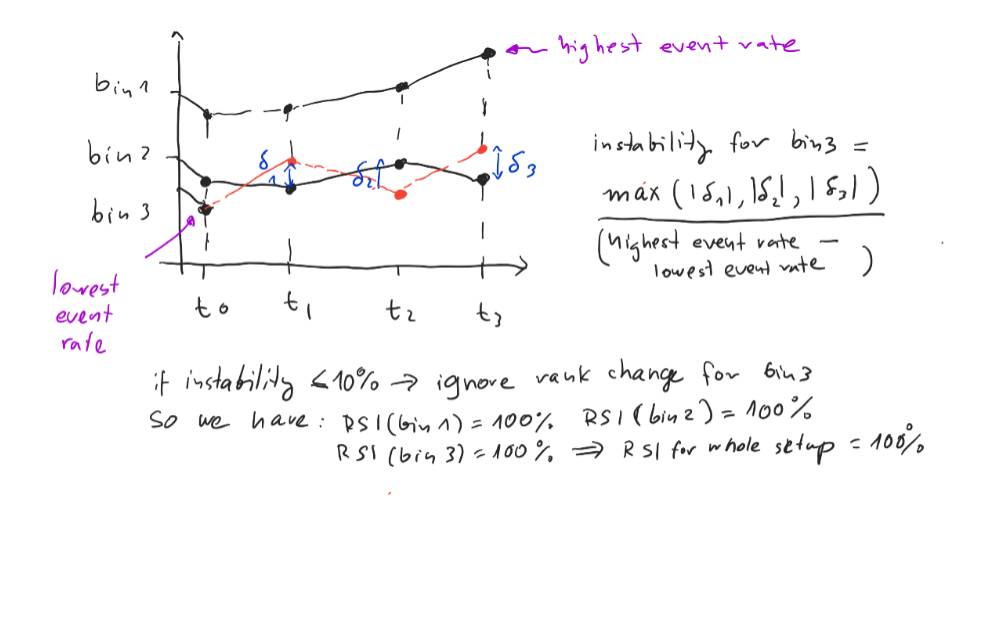

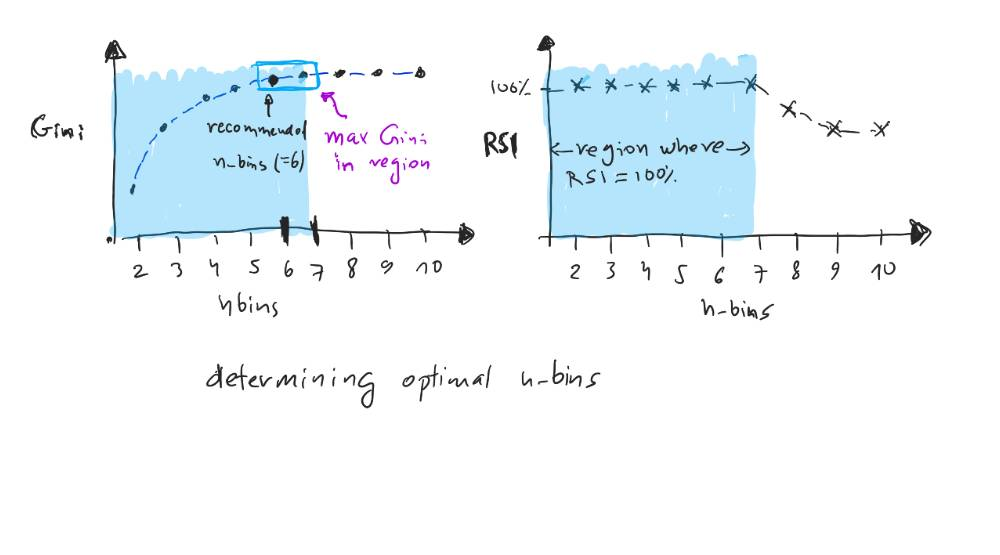

# Import packages

In [1]:
import time
import datetime
import operator
import math
import random
import numpy as np
import pandas as pd

# import cx_Oracle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import pickle
import gc
# check your tqdm version if import fails
from tqdm.notebook import tqdm

# import tkinter

import sys

sys.path.insert(0, "..")
import scoring
print (scoring.__version__)

# my own stuff:

from matplotlib.ticker import FuncFormatter
from matplotlib import gridspec

from sklearn.metrics import roc_auc_score

from ipywidgets import FloatProgress

'''
import category_encoders as ce

import optuna as optuna
print('optuna', optuna.__version__)  

from optuna.pruners import SuccessiveHalvingPruner
from optuna.pruners import NopPruner
from optuna.samplers import TPESampler
'''

import lightgbm as lgb
print ('lightgbm', lgb.__version__)

import graphviz

import json

import warnings

from sklearn.tree import DecisionTreeClassifier

0.7.3
optuna 1.1.0
lightgbm 2.3.1


Set general technical parameters and paths.

In [2]:
sns.set()
%matplotlib inline
%config InlineBackend.close_figures=True
from IPython.display import display, Markdown, HTML
pd.options.display.max_columns = None
pd.options.display.max_rows = 15


prefix = 'D:/Kamil/WORK/HCI/Phillipines/ZeroBOD/'
output_folder = prefix + 'documentation'

if not os.path.exists(output_folder): os.makedirs(output_folder)
if not os.path.exists(output_folder+'/performance'): os.makedirs(output_folder+'/performance')
if not os.path.exists(output_folder+'/predictors'): os.makedirs(output_folder+'/predictors')
if not os.path.exists(output_folder+'/stability'): os.makedirs(output_folder+'/stability')
if not os.path.exists(output_folder+'/stability/bins'): os.makedirs(output_folder+'/stability/bins')
if not os.path.exists(output_folder+'/stability_short'): os.makedirs(output_folder+'/stability_short')
if not os.path.exists(output_folder+'/analysis'): os.makedirs(output_folder+'/analysis')
if not os.path.exists(output_folder+'/model'): os.makedirs(output_folder+'/model')
if not os.path.exists(output_folder+'/model/lgbm'): os.makedirs(output_folder+'/model/lgbm')    
if not os.path.exists(output_folder+'/nan_share'): os.makedirs(output_folder+'/nan_share')
scoring.check_version('0.7.3')

# Load Utils

In [3]:
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(round(100 * y, 2))
    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'
    
formatter = FuncFormatter(to_percent)

In [4]:
def WOE(x, target_mean, smooth_coef = 0.001):
        v = 0
        logodd = math.log( (x + smooth_coef) /((1-x) + smooth_coef) )
        modifier = math.log( (target_mean + smooth_coef) / ((1-target_mean) + smooth_coef) )
        v = -1.0*round(logodd - modifier,4)
        return v

In [5]:
def LGBM_trained_booster(param, lgbtrain , lgbvalid , results, METRIC, delta_METRIC, ROUNDS, 
                         _callback, _early_stopping_rounds = 50 ):
    
    _evals  = [lgbtrain,lgbvalid]
    _valid_names = ['TRAIN','VALID']
 
    bst = lgb.train(param, lgbtrain, valid_sets = _evals, valid_names = _valid_names, evals_result=results,\
                    verbose_eval = 0, early_stopping_rounds =_early_stopping_rounds, callbacks = _callback)
        
    train_METRIC = bst.__dict__['best_score'][_valid_names[0]][param['metric']]
    valid_METRIC = bst.__dict__['best_score'][_valid_names[1]][param['metric']]
 
    METRIC[0] = valid_METRIC       
    delta_METRIC[0] = (train_METRIC - valid_METRIC)/valid_METRIC
    ROUNDS[0] = bst.__dict__['best_iteration']
    
    return bst

# Load data

In [7]:
from scoring import db

data = db.read_csv(
    prefix +'source/'+'base_0BOD.csv',
    sep=",",
    decimal=".",
    optimize_types=True,
    encoding="utf-8",
    low_memory=False,
    keep_default_na=False,
    na_values=[""],
)

data = data[:-1]

data = data.reset_index(drop = False)
data.rename(columns = {'index':'ID'}, inplace = True)

print("Data loaded on", datetime.datetime.fromtimestamp(time.time()).strftime("%Y-%m-%d %H:%M:%S"))

Data loaded on 2020-03-24 03:48:48


In [8]:
print("Number of rows:", data.shape[0])
print("Number of columns:", data.shape[1])

Number of rows: 615528
Number of columns: 30


## Metadata definitions
Assigning ID column, target column, time column and month column. The month column don't have to exist in the dataset, it will be created later in this workflow.

In [13]:
### THESE COLUMNS MUST BE INCLUDED IN THE DATA SET ###
# name of the target column
col_target = 'N6PD30'
# name of the time column
col_time = 'APPL_DATE'
### THESE COLUMNS DON'T HAVE TO BE INCLUDED IN THE DATA SET AND ARE CREATED AUTOMATICALLY LATER ###
# name of the base column
col_base = "BASE"
# name of the month column
col_month = 'MONTH'
# name of the day column
col_day = 'DAY'
col_week = 'WEEK'
# name of the weight column - CURRENTLY COMMENTED OUT BECAUSE OF REASONS MENTIONED LATER
col_weight = 'WT'
# name of the reject column - only use if exists in your data, used for reject inference analysis
#col_reject = "REJECTED"
col_score = "SCORE"

In [14]:
from scoring import doctools

documentation = doctools.ProjectParameters()

In [15]:
documentation.targets = [(col_target, col_base)]
documentation.time_variable = col_month
documentation.rowid_variable = "ID"

In [16]:
pd.DataFrame.from_records(
    [
        ["col_time", col_time],
        ["col_month", col_month],
        ["col_day", col_day],
        ["col_target", col_target],
        ["col_base", col_base],
    ]
).to_csv(output_folder + "/model/metadata.csv", index=0, header=None)

data[col_target] = data[col_target].astype(np.float)

In [17]:
if col_base not in data:
    data[col_base] = 0
    data.loc[data[col_target] == 0, col_base] = 1
    data.loc[data[col_target] == 1, col_base] = 1
    print("Column", col_base, "added/modified. Number of columns:", data.shape[1])
else:
    print("Column", col_base, "already exists.")

Column BASE added/modified. Number of columns: 31


In [18]:
if col_weight not in data:
    data[col_weight] = 1
    print('Column',col_weight,'added/modified. Number of columns:',data.shape[1])
else:
    print('Column',col_weight,'already exists.')

Column WT added/modified. Number of columns: 32


In [19]:
dtime_input_format = '%d-%b-%y'

In [20]:
data[col_day] = pd.to_numeric(pd.to_datetime(data[col_time], format=dtime_input_format).dt.strftime("%Y%m%d"))
data[col_week] = pd.to_numeric(pd.to_datetime(data[col_time], format=dtime_input_format).dt.strftime("%V"))
data[col_month] = data[col_day].apply(lambda x: math.trunc(x / 100))
data['month_second_half'] = data[col_time].apply(lambda x: 1 if int(x[0:2]) > 15 else 0)
data[col_month + '_half'] = data.apply(lambda row: str(row[col_month]) + '_' + str(row['month_second_half']), axis =1 )
print("Columns", col_day, "and", col_month, "added/modified. Number of columns:", data.shape[1])

Columns DAY and MONTH added/modified. Number of columns: 37


In [21]:
data.head(50)

ID  SKP_CREDIT_CASE  APPL_DATE         APPL_DAY  APPL_HOUR  \
0    0         74760000  01-SEP-18          WEEKEND       13.0   
1    1         74820000  02-SEP-18          WEEKEND       14.0   
2    2         74960000  04-SEP-18  WORKING_DAY_TUE       19.0   
3    3         75030000  05-SEP-18  WORKING_DAY_WED       10.0   
4    4         75160000  07-SEP-18  WORKING_DAY_FRI       12.0   
..  ..              ...        ...              ...        ...   
45  45         79990000  02-DEC-18          WEEKEND       10.0   
46  46         80090000  04-DEC-18  WORKING_DAY_TUE       16.0   
47  47         80140000  05-DEC-18  WORKING_DAY_WED       16.0   
48  48         80190000  06-DEC-18  WORKING_DAY_THU       14.0   
49  49         80240000  07-DEC-18  WORKING_DAY_FRI       20.0   

    APPL_HOUR_NON_WD  APPL_HOUR_WD SEX  AGE_YEARS FAMILYSTATE  \
0               13.0           NaN   F       48.0     MARRIED   
1               14.0           NaN   F       44.0     MARRIED   
2                NaN          19.0   F       49.0     MARRIED   
3                NaN          10.0   F       42.0     MARRIED   
4                NaN          12.0   F       24.0      SINGLE   
..               ...           ...  ..        ...         ...   
45              10.0           NaN   M       33.0      SINGLE   
46               NaN          16.0   F       43.0      SINGLE   
47               NaN          16.0   F       25.0      SINGLE   
48               NaN          14.0   M       33.0      SINGLE   
49               NaN          20.0   F       21.0      SINGLE   

    DEPENDENTNUMBER AGE_DEPNUM FAMILYSTATE_DEPNUM               INCOMETYPE  \
0               3.0       48&3          MARRIED&3  PRIVATE_SECTOR_EMPLOYEE   
1               0.0       44&0          MARRIED&0  PRIVATE_SECTOR_EMPLOYEE   
2               2.0       49&2          MARRIED&2             SELFEMPLOYED   
3               0.0       42&0          MARRIED&0  PRIVATE_SECTOR_EMPLOYEE   
4               0.0       24&0           SINGLE&0      GOVERNMENT_EMPLOYEE   
..              ...        ...                ...                      ...   
45              0.0       33&0           SINGLE&0  PRIVATE_SECTOR_EMPLOYEE   
46              1.0       43&1           SINGLE&1      PERSON_IN_HOUSEHOLD   
47              1.0       25&1           SINGLE&1  PRIVATE_SECTOR_EMPLOYEE   
48              0.0       33&0           SINGLE&0  PRIVATE_SECTOR_EMPLOYEE   
49              0.0       21&0           SINGLE&0      GOVERNMENT_EMPLOYEE   

    EMPLOYMENT_DURATION_YEARS        INCOMETYPE_EMPLYEARS  \
0                        20.0  PRIVATE_SECTOR_EMPLOYEE&20   
1                         2.0   PRIVATE_SECTOR_EMPLOYEE&2   
2                         1.0              SELFEMPLOYED&1   
3                         0.0   PRIVATE_SECTOR_EMPLOYEE&0   
4                         2.0       GOVERNMENT_EMPLOYEE&2   
..                        ...                         ...   
45                        1.0   PRIVATE_SECTOR_EMPLOYEE&1   
46                        NaN     PERSON_IN_HOUSEHOLD&N/A   
47                        1.0   PRIVATE_SECTOR_EMPLOYEE&1   
48                        0.0   PRIVATE_SECTOR_EMPLOYEE&0   
49                        1.0       GOVERNMENT_EMPLOYEE&1   

              HOUSETYPE  MAINOCCUPATIONINCOME   EMPLOYMENT_INDUSTRY REMITTER  \
0                 OWNED               16800.0             EDUCATION       NO   
1                RENTED               12000.0     HOUSEHOLD_SERVICE       NO   
2                 OWNED               12000.0              SERVICES       NO   
3                 OWNED               16000.0  MANUFACTURING_PROCES       NO   
4   LIVING_WITH_PARENTS               14000.0            GOVERNMENT       NO   
..                  ...                   ...                   ...      ...   
45                OWNED                8000.0            COMMERCIAL       NO   
46                OWNED                   0.0                   NaN      YES   
47                OWNED               14

# Rewieght ( resample)

In [23]:
HC0=data[data['PROCESS_GROUP']=='PURE_POP'].sample(frac=100/3.8, replace=True, random_state=42)
HC1=data[data['PROCESS_GROUP']=='FANTOMAS_HC_HISTREJECTED'].sample(frac=100/30, replace=True, random_state=42)
HC2=data[data['PROCESS_GROUP']=='FANTOMAS_HIT_HC_DAYS'].sample(frac=100/8, replace=True, random_state=42)
HC3 = data[data['PROCESS_GROUP']=='APPROVED']

data  = pd.concat([HC0,HC1,HC2,HC3], axis = 0)
data = data.reset_index(drop = True)

# Predictors

In [28]:
cols =\
[
'APPL_DAY', 'APPL_HOUR','APPL_HOUR_NON_WD', 'APPL_HOUR_WD', 
'AGE_YEARS', 'SEX', 'FAMILYSTATE','DEPENDENTNUMBER', 'HOUSETYPE', 
'INCOMETYPE', 'MAINOCCUPATIONINCOME','EMPLOYMENT_INDUSTRY', 'EMPLOYMENT_DURATION_YEARS', 
'PAYTYPE', 'REMITTANCE_AMOUNT', 'REMITTER', 'DOC_SCORE0', 'HC_HISTREJECTED','HC_DAYS'
]

MUST_HAVE = ['HC_HISTREJECTED', 'HC_DAYS']
important_minorities = ['HC_HISTREJECTED','HC_DAYS']

cols_pred = sorted(list(set(cols + MUST_HAVE + important_minorities)))

#MUST_HAVE = []
#important_minorities = []

In [29]:
cols_pred

['AGE_YEARS',
 'APPL_DAY',
 'APPL_HOUR',
 'APPL_HOUR_NON_WD',
 'APPL_HOUR_WD',
 'DEPENDENTNUMBER',
 'DOC_SCORE0',
 'EMPLOYMENT_DURATION_YEARS',
 'EMPLOYMENT_INDUSTRY',
 'FAMILYSTATE',
 'HC_DAYS',
 'HC_HISTREJECTED',
 'HOUSETYPE',
 'INCOMETYPE',
 'MAINOCCUPATIONINCOME',
 'PAYTYPE',
 'REMITTANCE_AMOUNT',
 'REMITTER',
 'SEX']

# Separate features into numercial and categorical

In [30]:
from scoring.data_manipulation import split_predictors_bytype

#cols_pred = list(pd.read_csv(r'demo_data\ExamplePredList8.CSV', sep = ',', decimal = '.', 
#                   encoding = 'windows-1251', low_memory = False, header = None)[0])

cols_pred, cols_pred_num, cols_pred_cat = split_predictors_bytype(data,
                                                                  pred_list=cols_pred,
                                                                  non_pred_list= [],
                                                                  optimize_types=True,
                                                                  convert_bool2int=True)

List of numerical predictors: [11]

AGE_YEARS                           float64
APPL_HOUR                           float64
APPL_HOUR_NON_WD                    float64
APPL_HOUR_WD                        float64
DEPENDENTNUMBER                     float64
DOC_SCORE0                          float64
EMPLOYMENT_DURATION_YEARS           float64
HC_DAYS                             float64
HC_HISTREJECTED                     float64
MAINOCCUPATIONINCOME                float64
REMITTANCE_AMOUNT                   float64

List of categorical predictors: [8]

APPL_DAY                            category
EMPLOYMENT_INDUSTRY                 category
FAMILYSTATE                         category
HOUSETYPE                           category
INCOMETYPE                          category
PAYTYPE                             category
REMITTER                            category
SEX                                 category


# Remove constant num features and highly hommogeneous categorical features

In [31]:
_threshold = 0.95

drop_list_num = []

for col in cols_pred_num:
    if col not in  MUST_HAVE + important_minorities :
        mask = (data[col] == data[col].mode()[0] )
        hommogenity = data[mask].shape[0]/ data.shape[0]
        if hommogenity >= _threshold:
            drop_list_num.append(col)  # more than 95%  of cases is just one value

drop_list_cat = []
for col in cols_pred_cat:
    if col not in  MUST_HAVE + important_minorities :
        hommogenity =data[col].value_counts().values.max()/data[col].value_counts().values.sum()
        if hommogenity >= _threshold:
            drop_list_cat.append(col)
            

In [32]:
display (drop_list_num)
display (drop_list_cat)

[]

[]

In [33]:
cols_pred_num = list( set(cols_pred_num) - set(drop_list_num))
cols_pred_cat = list( set(cols_pred_cat) - set(drop_list_cat))

print (len(cols_pred_num))
print (len(cols_pred_cat))

11
8


In [34]:
cols_pred = cols_pred_num + cols_pred_cat

Defaukt rate aceos  time (all data)

**Default rate in time**: Simple visualisation of observation count and default rate in time

# Data Split

In [35]:
#data['PROCESS_GROUP_COARSE'] = data['PROCESS_GROUP'].apply(lambda x : 'FANTOMAS_HC' \
#                               if x in ['FANTOMAS_HC_HISTREJECTED','FANTOMAS_HIT_HC_DAYS'] else x) 

from scoring.data_manipulation import data_sample_time_split

data["data_type"] = data_sample_time_split(
    data,
    time_column=col_month,
    splitting_points=[201809, 201812],
    sample_sizes=[[ 1   ],[ 0.5, 0.25 , 0.25 ],[ 1]],
    sample_names=[["hoot"], ["train", "valid", "test"], ["oot"]],
    stratify_by_columns=[col_month + '_half', col_target,'PROCESS_GROUP'],
    random_seed=42,
)

hoot    0 rows
train   498,339 rows
valid   249,170 rows
test    249,170 rows
oot     202,556 rows


Masks: boolean vectors corresponding to rows in the datasets. True if an row is observable and its data type belongs to given sample.

In [36]:
train_mask = (data["data_type"] == "train") & (data[col_base] == 1)
valid_mask = (data["data_type"] == "valid") & (data[col_base] == 1)
test_mask = (data["data_type"] == "test") & (data[col_base] == 1)
oot_mask = (data["data_type"] == "oot") & (data[col_base] == 1)
hoot_mask = (data["data_type"] == "hoot") & (data[col_base] == 1)
observable_mask = data[col_base] == 1

Add masks to _documentation_ object.

In [37]:
documentation.sample_dict = {
    "HOOT": hoot_mask,
    "Train": train_mask,
    "Valid": valid_mask,
    "Test": test_mask,
    "OOT": oot_mask,
    "Observable": observable_mask,
}

# WOE - Optimal grouping of variables and WOE creation

# split train dataset into two sets train_woe and valid_woe for the purpose of deriving the binning

In [38]:
from sklearn.model_selection import  train_test_split

train_woe, valid_woe = train_test_split(data[train_mask], test_size = 0.5, random_state = 42,\
                                stratify = data[train_mask][ [col_month, col_target,'PROCESS_GROUP'] ] )

train_woe = train_woe.reset_index(drop = True)
valid_woe = valid_woe.reset_index(drop = True)

In [39]:
display(train_woe[col_target].value_counts())
display(valid_woe[col_target].value_counts())

0.0    221758
1.0     27411
Name: N6PD30, dtype: int64

0.0    221760
1.0     27410
Name: N6PD30, dtype: int64

# Parameters of LGBM tree model used to do preliminary automatic binning

In [40]:
param = {
        
        # Objective and validation metric:
        'num_iterations': 1, 
        'objective': 'binary',
        'num_class':  1,
        'metric': 'auc',
       
        # Shrinkage parameter :
        'learning_rate': 1,
        
        # Weak learner (Oblivious tree):
        'boosting_type': 'gbdt',
        'max_depth': -1,
        'num_leaves': 2, 
        'min_data_in_leaf': 100,

        # Other:
        'seed': 42,
        'verbosity': -1,
        'use_missing' : '+',    #<-- do not auto-arrange nan. Keep it separate
        'device_type' : 'cpu',
        'n_jobs': -1

    }

# TIME DIMENSION

In [41]:
_col_month = col_month

In [42]:
valid_woe[_col_month].unique()

array([201811, 201809, 201810], dtype=int64)

# Automatic STABLE binning : split train set into train_woe and valid_woe. Use these sets  to find optimal number of bins by increasing this as a hyperparameter ( LGBM on train_woe then validate on valid_woe)

FloatProgress(value=0.0, description='vars', max=19.0)

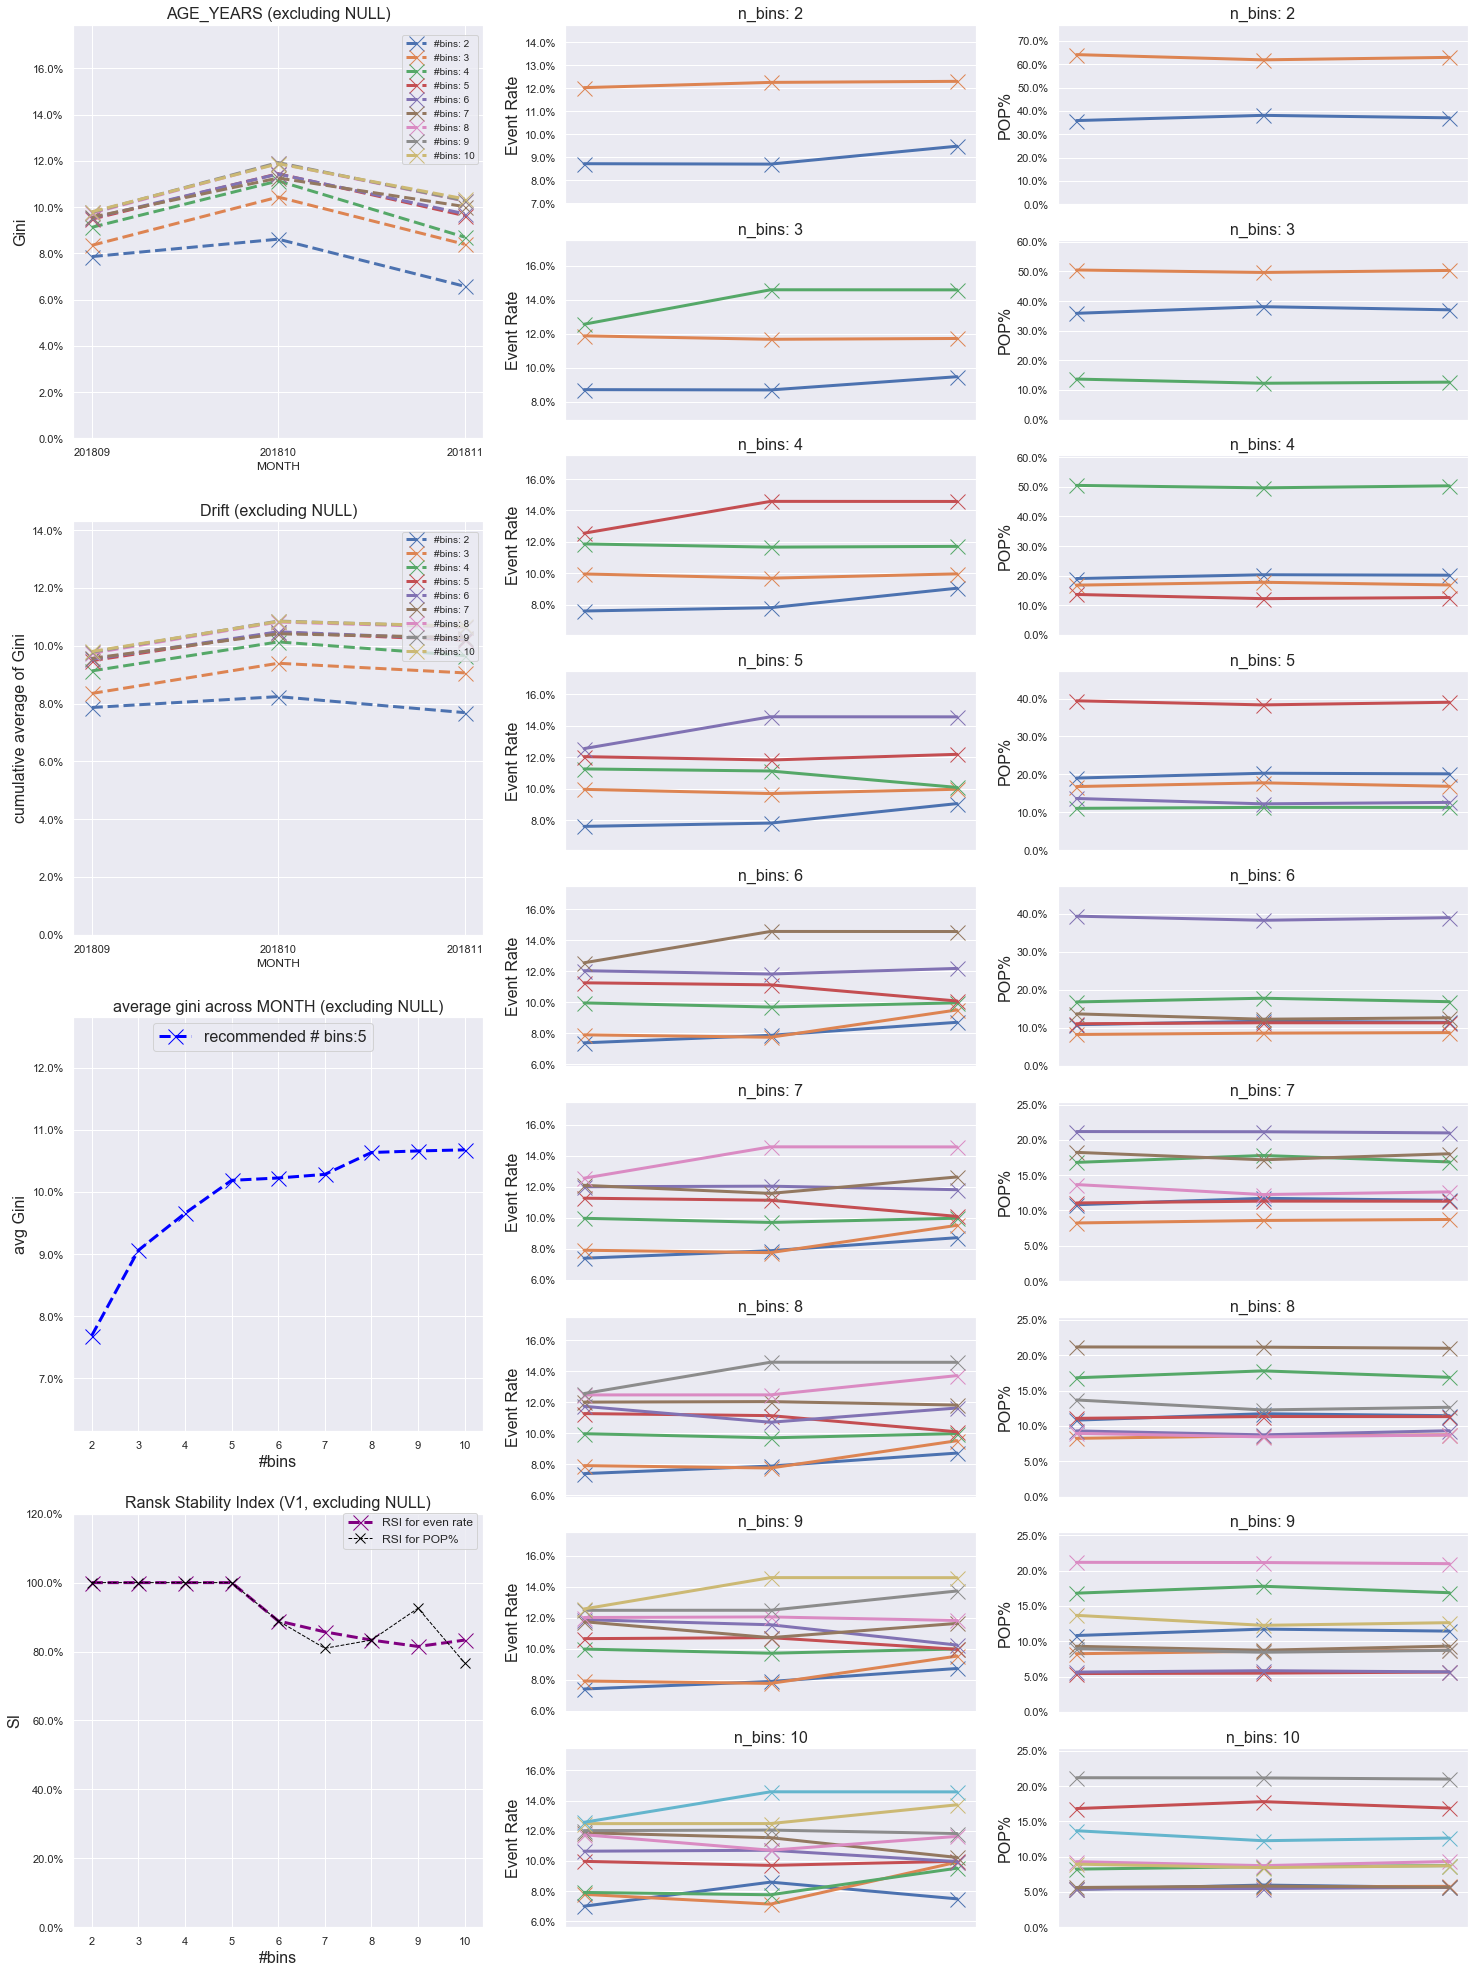

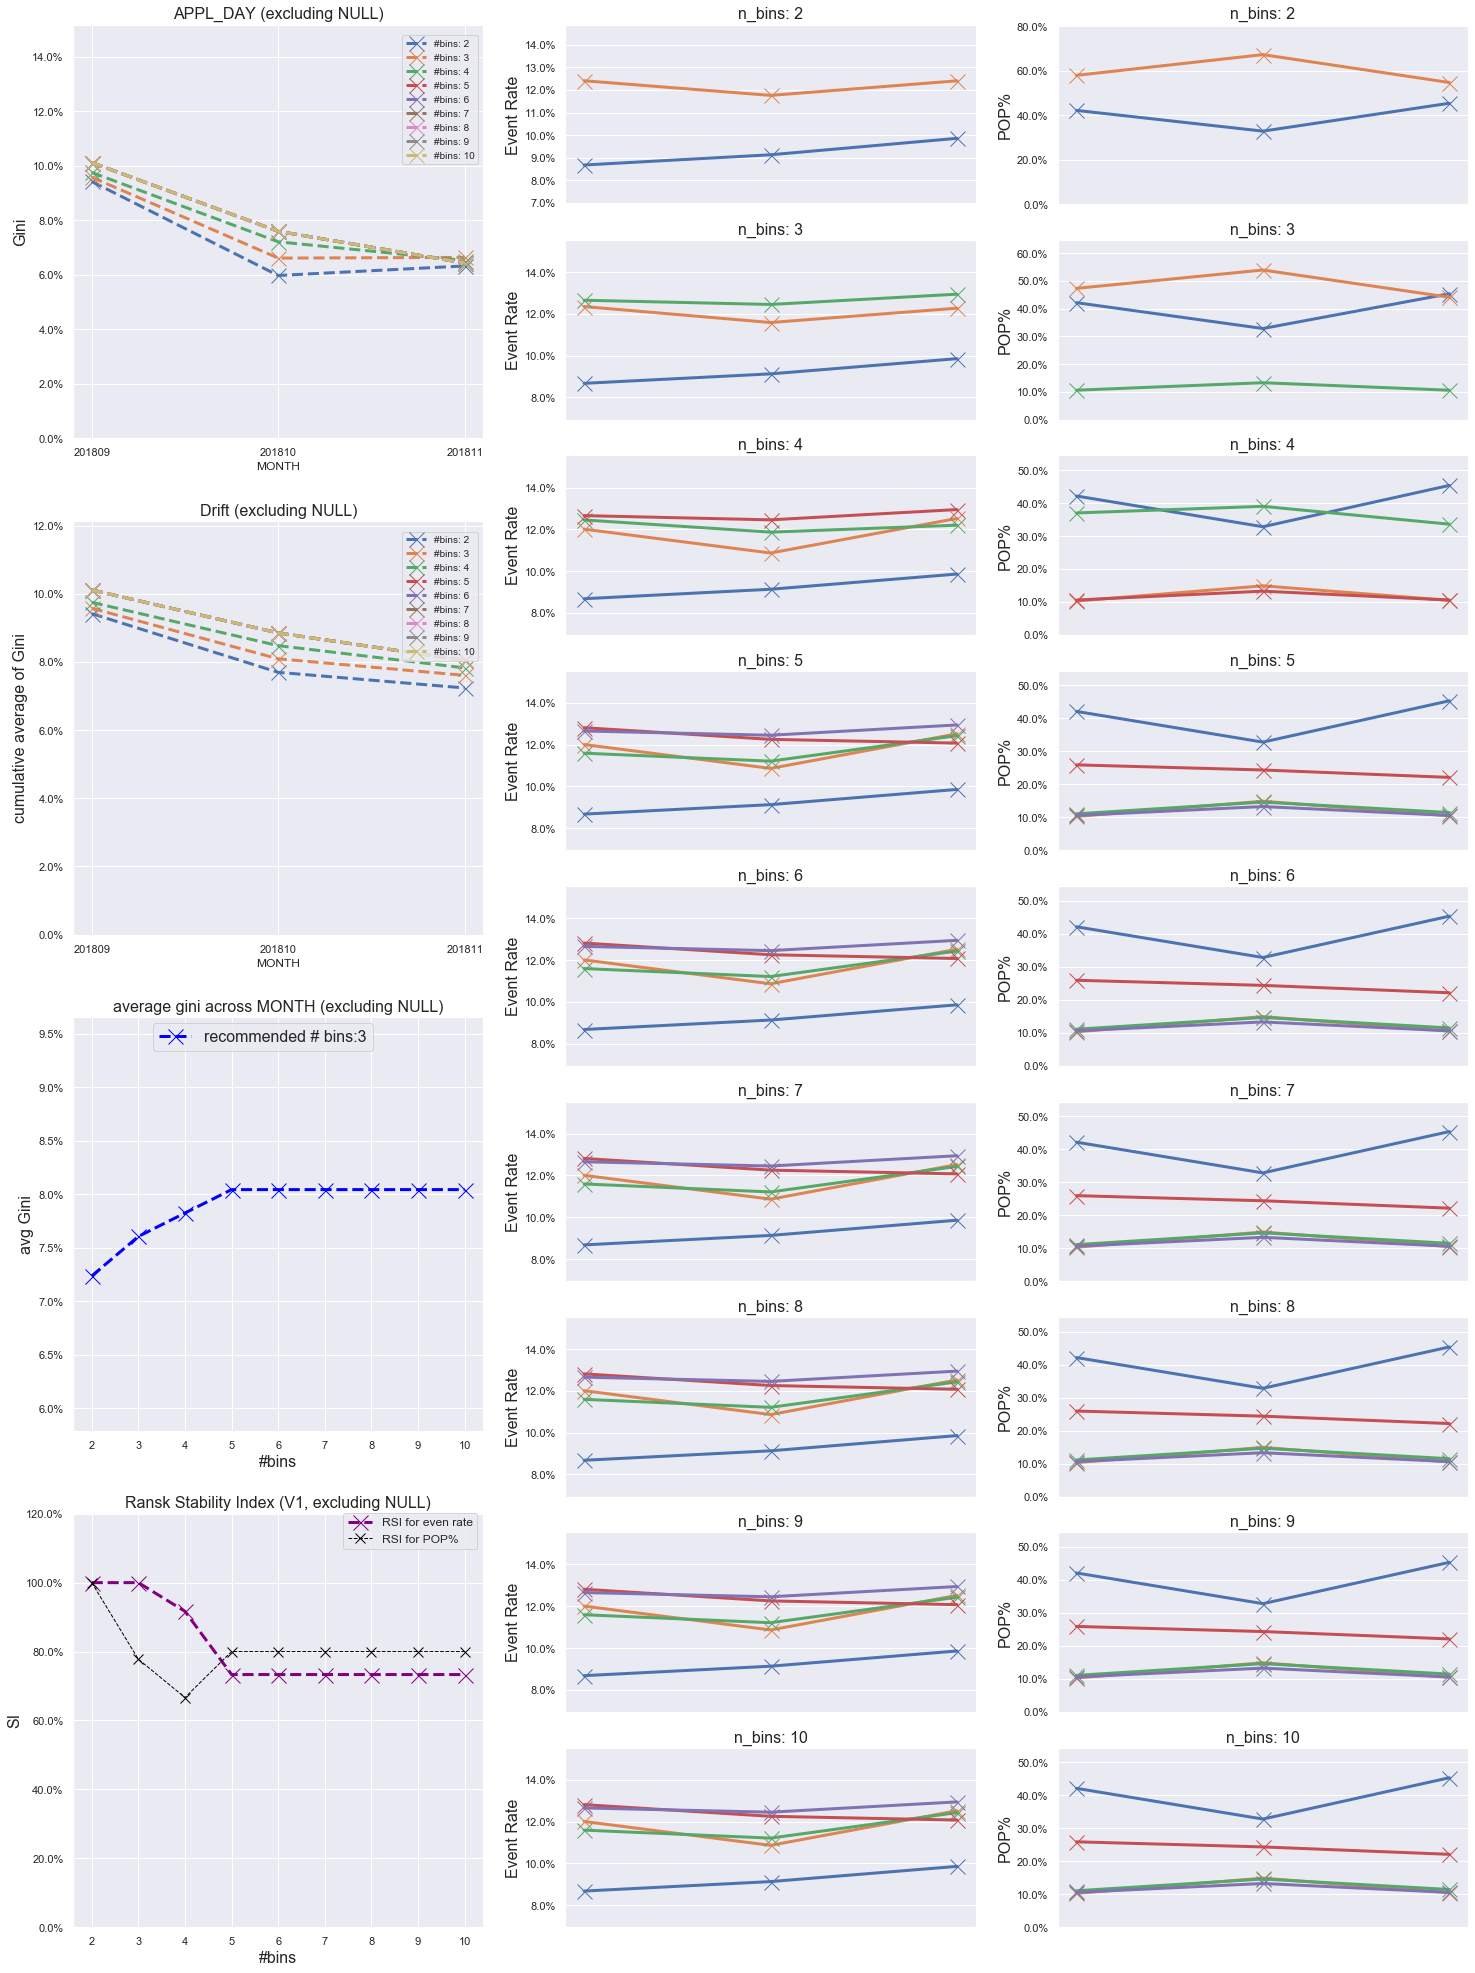

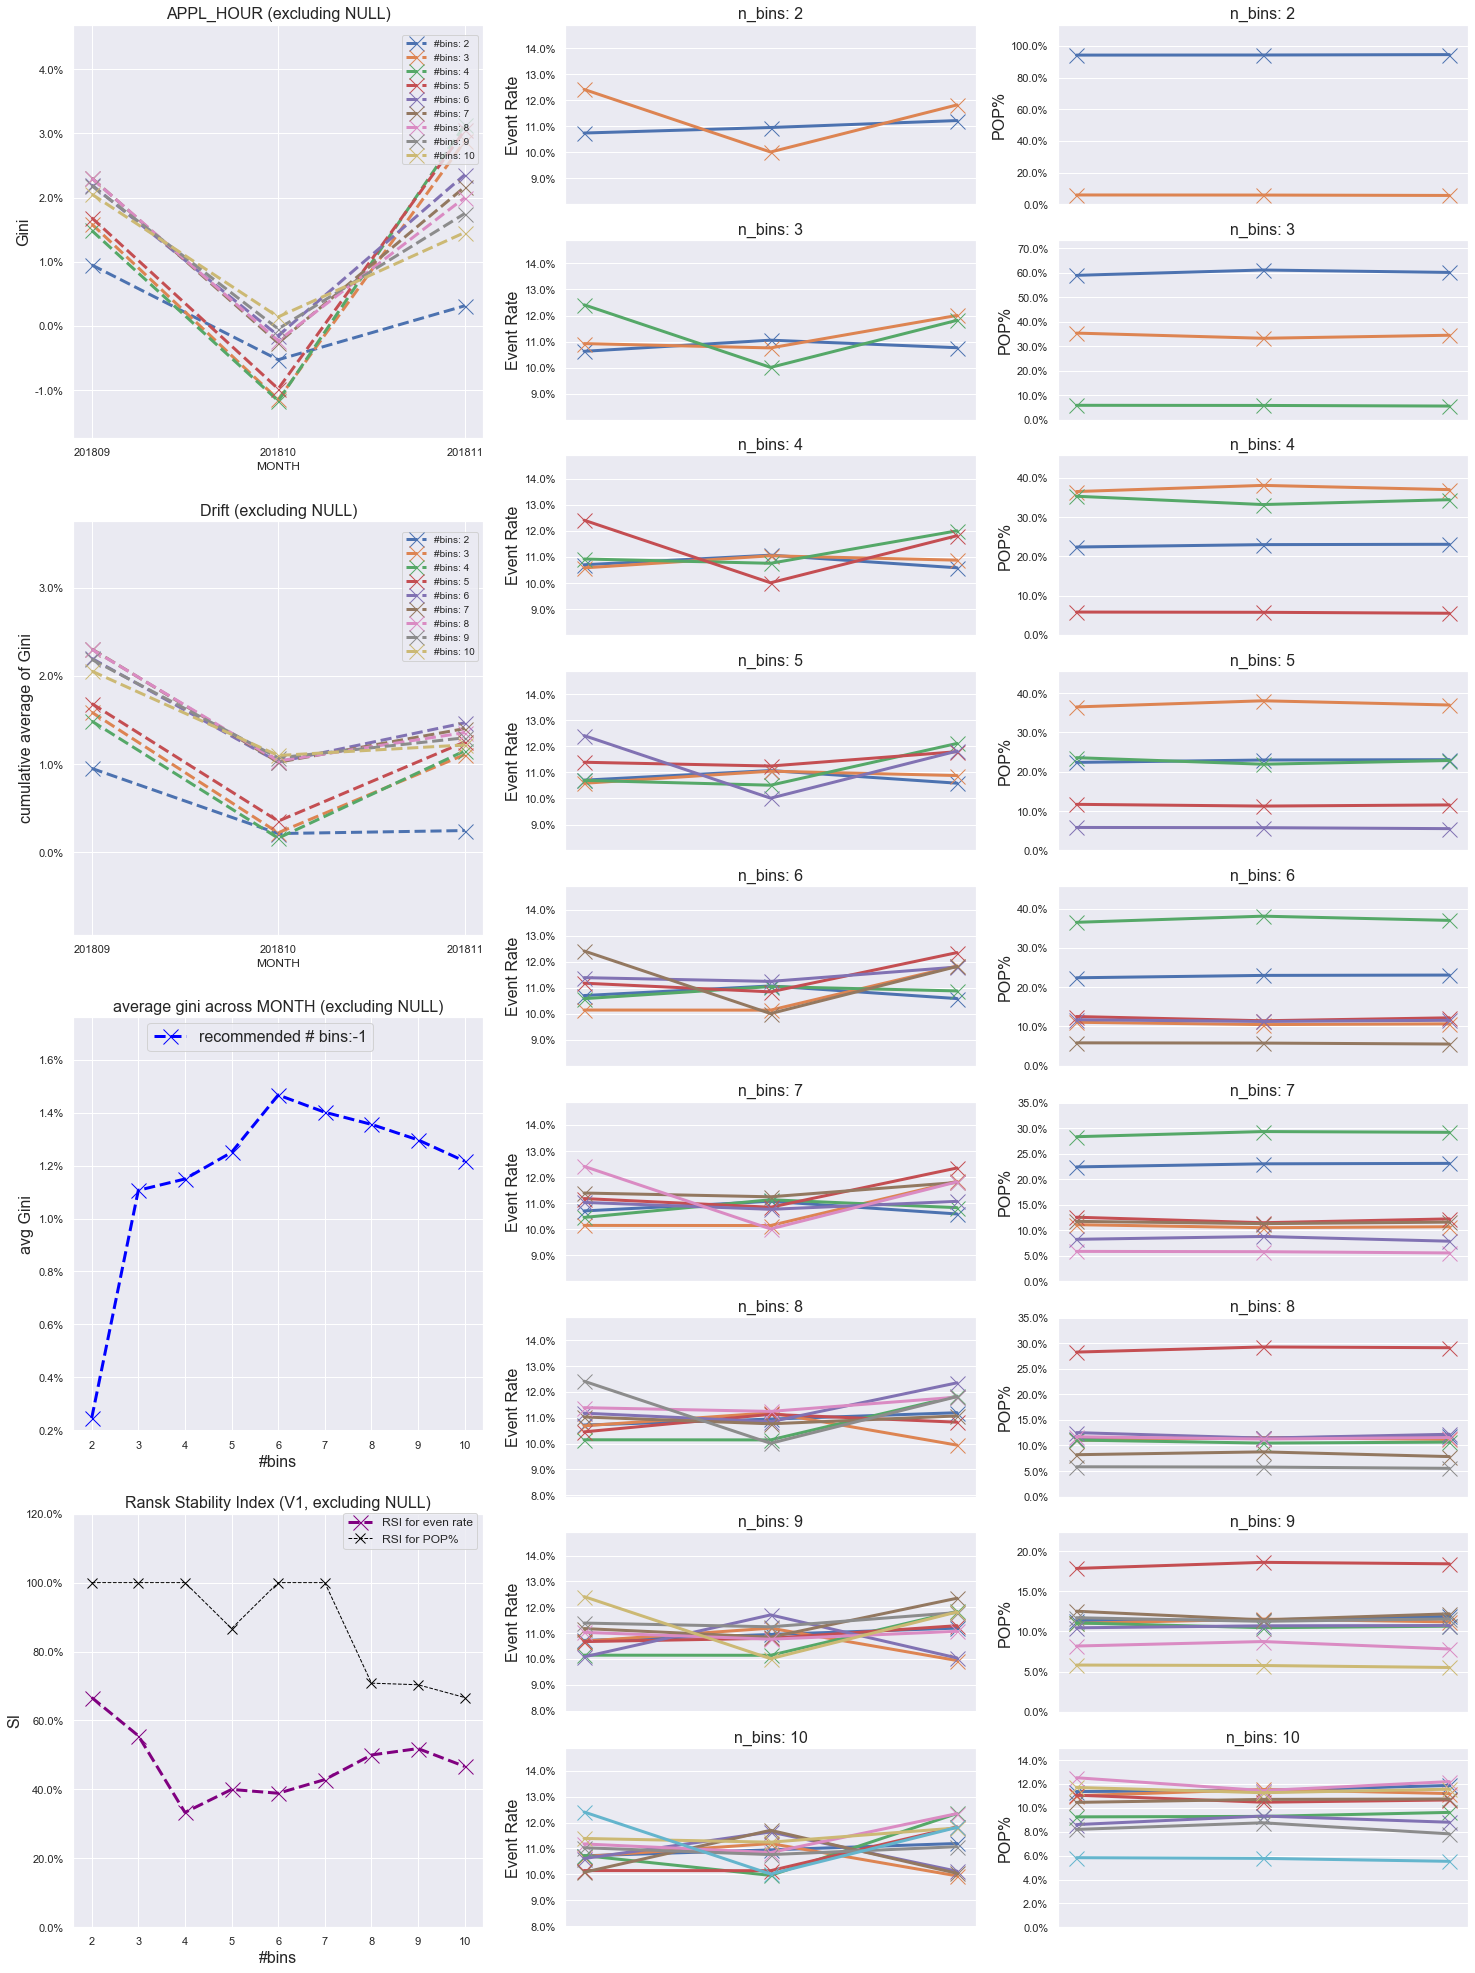

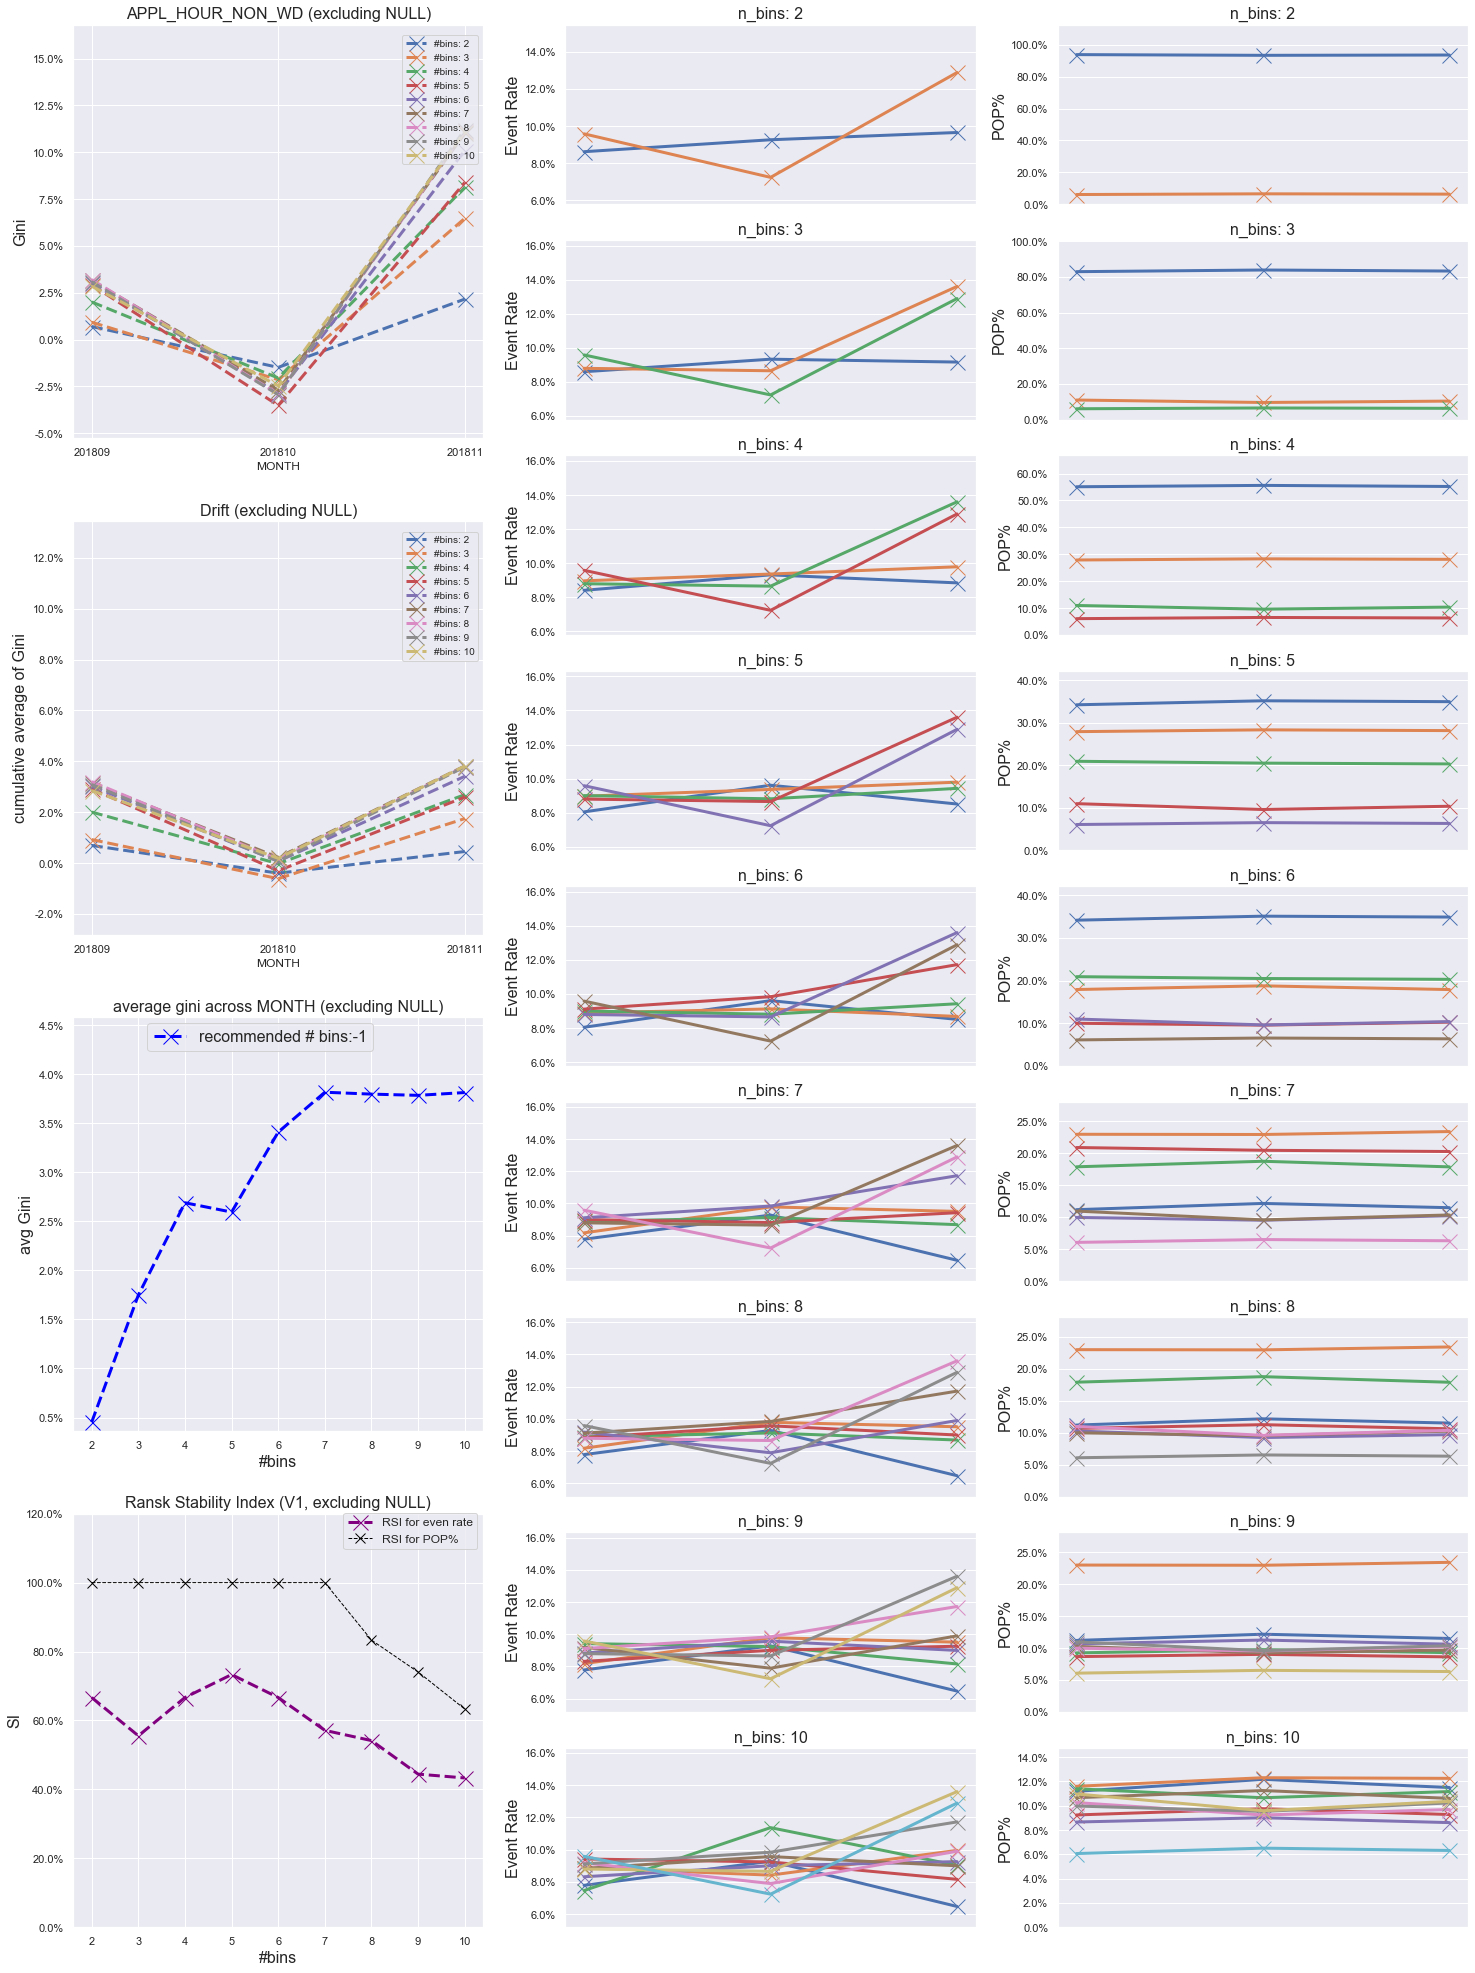

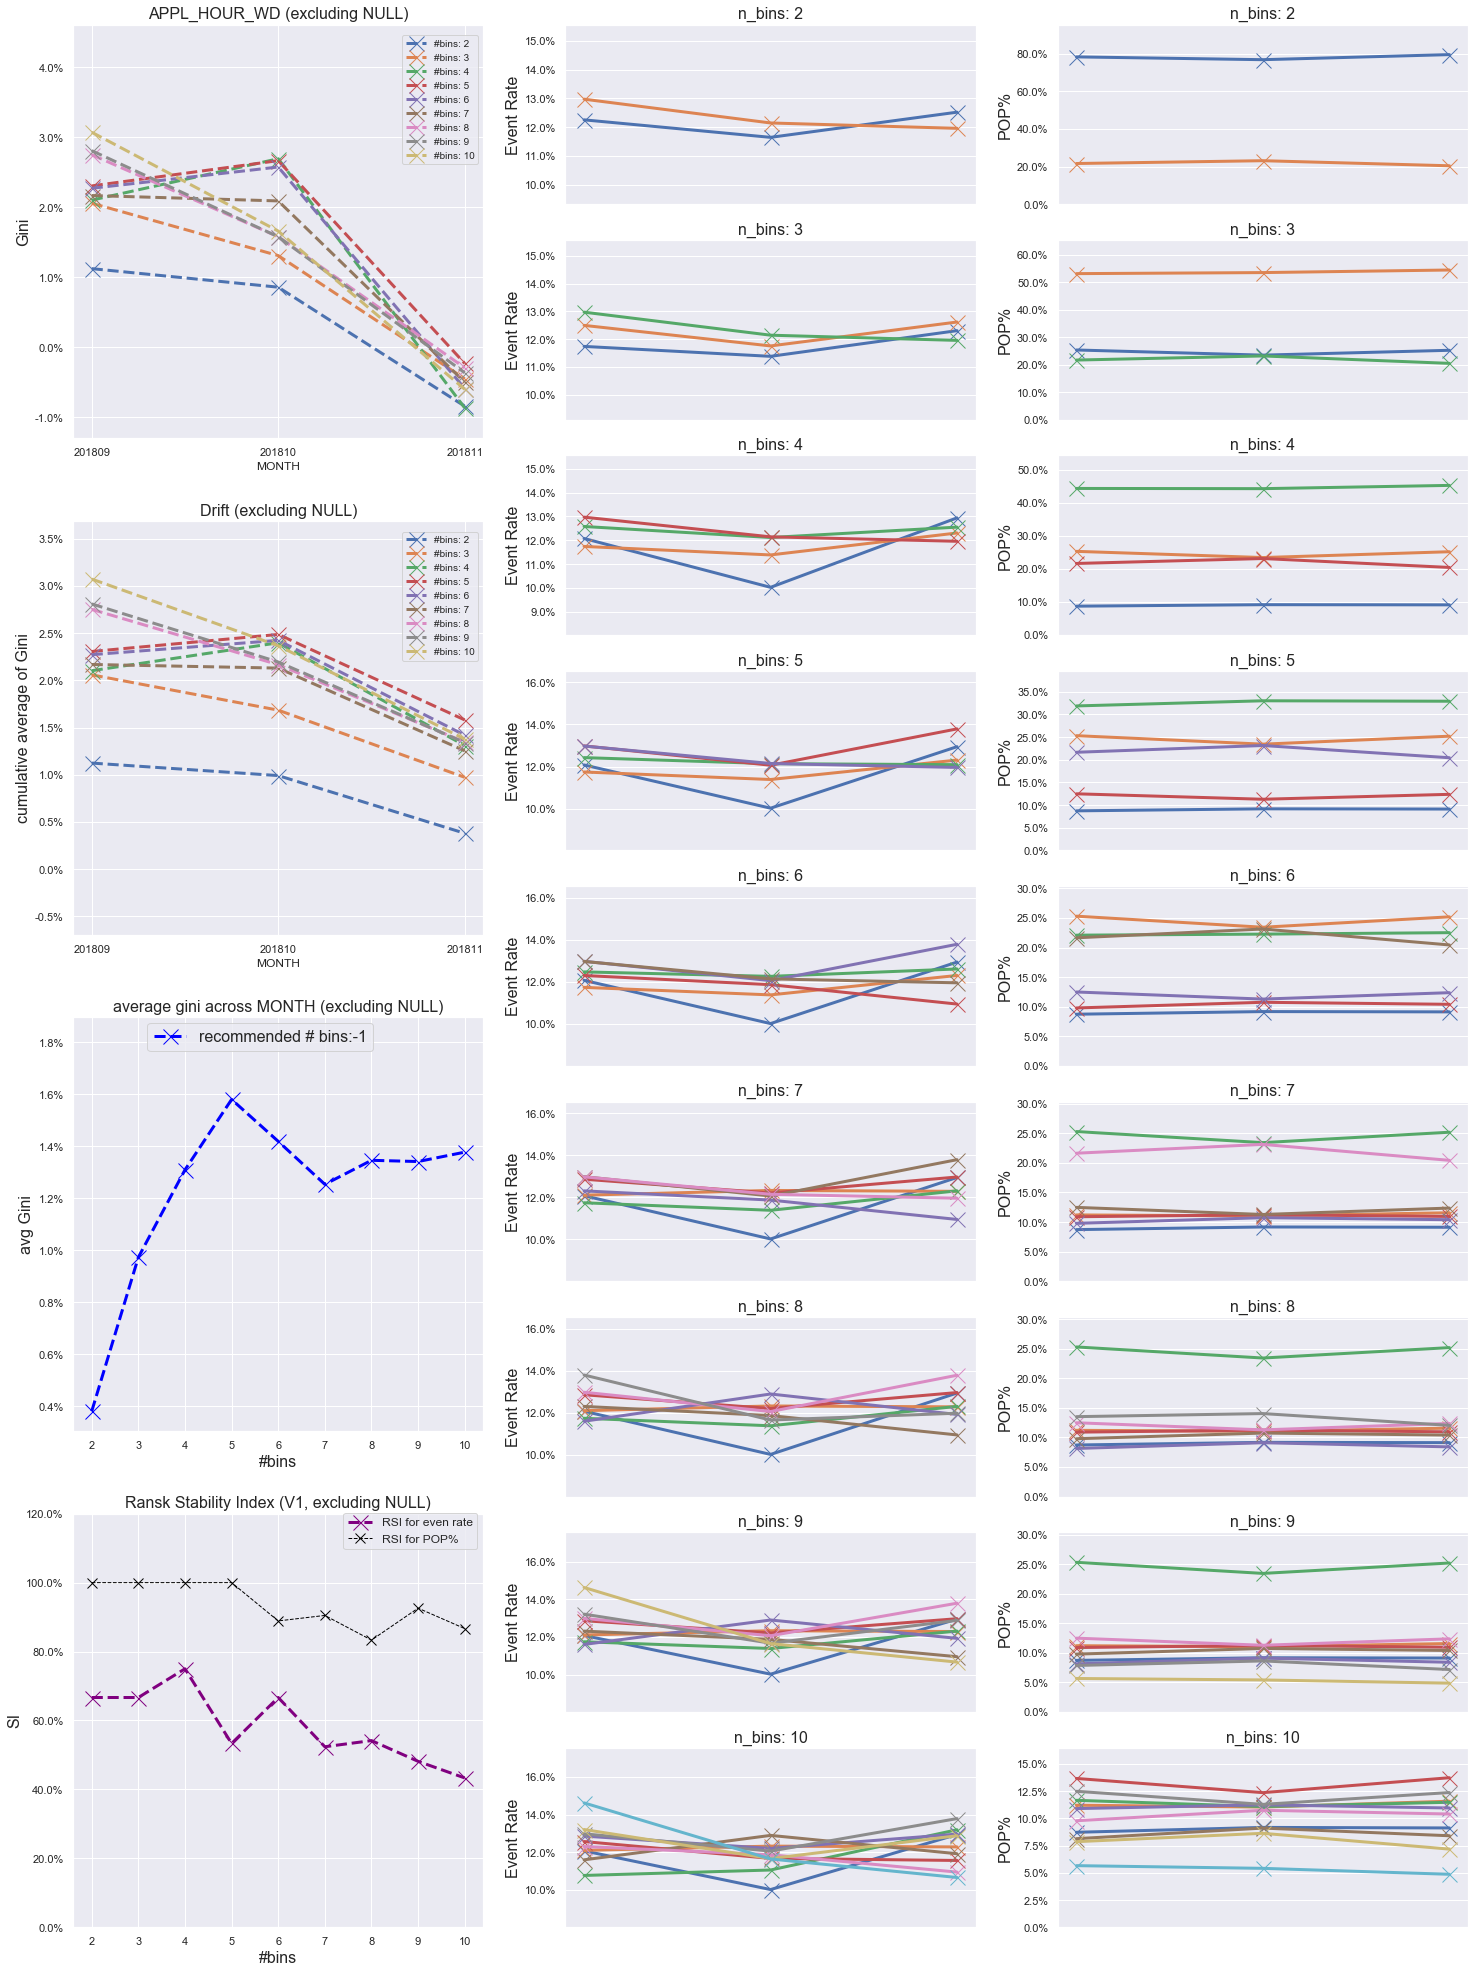

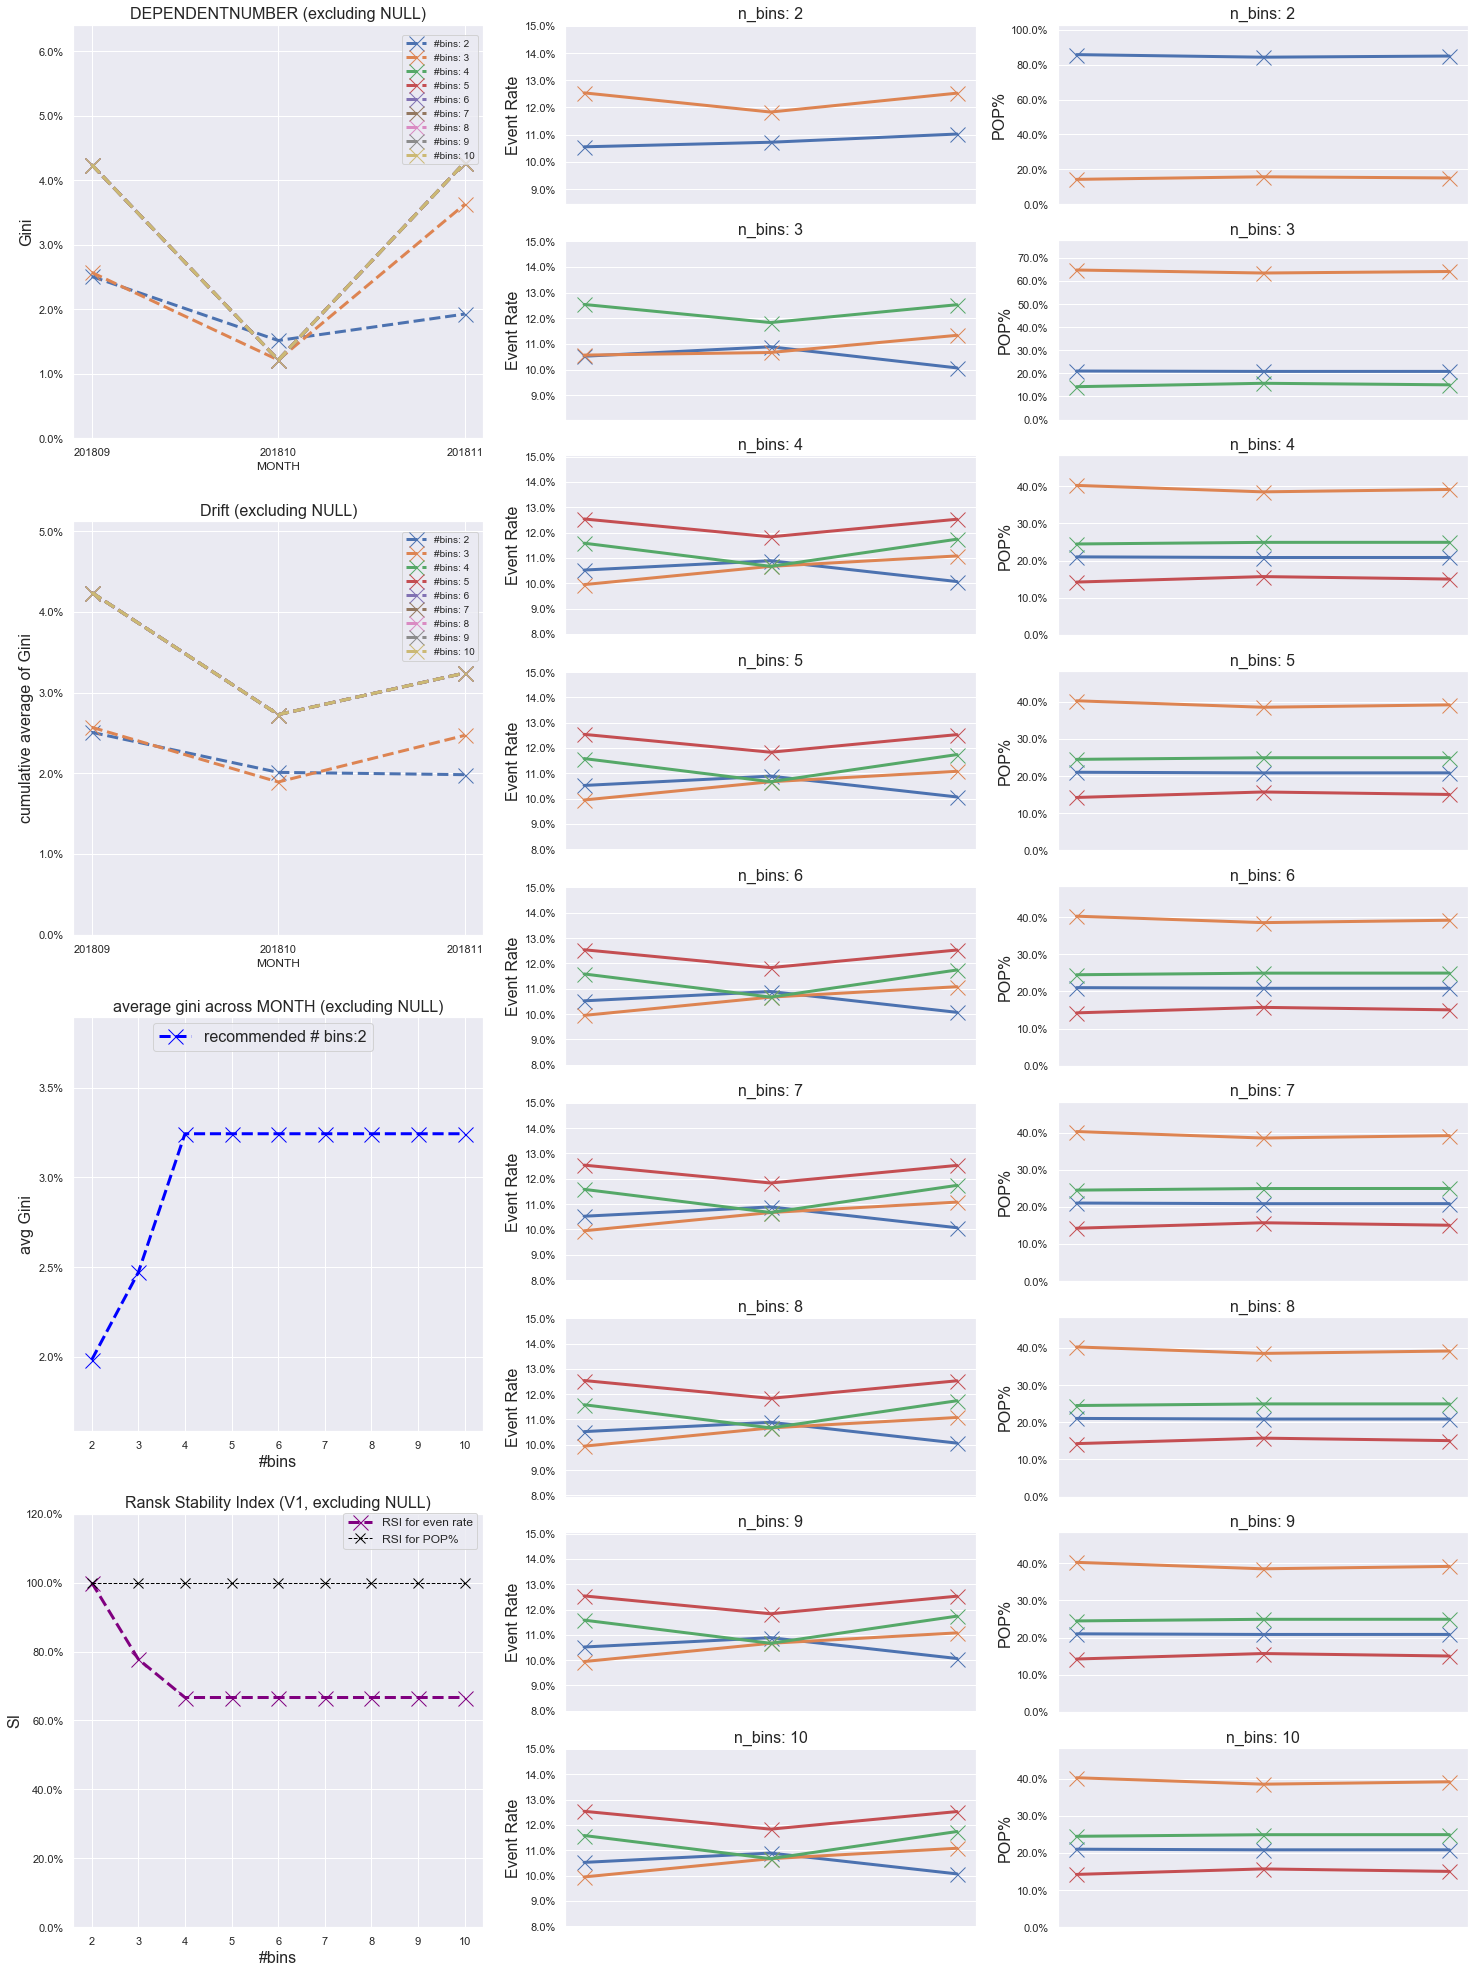

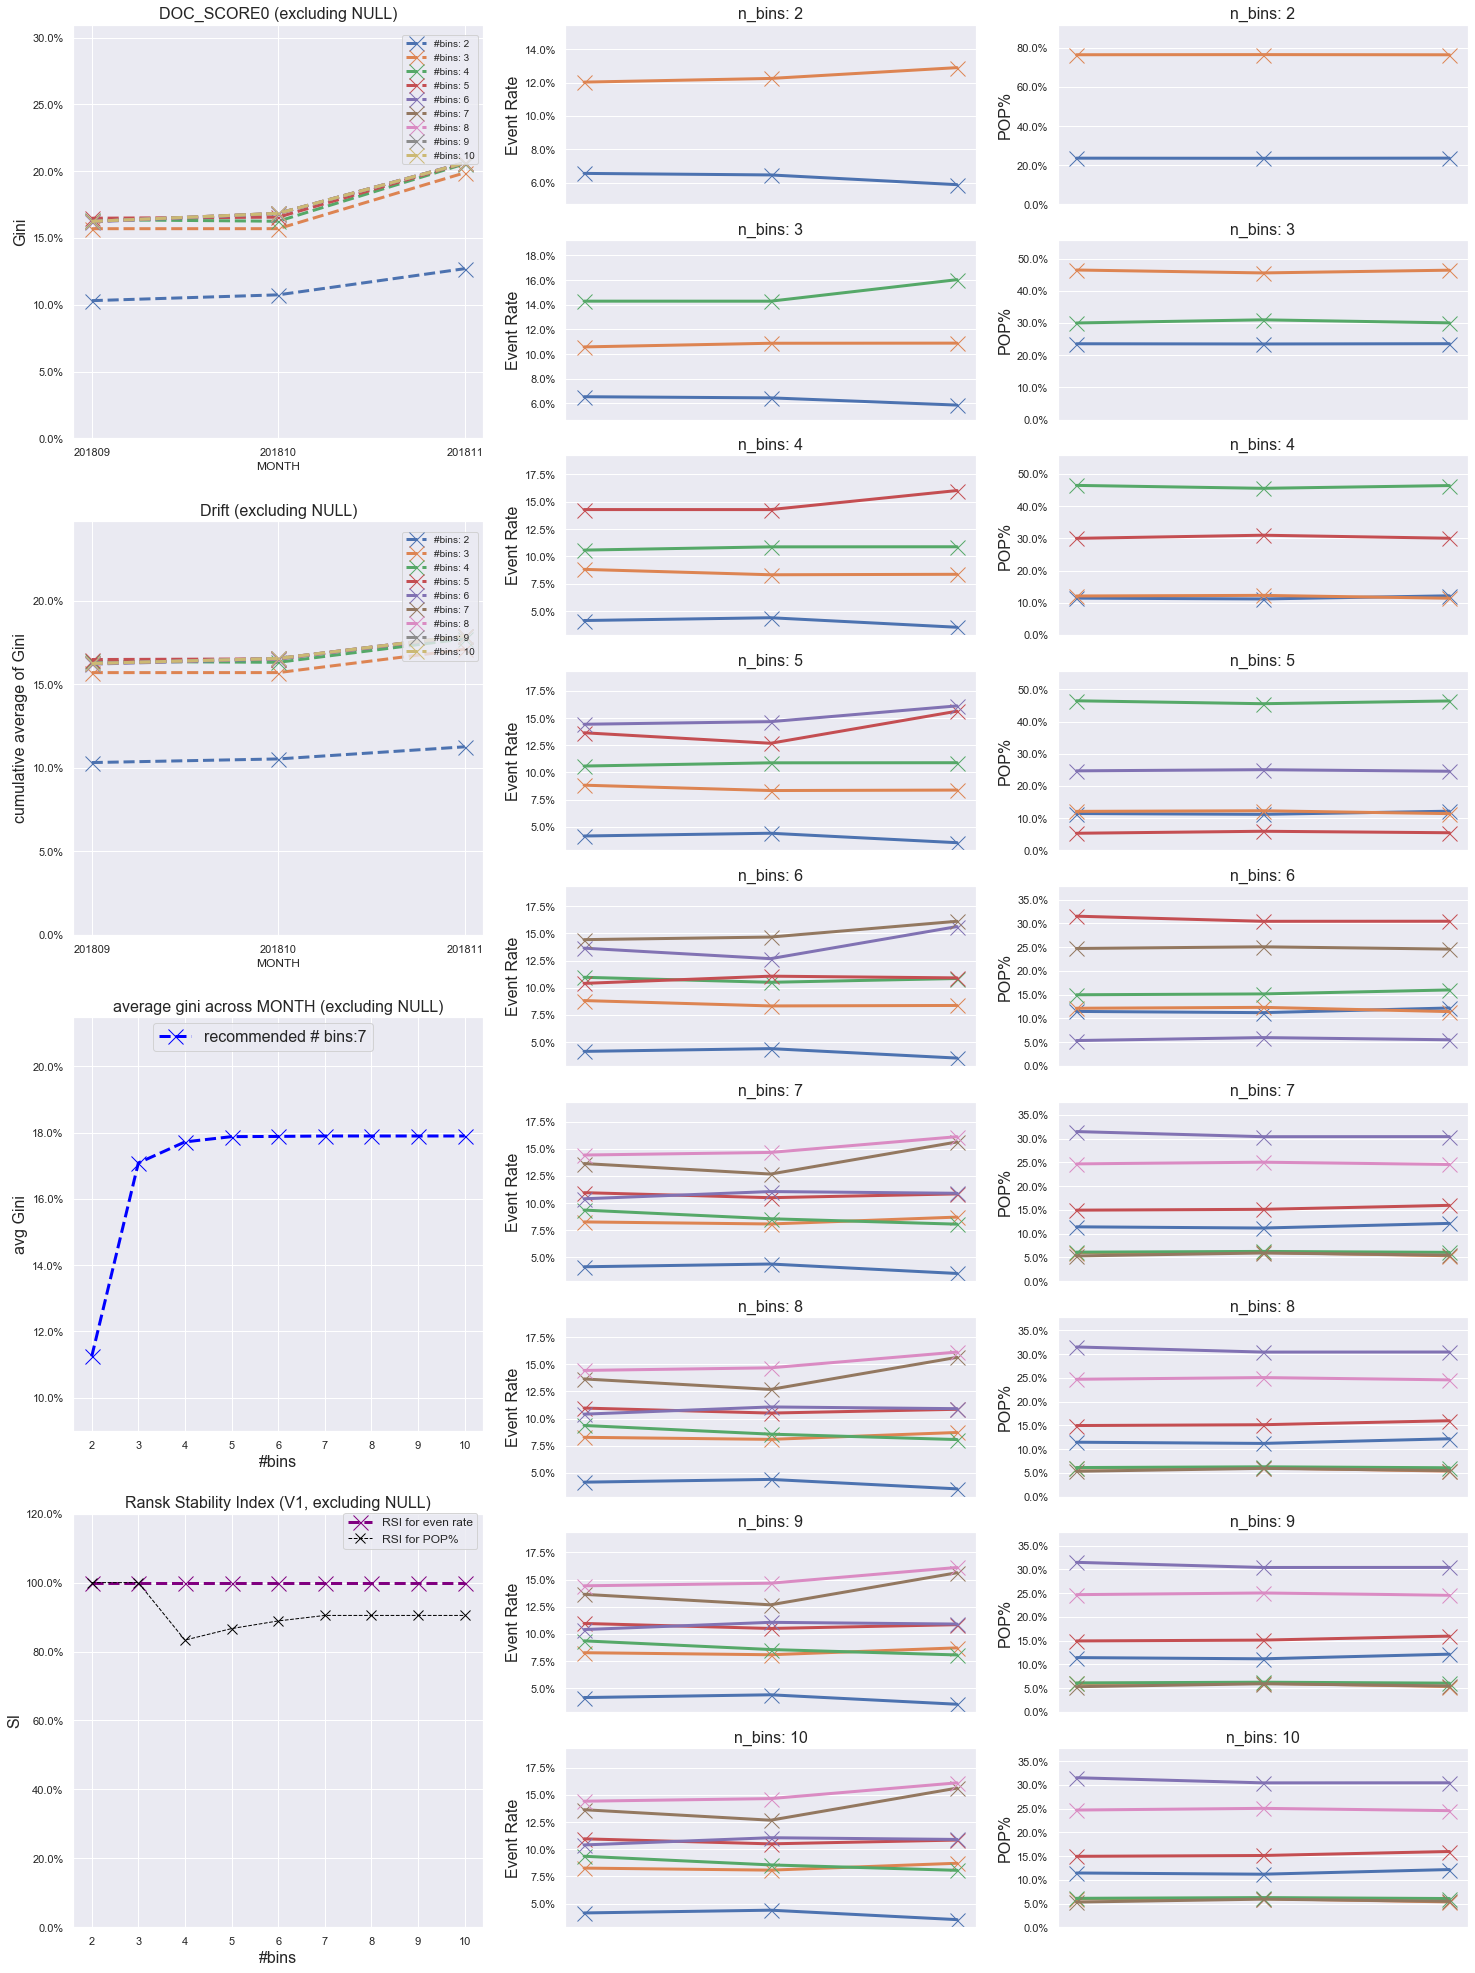

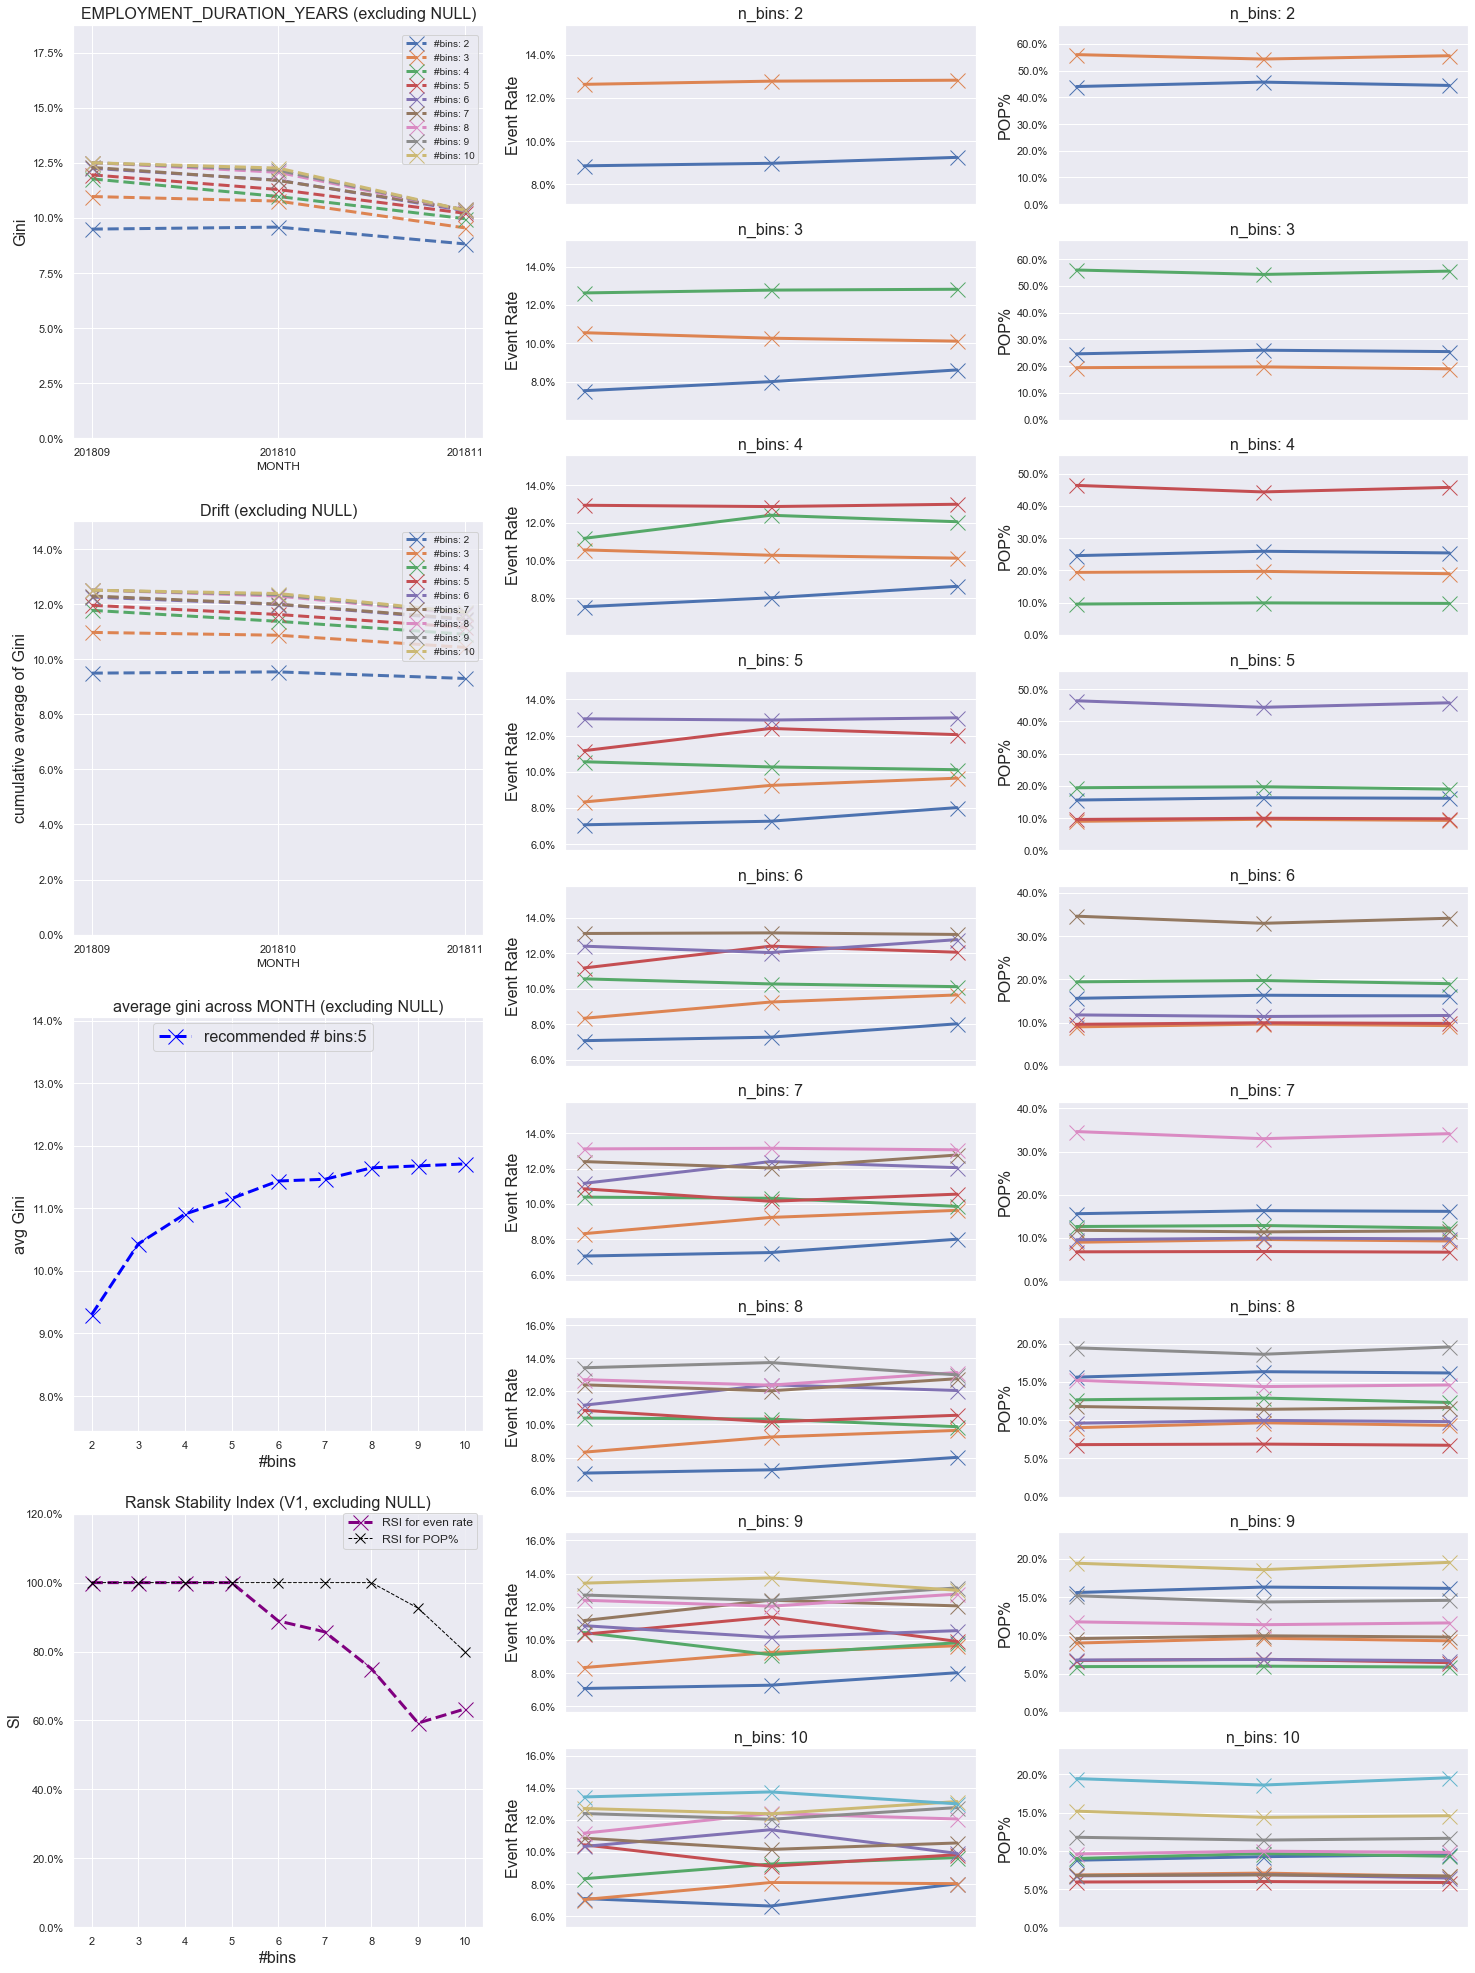

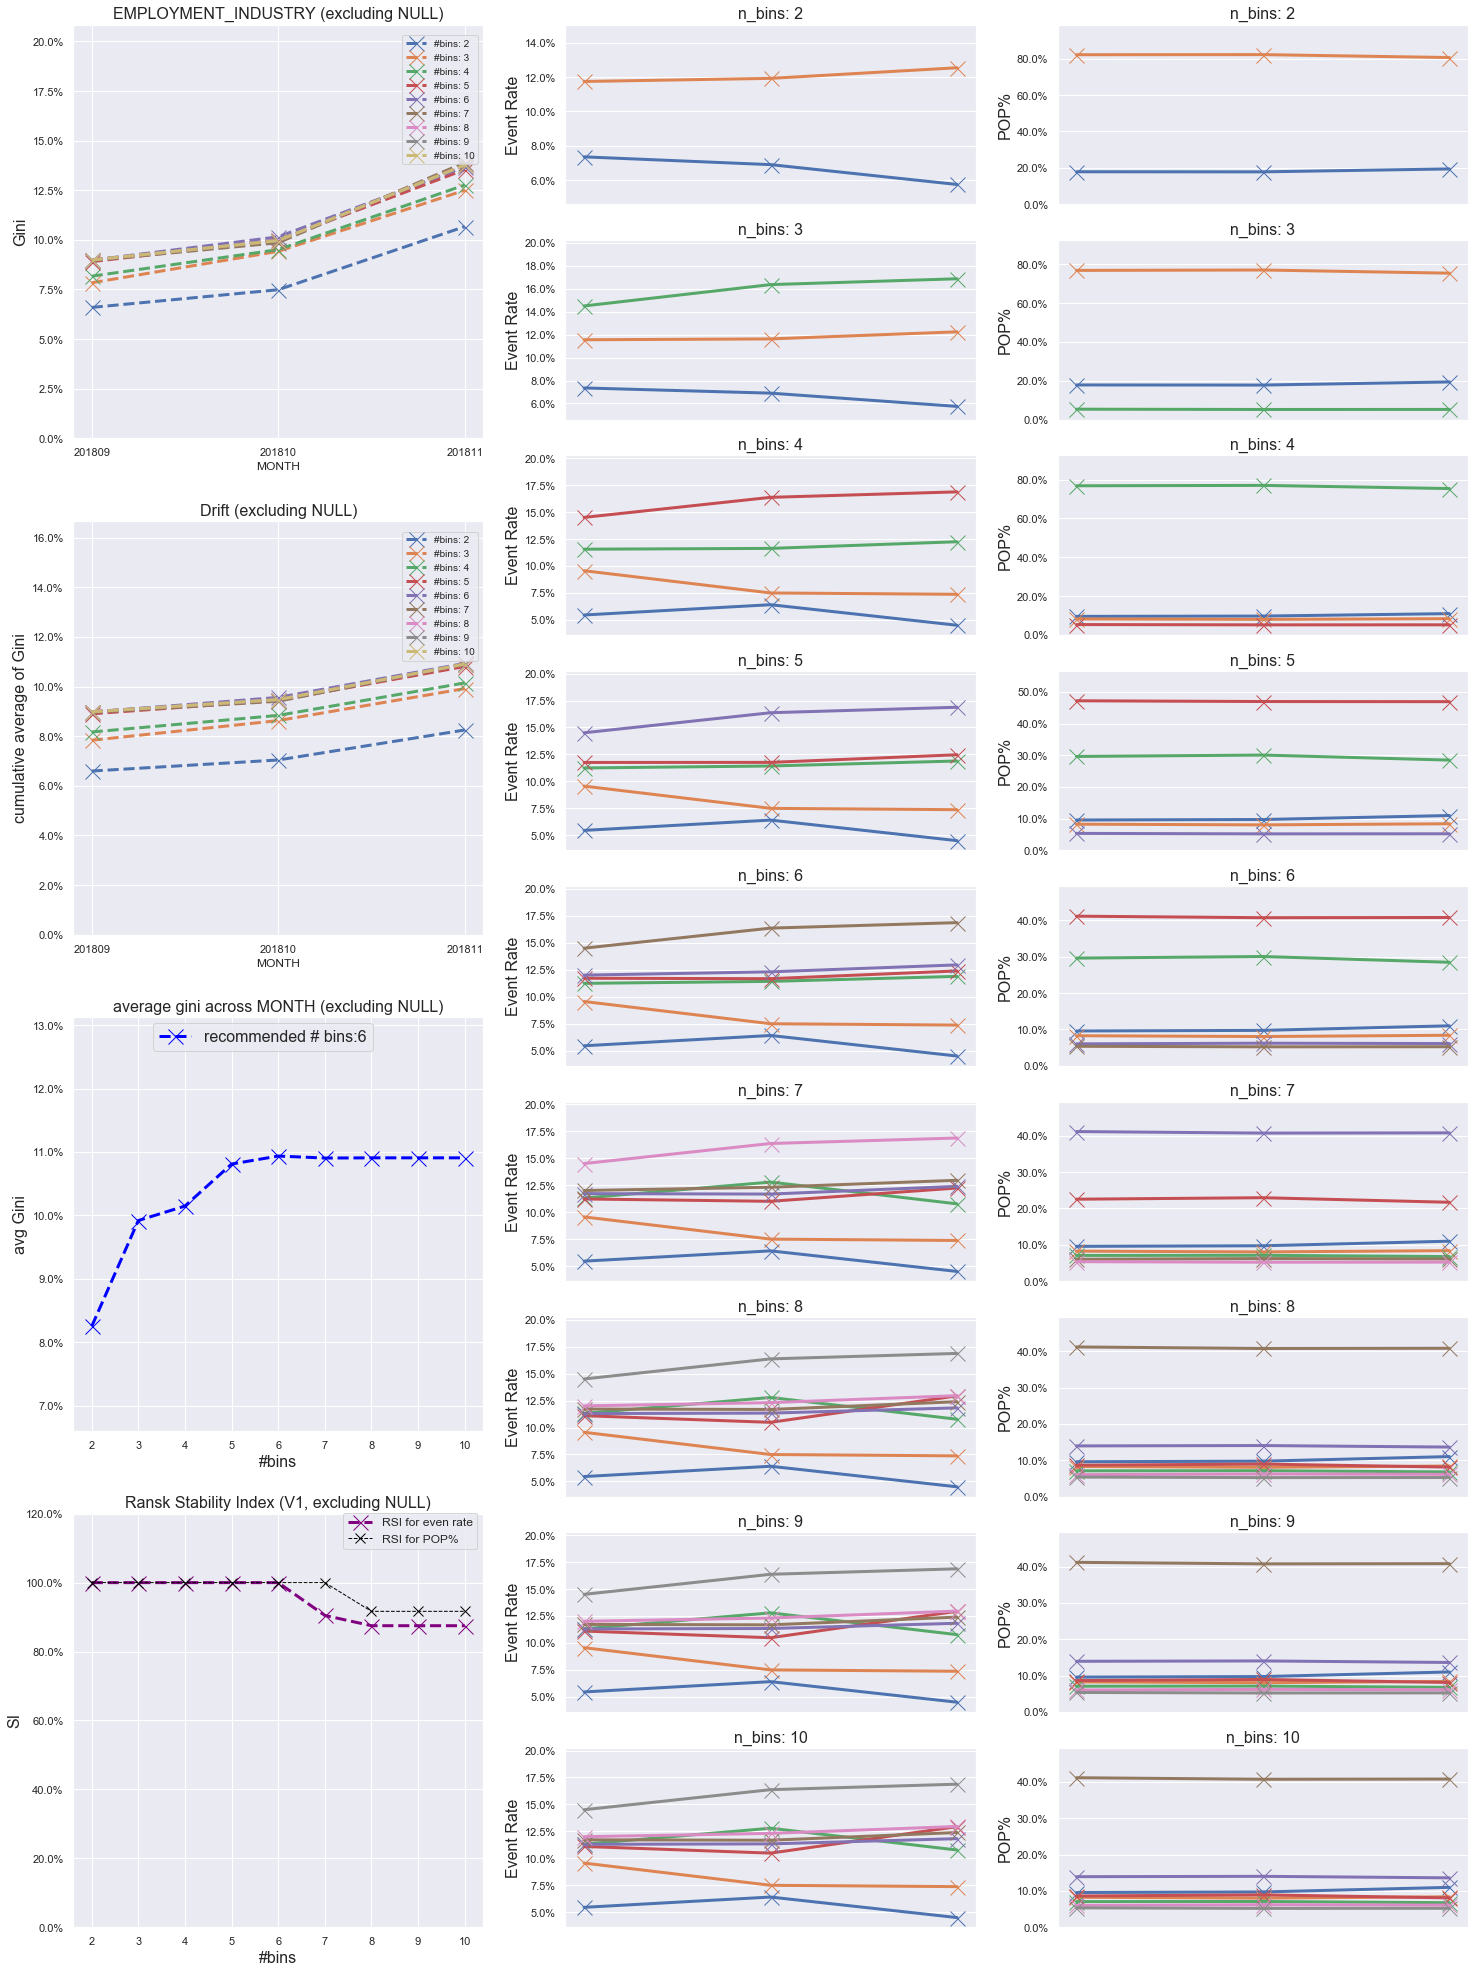

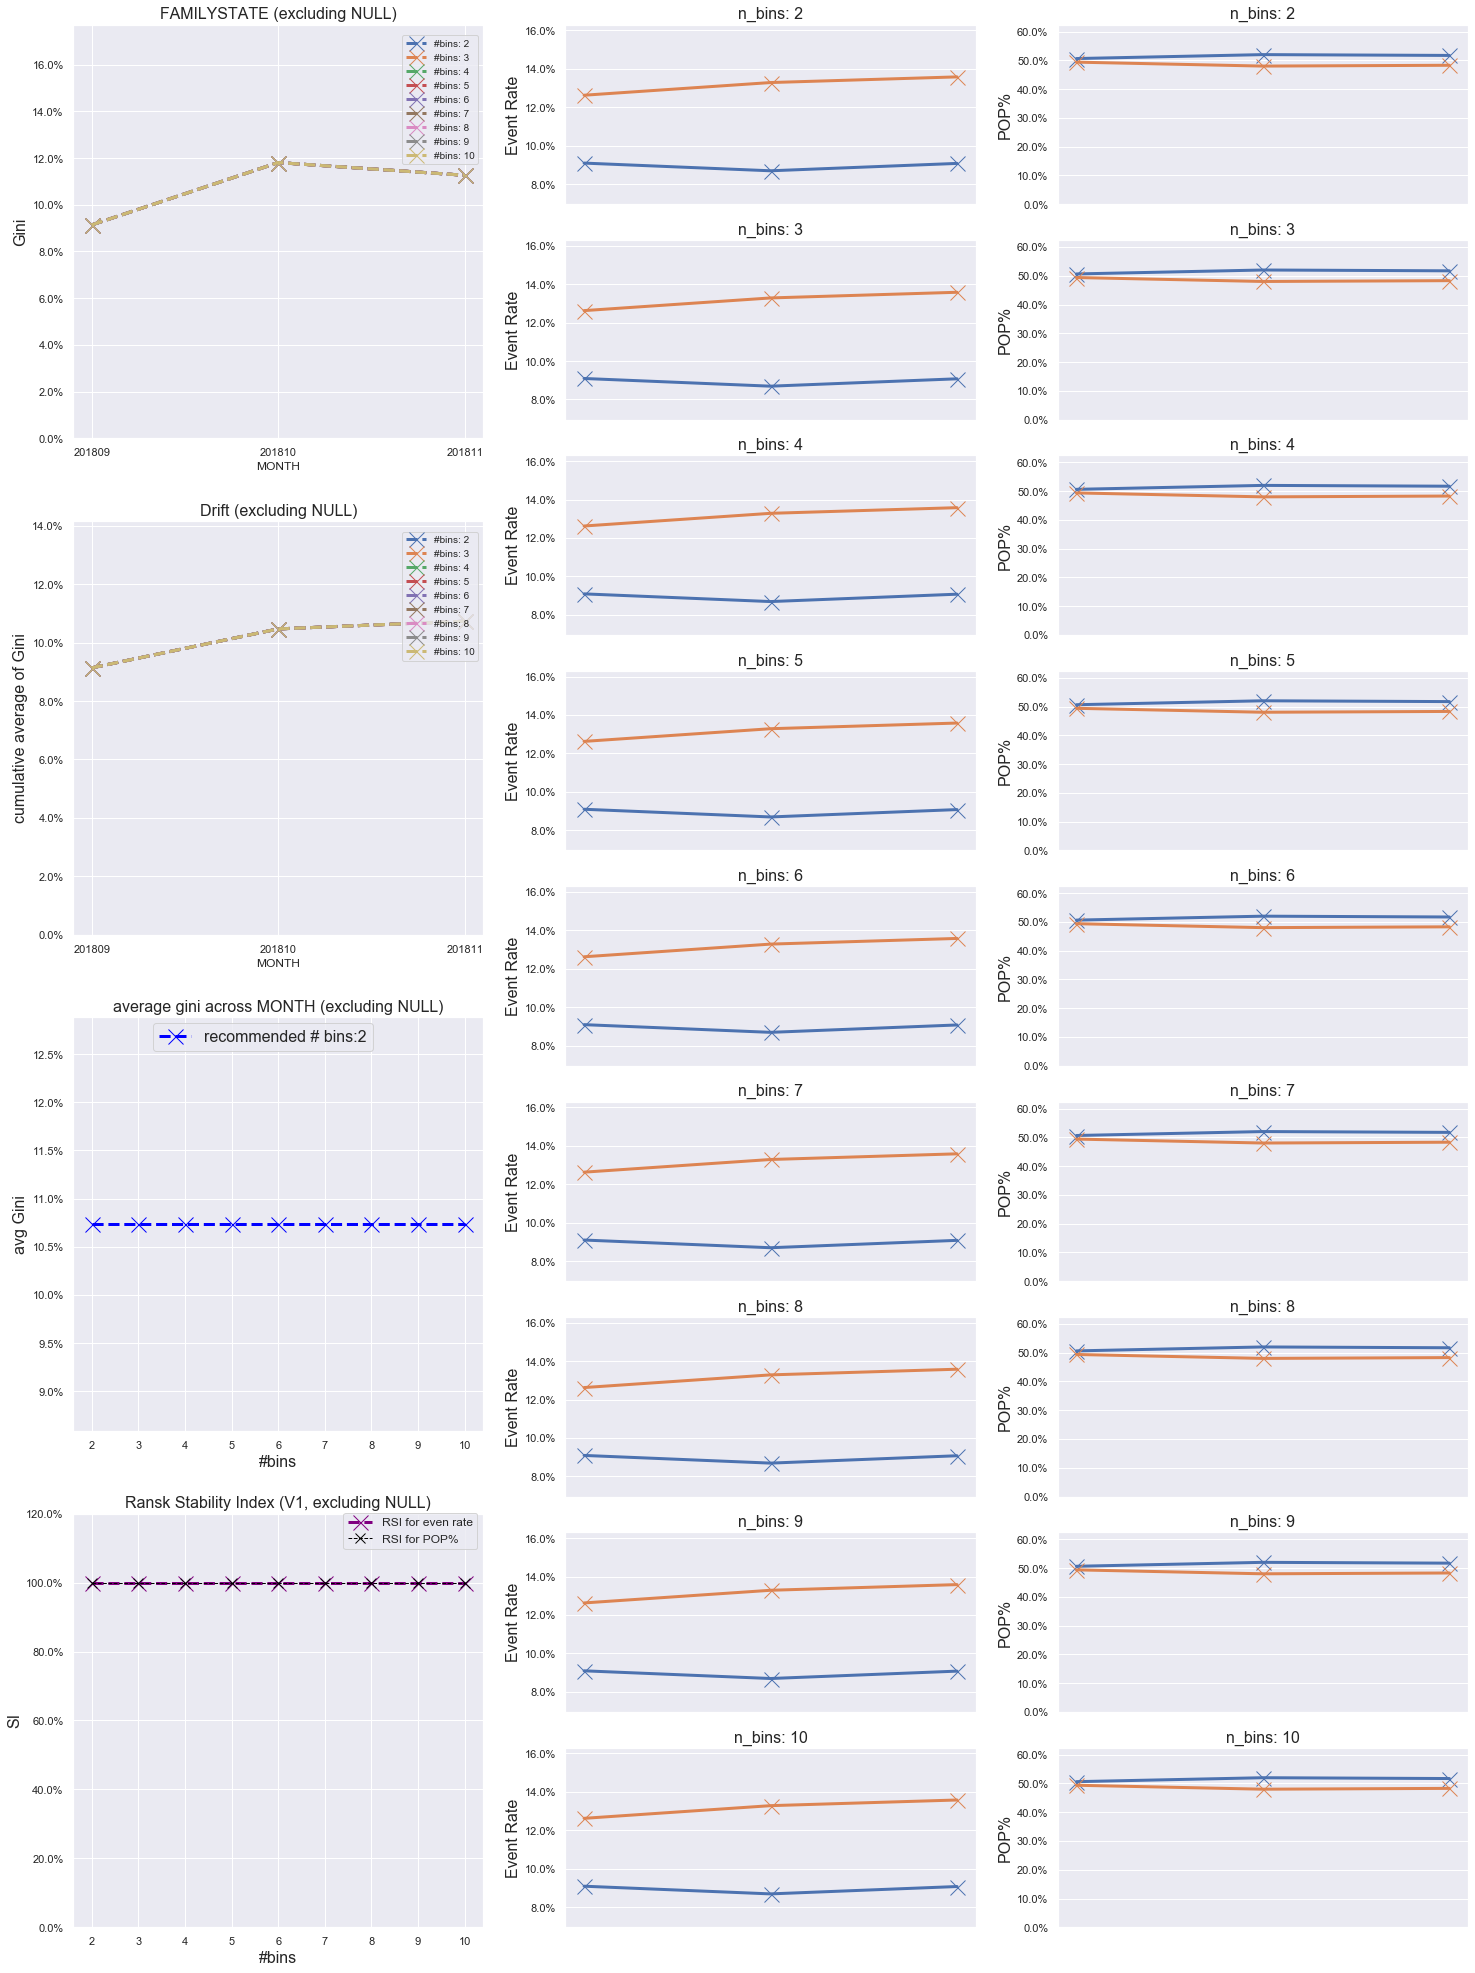

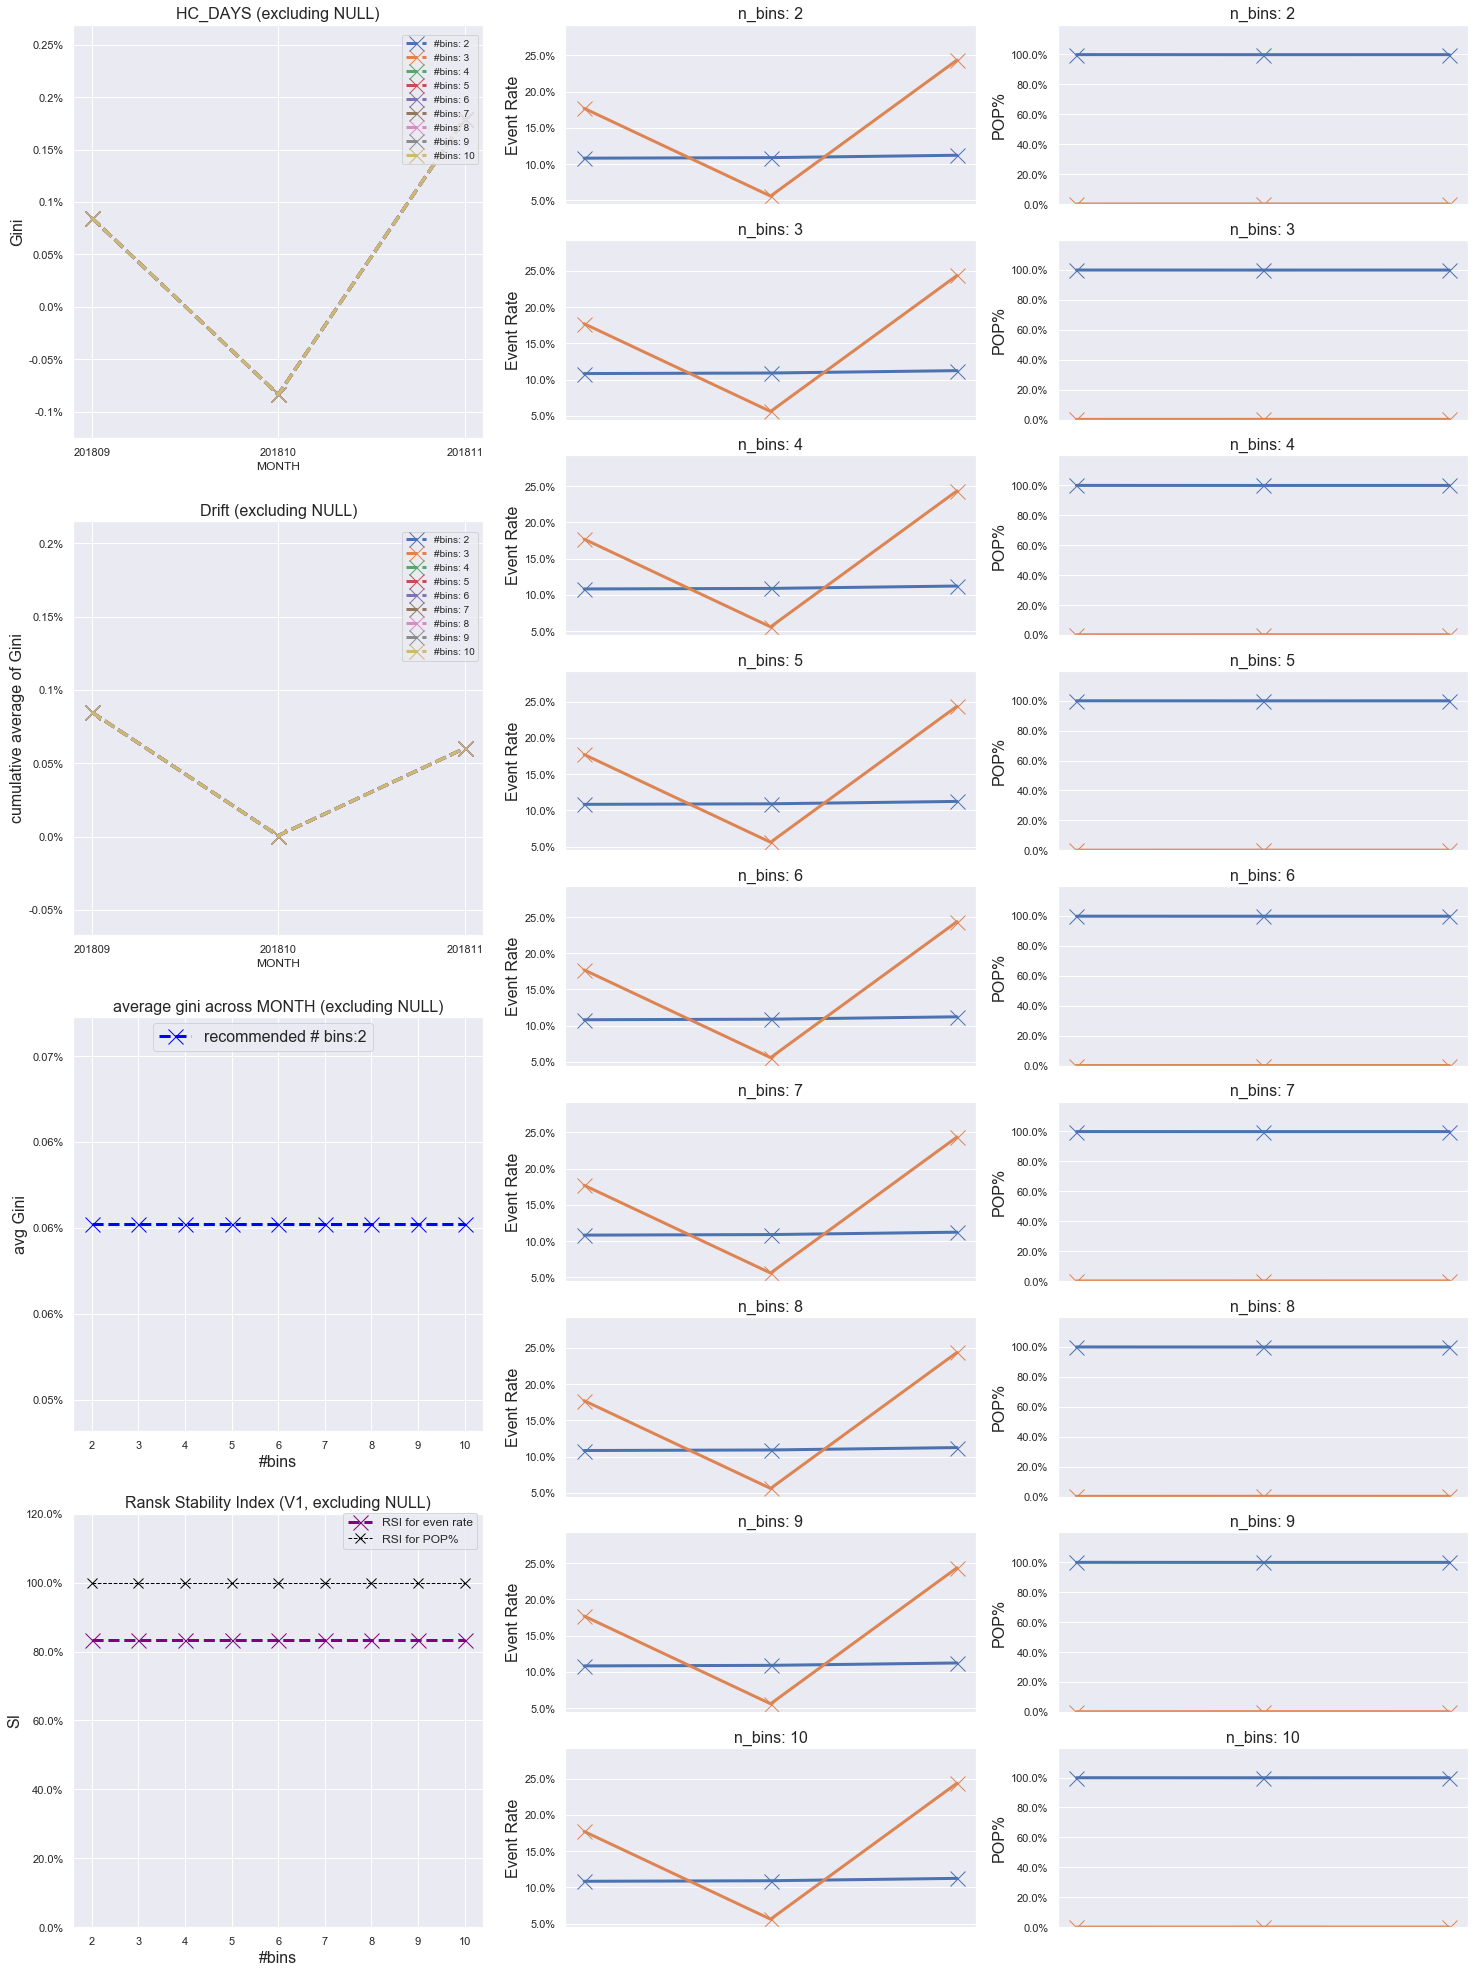

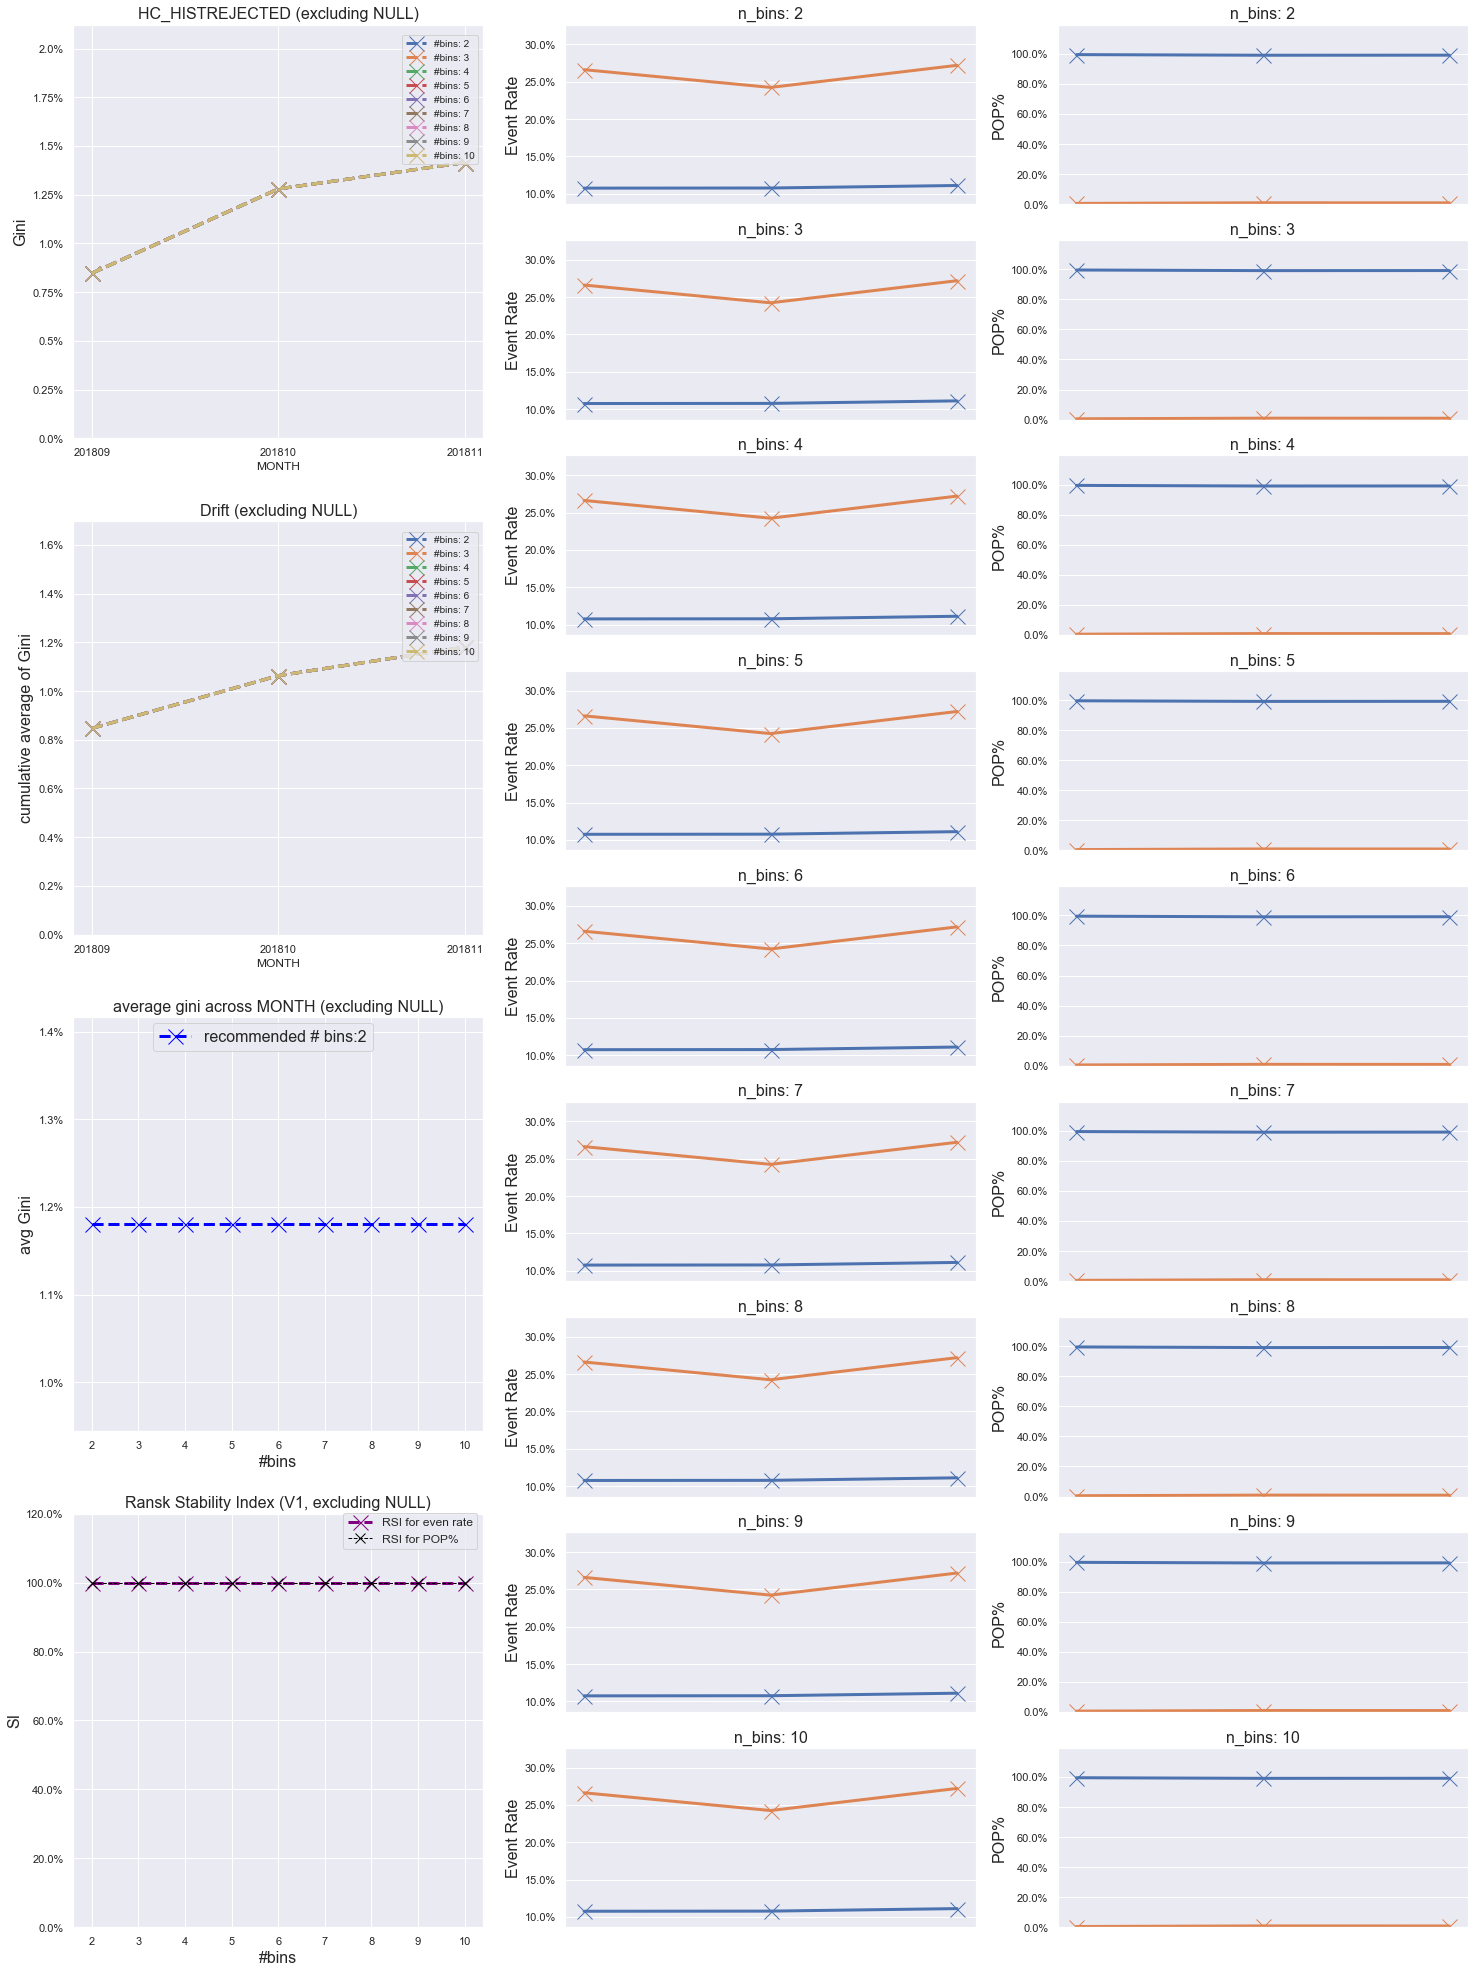

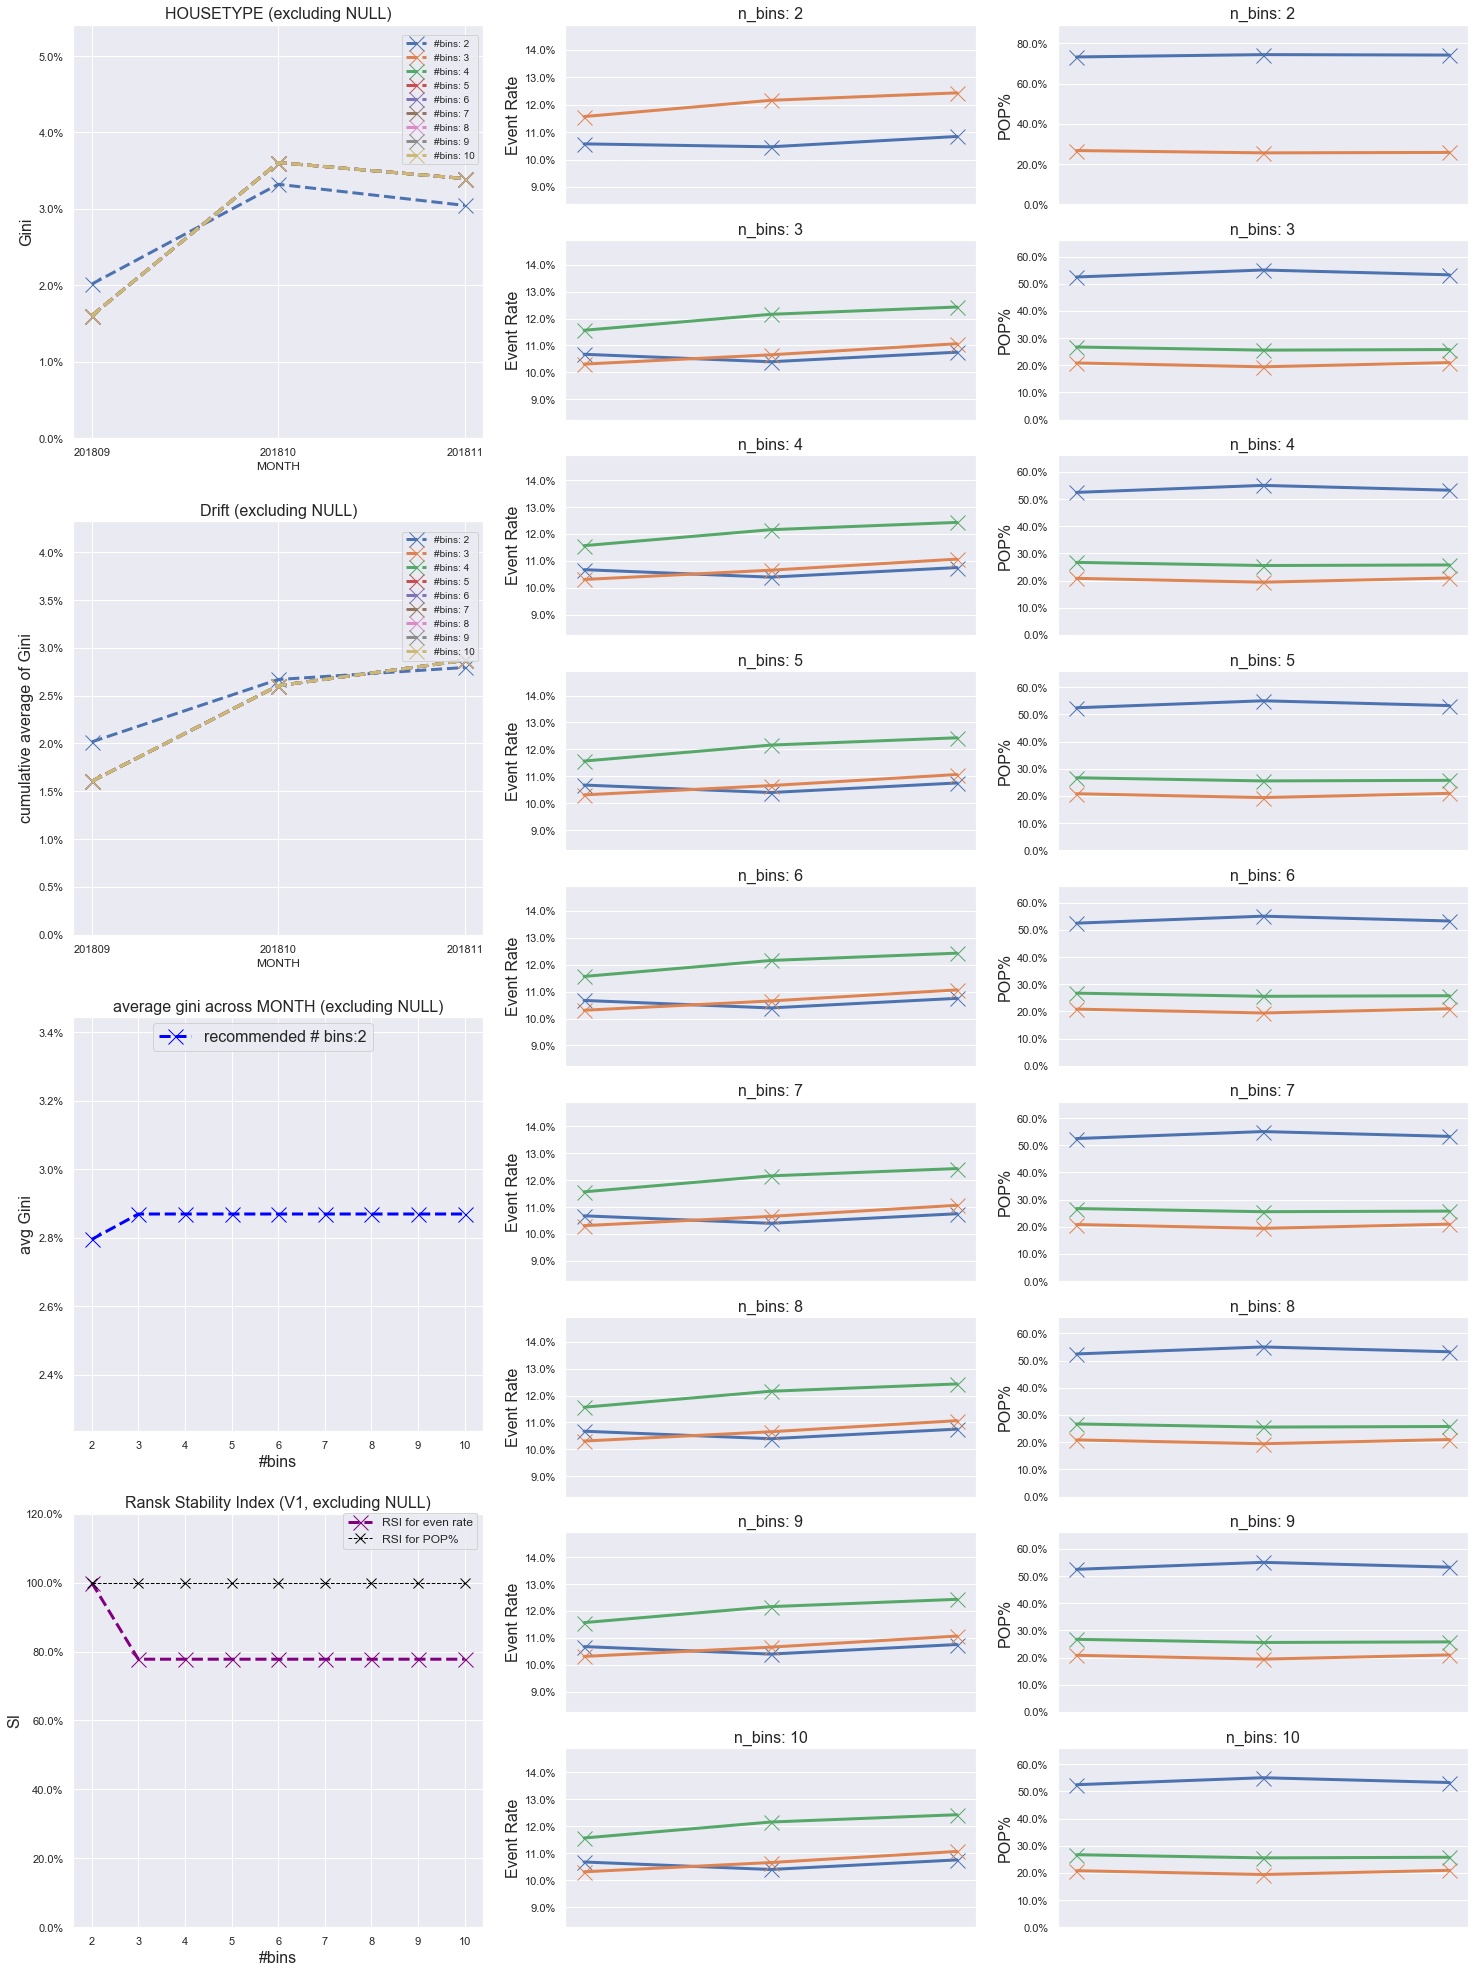

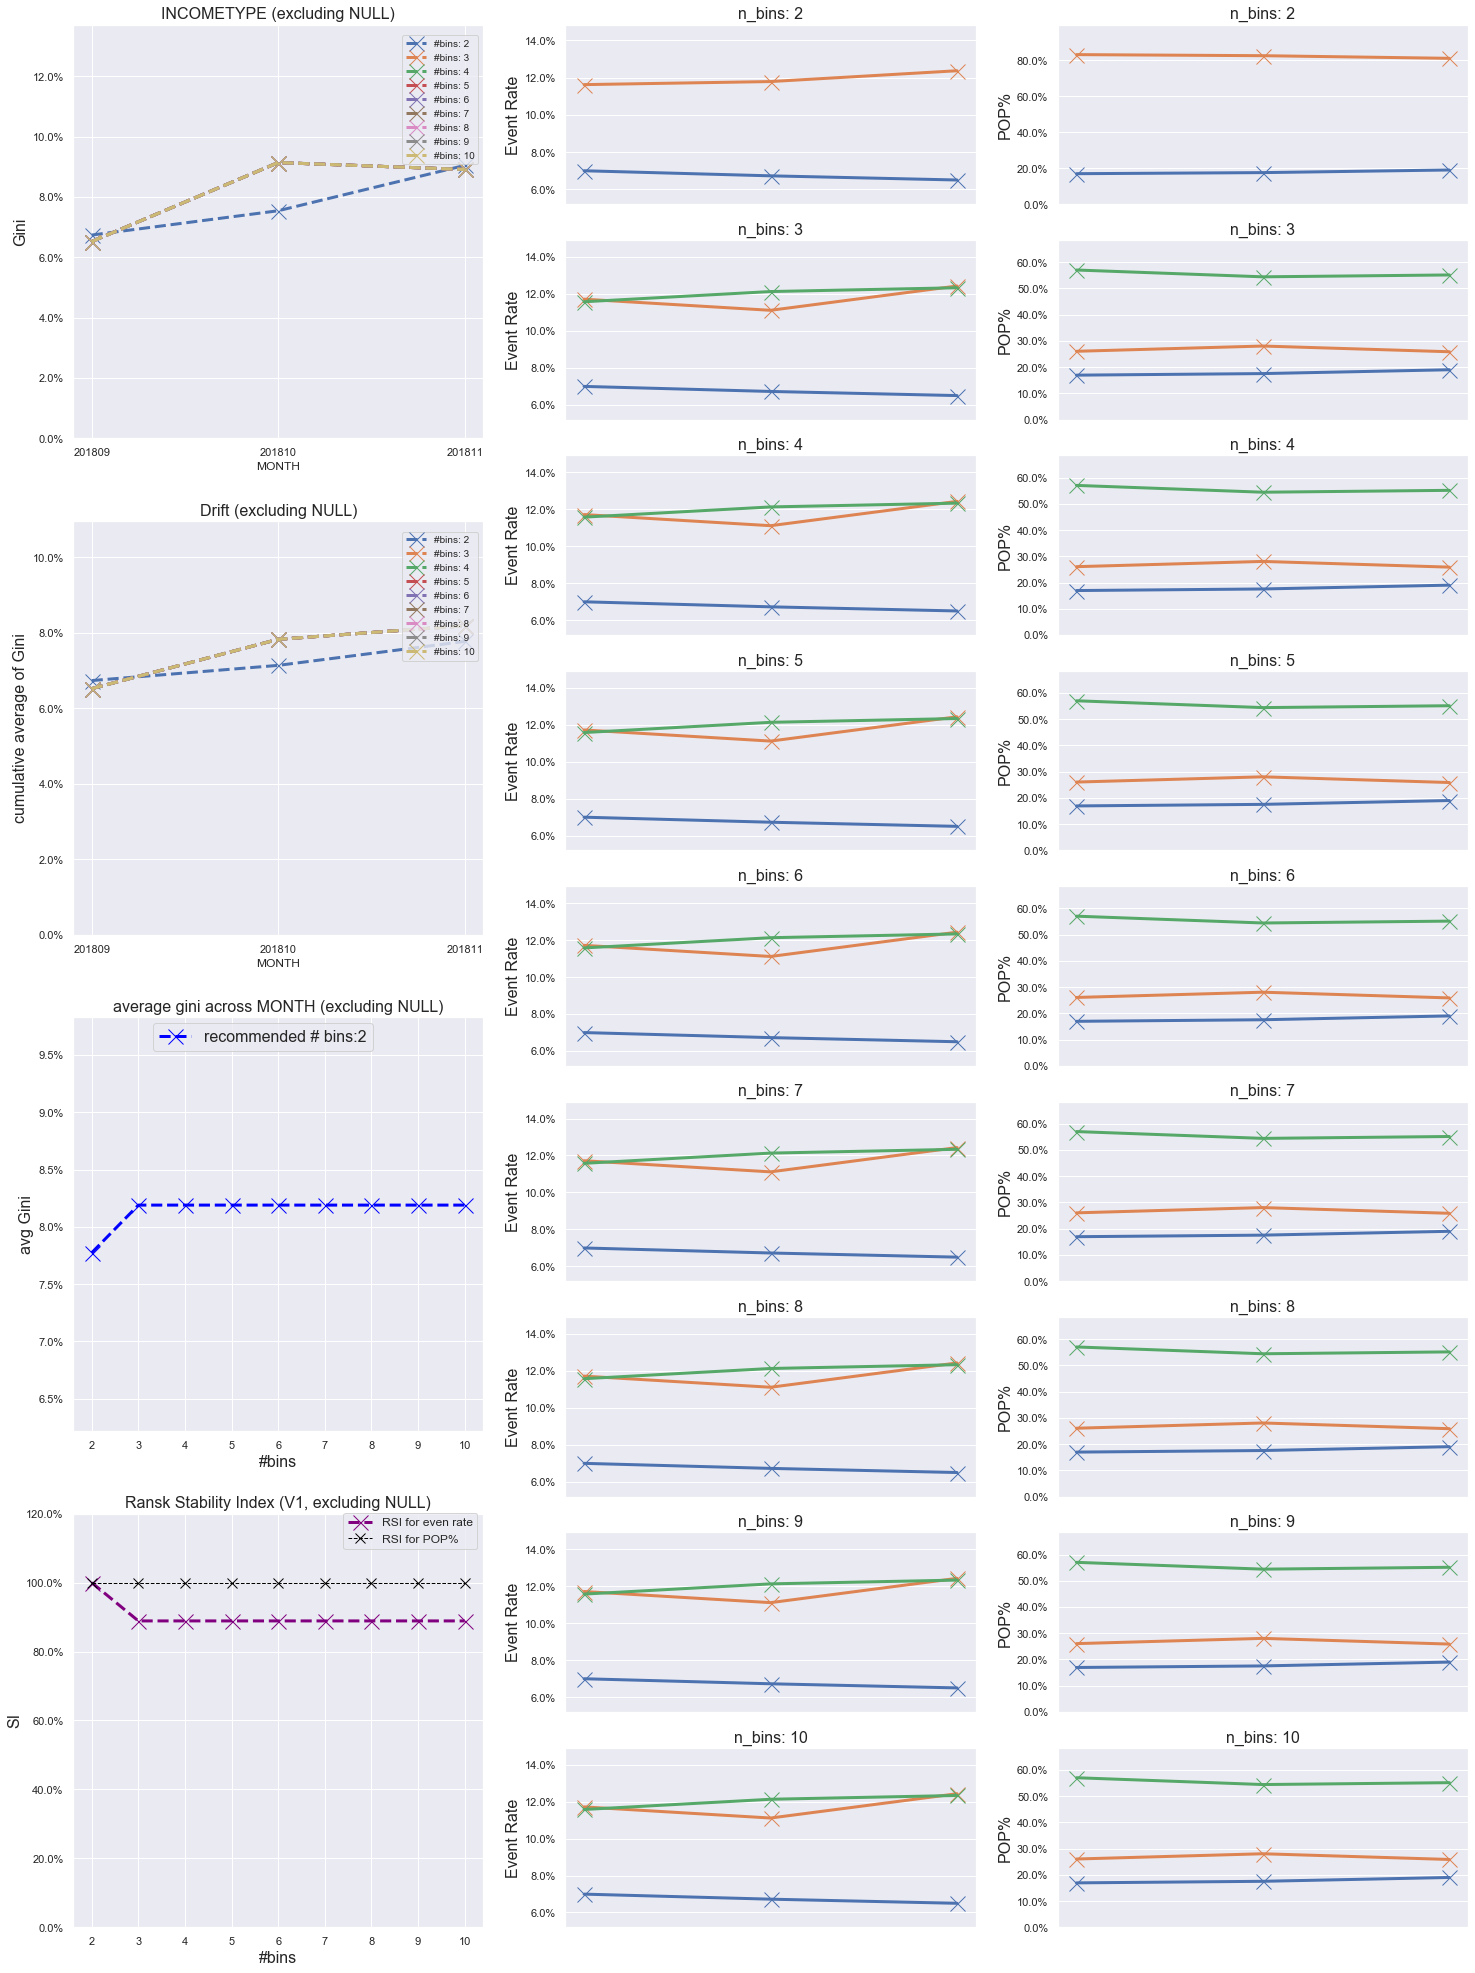

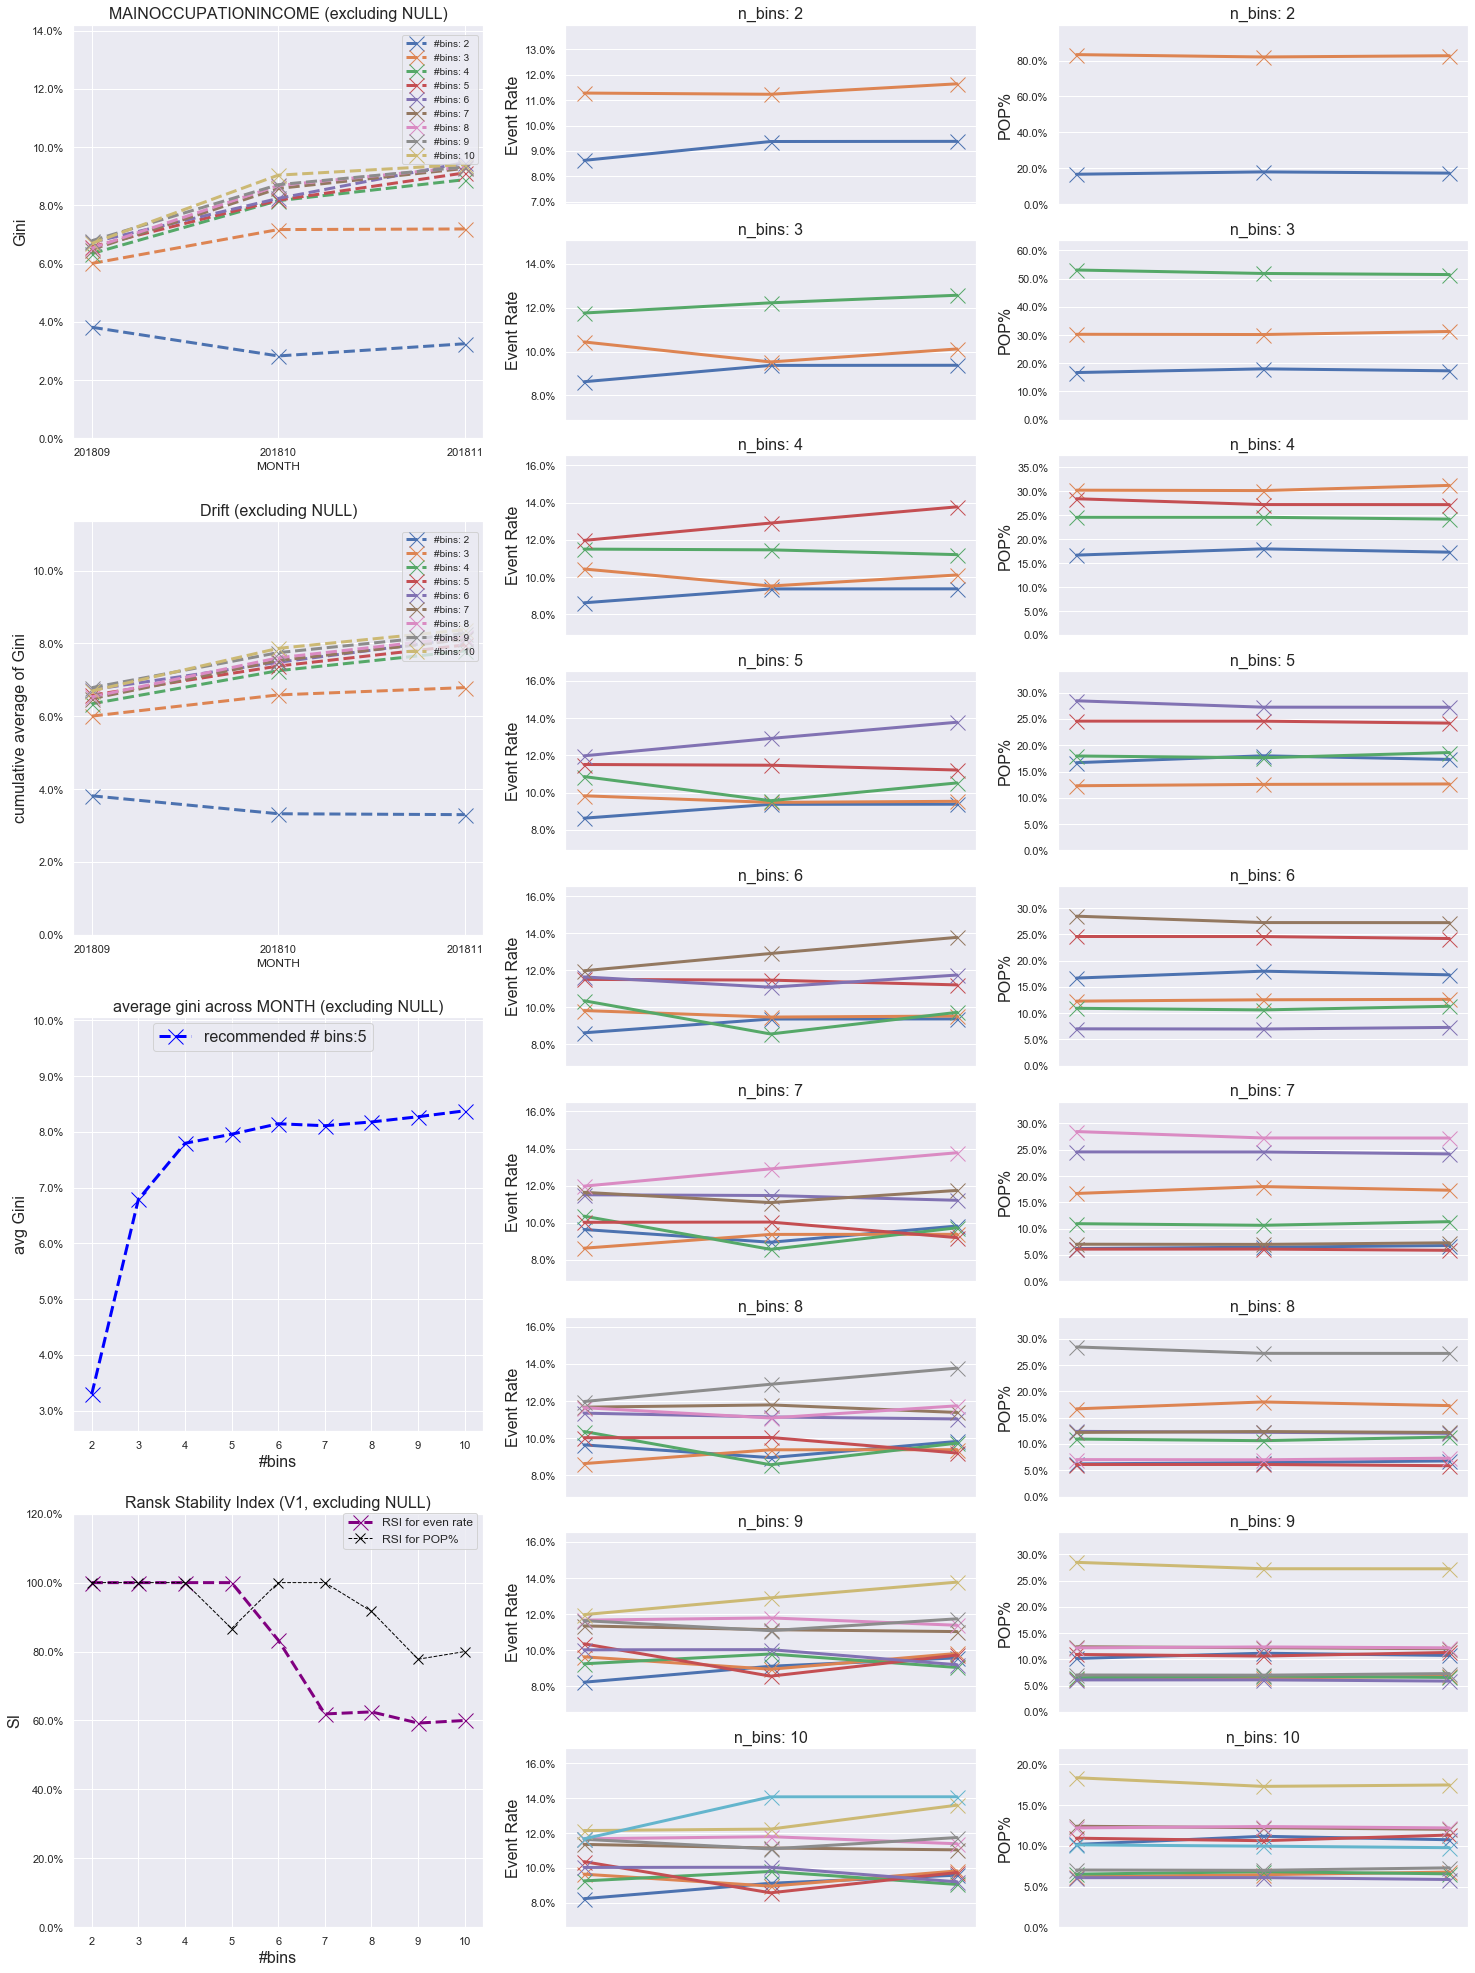

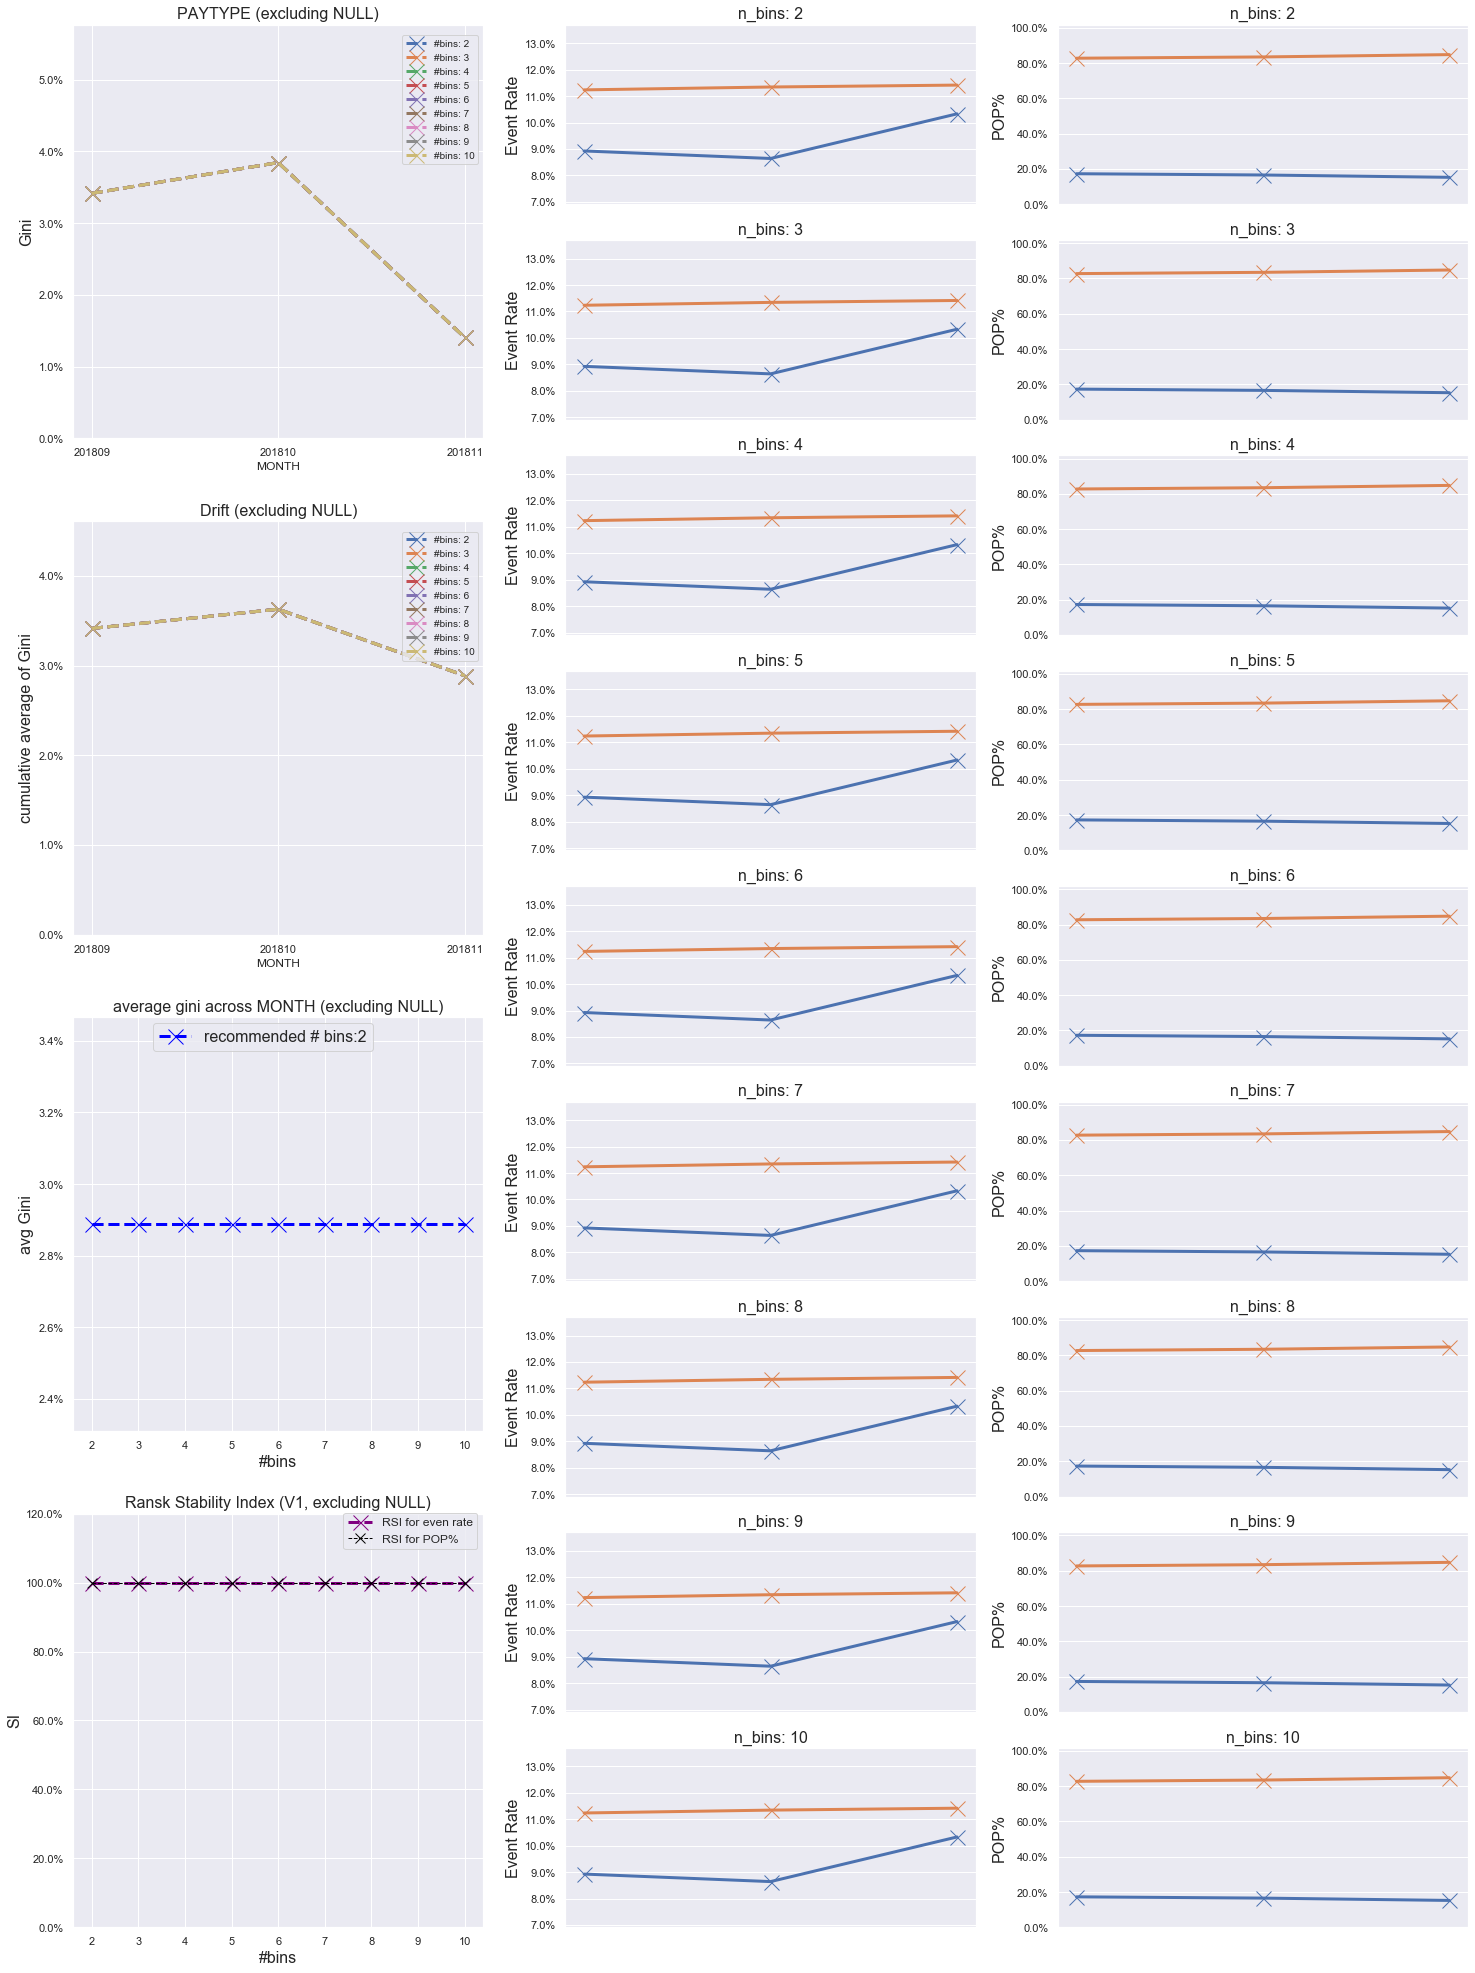

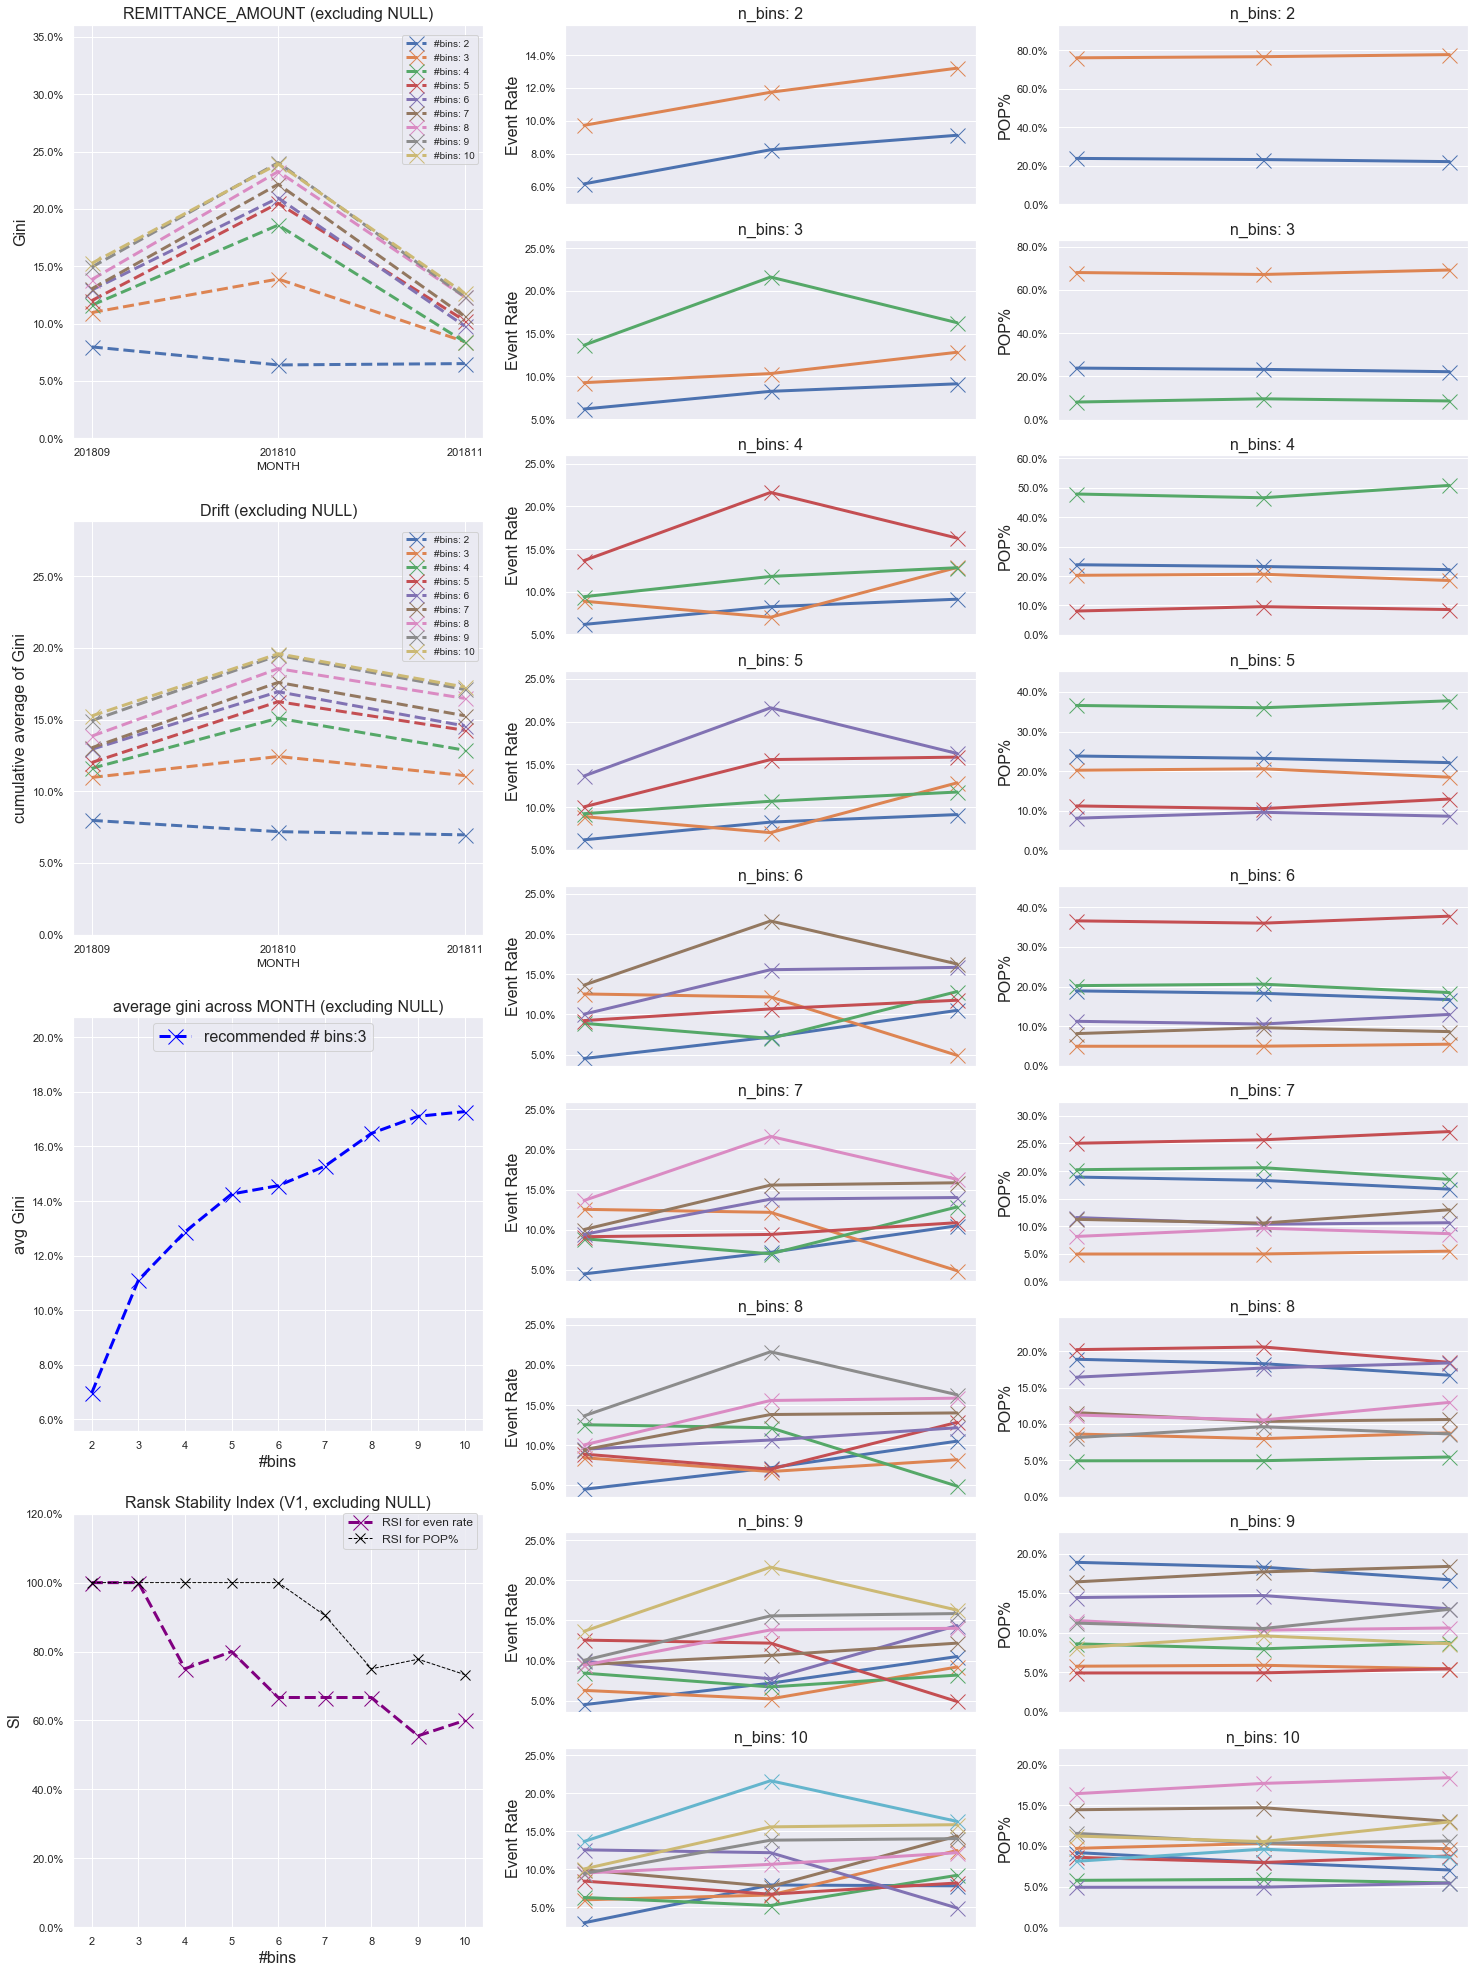

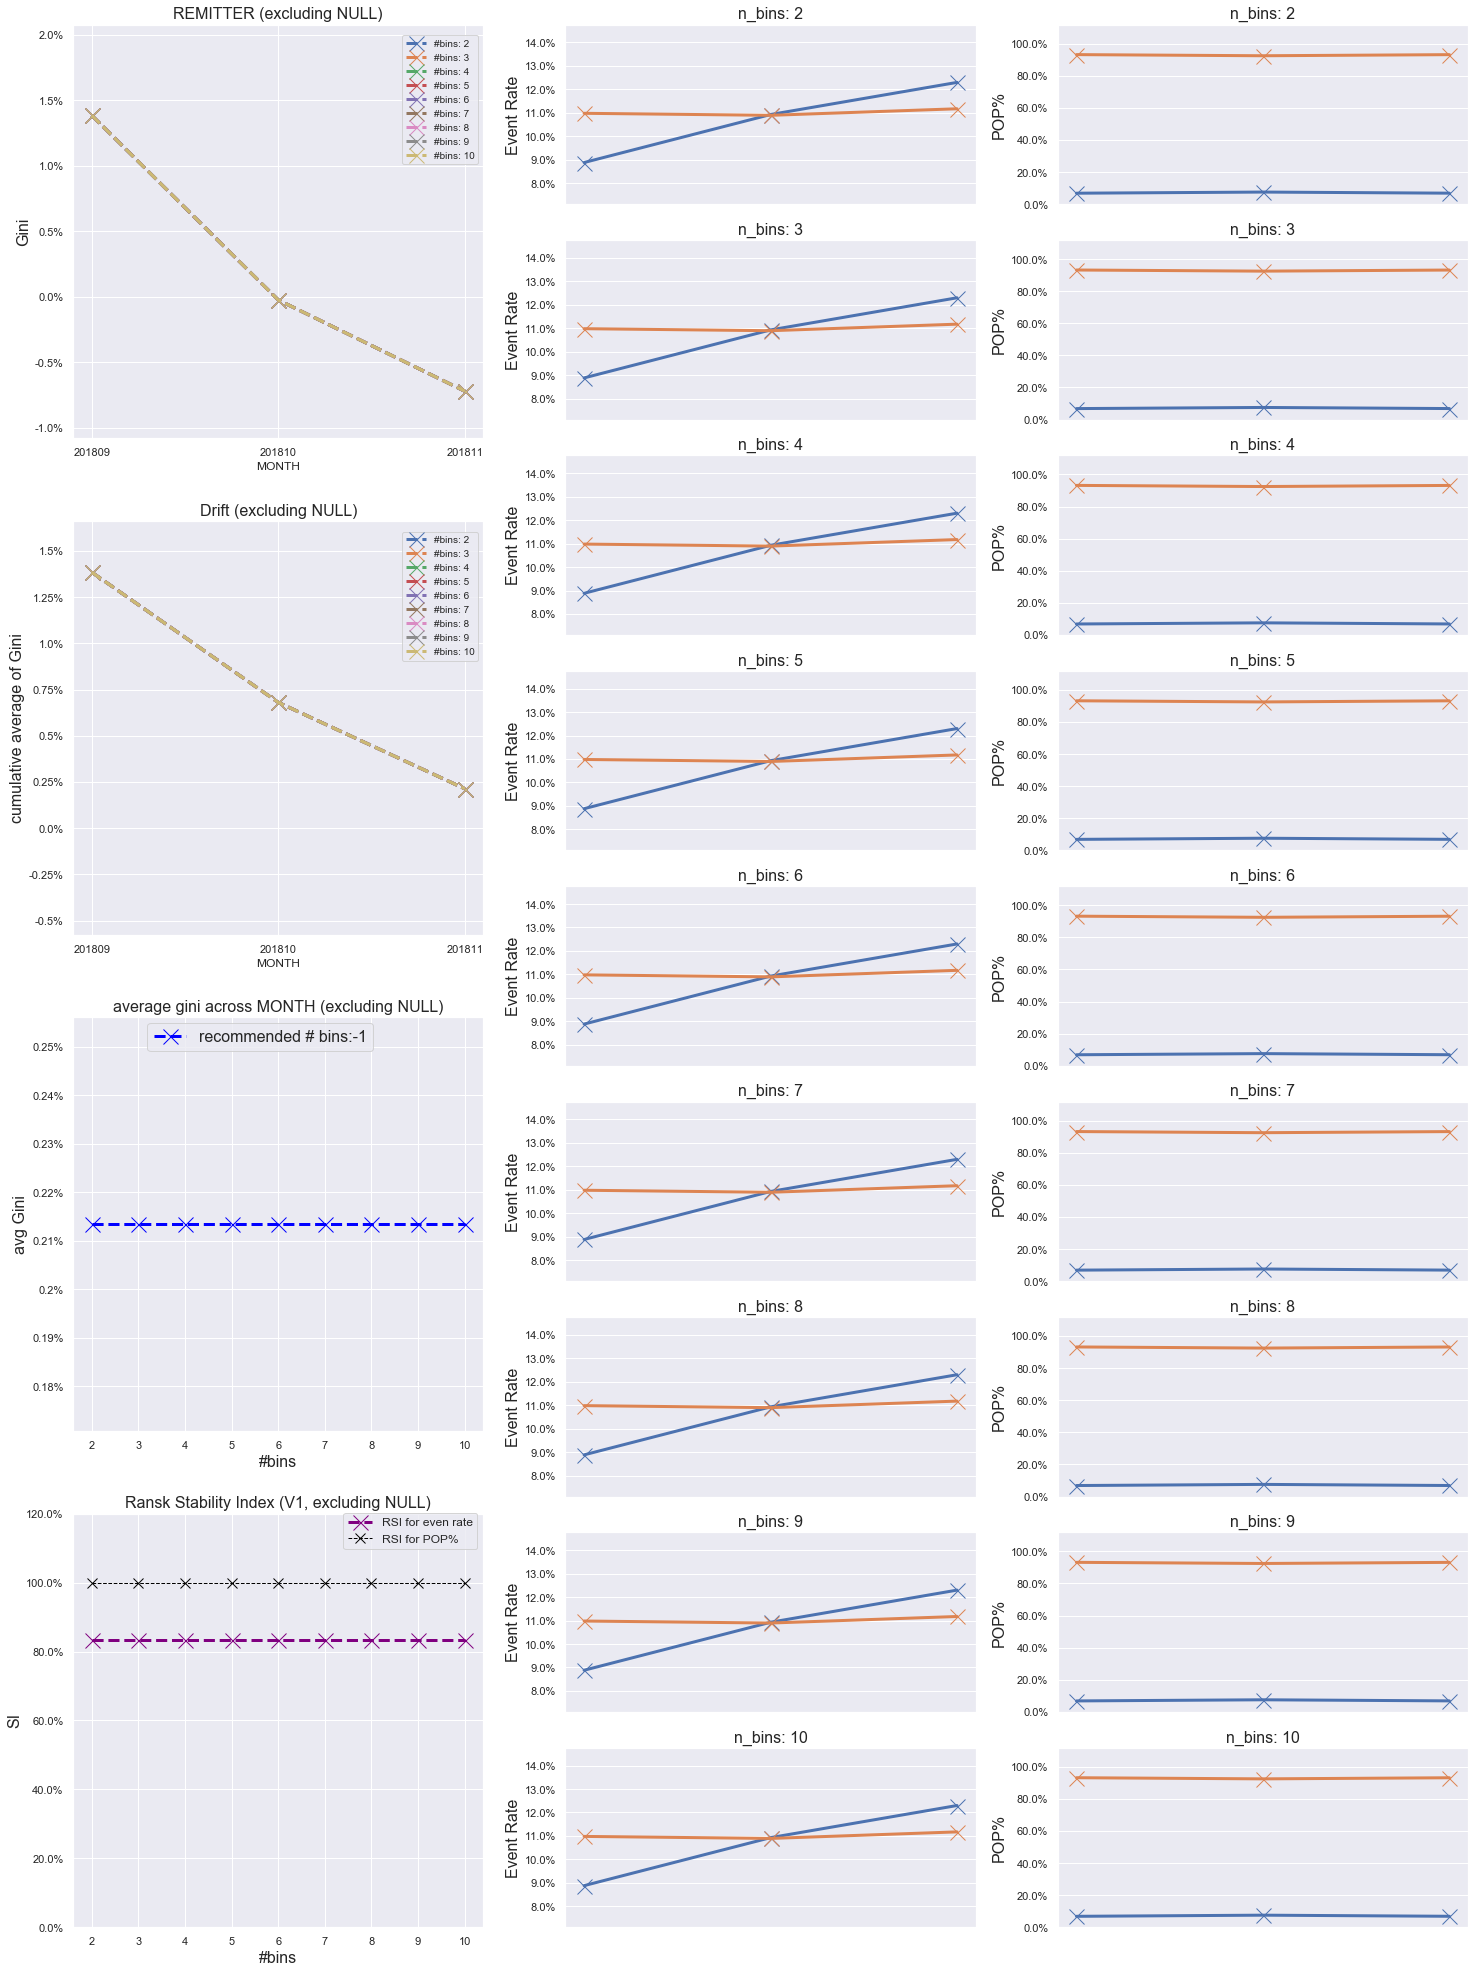

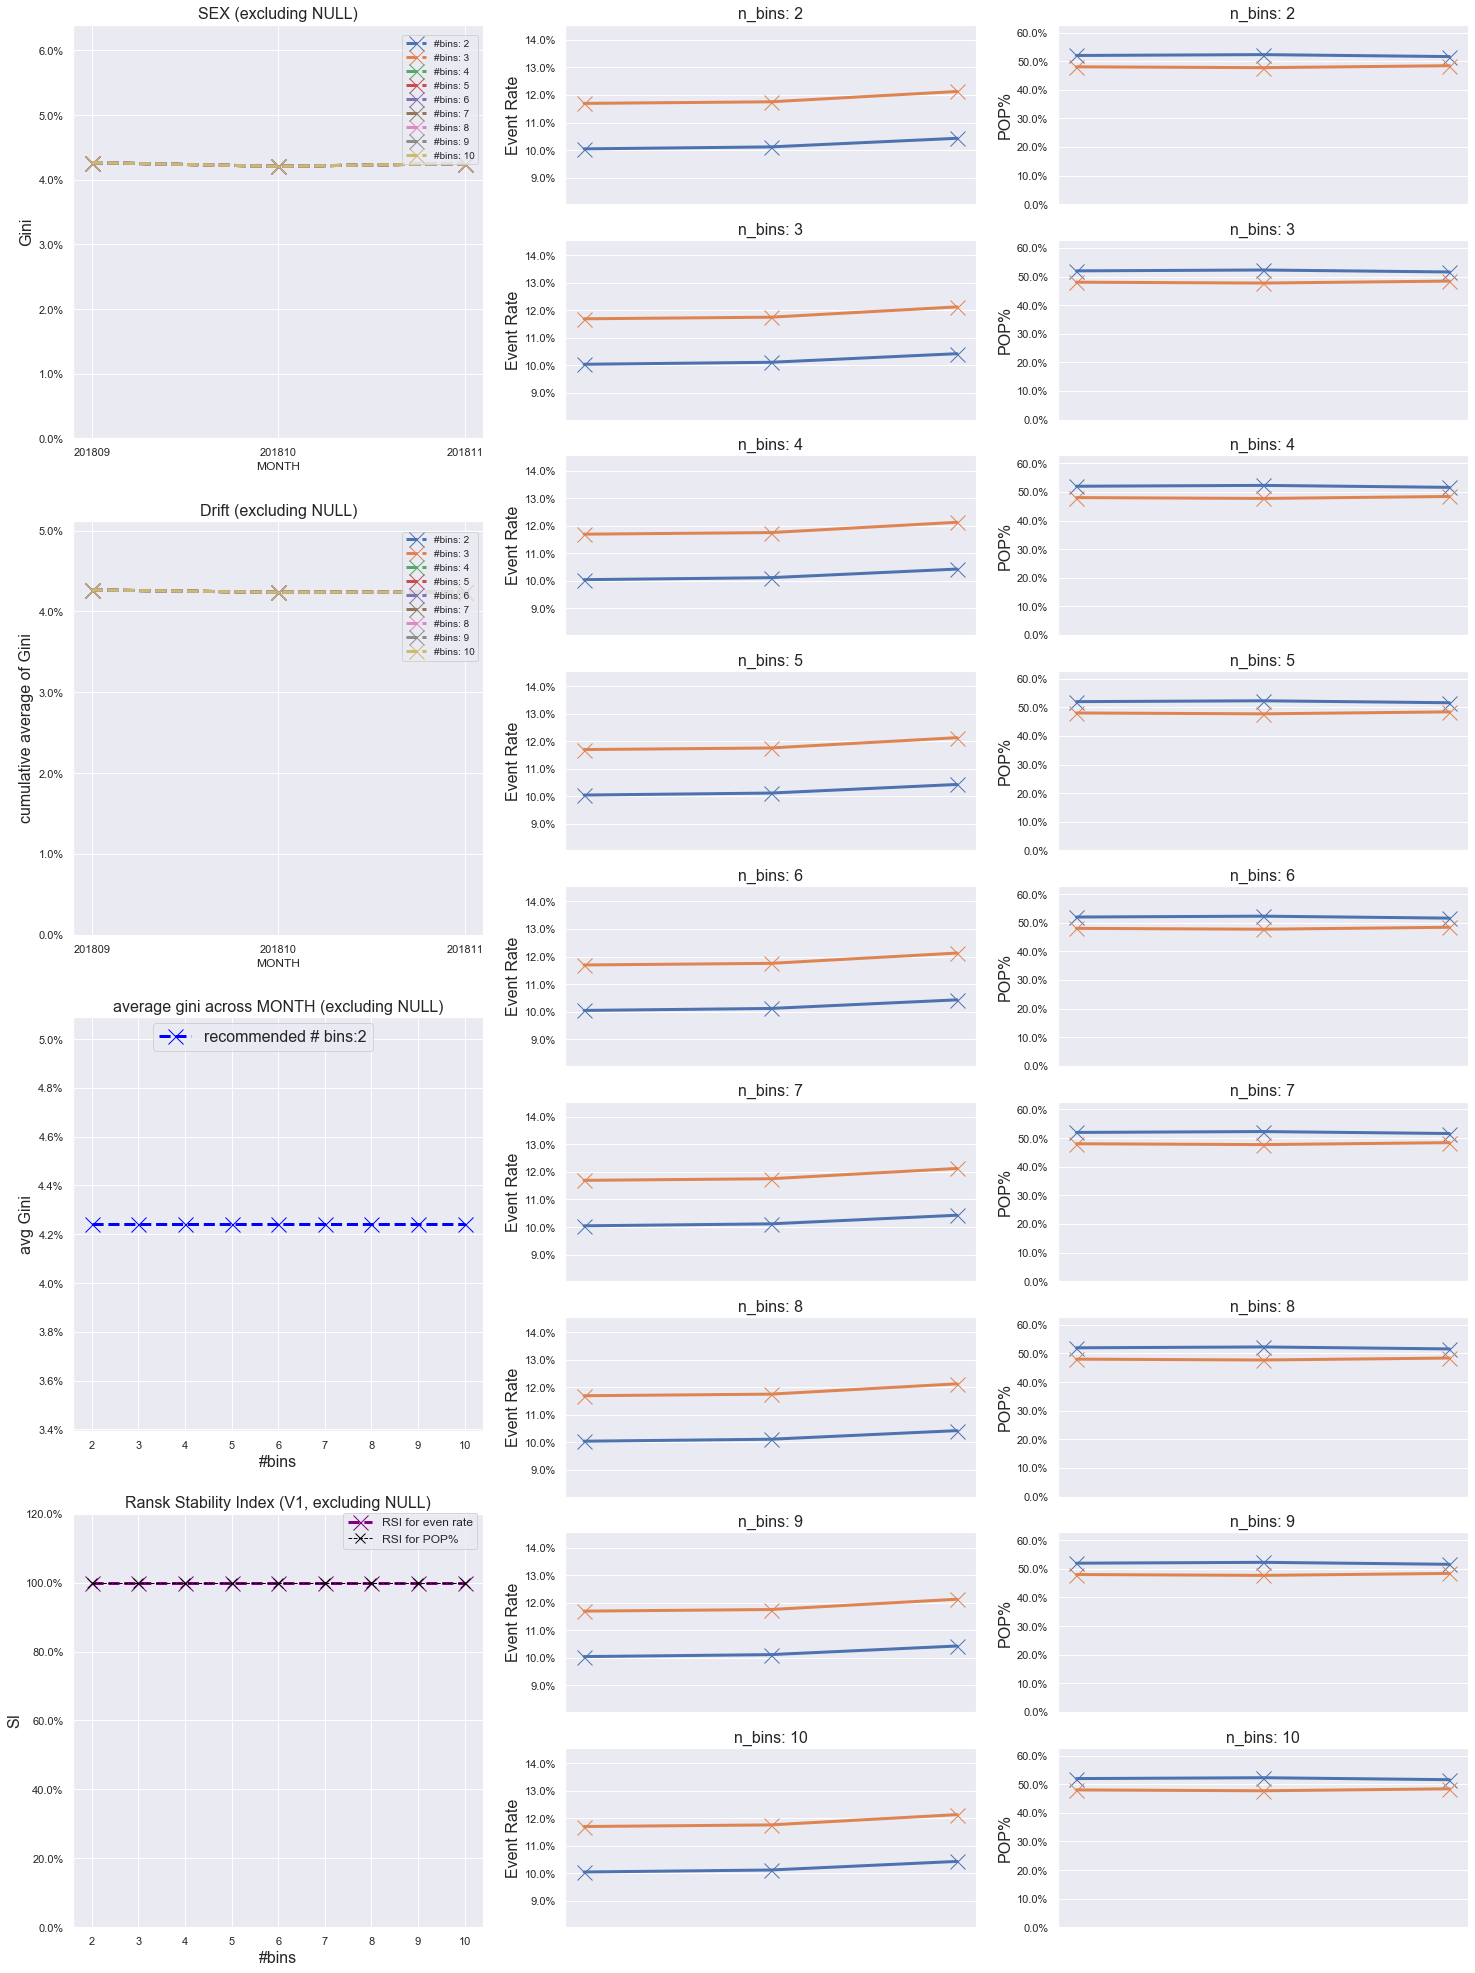

In [46]:
pd.set_option('display.max_rows', 50)

bin_stability_threshold = 0.10
_max_leaves = 10

def hommogenity(data, col): 
    mask = (data[col] == data[col].mode()[0] )
    hommogenity = data[mask].shape[0]/data.shape[0]
    return hommogenity  


excluded = []
bins = {}

N_VARS = len(sorted(list(set(cols_pred) -set(excluded))))

f = FloatProgress(description= 'vars' , min = 0, max =  N_VARS)
display(f)  

#------------------------------------------------------------------------------------------------------------#
for var in sorted(list(set(cols_pred) -set(excluded))):
#for var in ['MAINOCCUPATIONINCOME']:
    
    T = train_woe[~pd.isnull(train_woe[var])]
    T.reset_index(inplace = True)
    
    V = valid_woe[~pd.isnull(valid_woe[var])]
    V.reset_index(inplace = True)
    
    X = [var]

    if var in cols_pred_num:
        _cols_pred_num = X
        _cols_pred_cat = []
    else:
        _cols_pred_num = []
        _cols_pred_cat = X

    Y = col_target
    w = col_weight

    lgbm_train_data = lgb.Dataset(T[X], label = T[Y], weight = T[w], categorical_feature = _cols_pred_cat, free_raw_data=False)
    lgbm_valid_data = lgb.Dataset(V[X], label = V[Y], weight = V[w], reference=lgbm_train_data)

    #[]
    Eval_dat = valid_woe[~pd.isnull(valid_woe[var])][X + [col_target, col_weight, _col_month, col_base]]
    Eval_dat.reset_index(inplace = True)
    
    AUCS = {}
    AUCS_moving_average = {}
    
    warnings.filterwarnings('ignore')
    
    #[]
    fig = plt.figure(figsize=(25,35))
    
    gsG = fig.add_gridspec(1,3)
    gs = gsG[0].subgridspec(4,1)
    gs2 = gsG[1].subgridspec(_max_leaves-1,1)
    gs3 = gsG[2].subgridspec(_max_leaves-1,1)
    
    x_labels = sorted(Eval_dat[_col_month].unique())
    #[]

    cntgrph = 0
    #---------------------------------------------------------------------------#
    for num_leaves in np.arange(2,_max_leaves + 1):
        
        
        param['num_leaves'] = num_leaves
        if var not in important_minorities:
            param['min_data_in_leaf'] = int(0.05*T.shape[0])
        else:
            param['min_data_in_leaf'] = 100

        results = {} 
        METRIC ={}
        delta_METRIC ={}
        ROUNDS = {}

        bst = LGBM_trained_booster(param, lgbm_train_data ,lgbm_valid_data, results, METRIC, delta_METRIC, ROUNDS,[])
              
        #----------------------------> Ginins -----------------------------------------------#
        
        AUCS[num_leaves] = {}
        AUCS_moving_average[num_leaves] = {}
        STD = []
        Graphs_time_sequence  = pd.DataFrame()
        
        suma = 0
        c=0
        for month in sorted(Eval_dat[_col_month].unique()):
            
            df = Eval_dat[Eval_dat[_col_month]== month]
            df.reset_index(inplace = True)
            
            df_predprob = bst.predict(df[X], num_iteration = 1)
            df = pd.concat([df[[col_target, col_weight, col_base, var]], pd.DataFrame(df_predprob)], axis =1)
            df.rename(columns = {0 : 'SCORE'}, inplace = True)
            
            #[Gini]
            auc = roc_auc_score(df[col_target], df['SCORE'], sample_weight= df[col_weight])
            suma += (2*auc-1)
            c+=1
            AUCS[num_leaves][month] = 2*auc-1
            STD.append(2*auc-1)
            AUCS_moving_average[num_leaves][month] = (suma/c)
        
            #------------------[Rank SCORE bins by event rate]
            #each unique SCORE value corresponds to a specific bin ( out of n_leaves bins)
            
            Event_rate = df.groupby(['SCORE'], sort = True).\
                                                apply(lambda row: (row[col_target]*row[col_weight]).sum()/row[col_weight].sum()) 
            Event_rate = pd.DataFrame(Event_rate)
            Event_rate.rename(columns = {0 : 'E_rate'}, inplace= True)
            
            # get rank of each SCORE:
            Event_rate.sort_values(by=['E_rate'] , ascending=[False], inplace = True)
            Event_rate.reset_index(inplace = True)  #--adds 'SCORE' ( from index)
            Event_rate.reset_index(inplace = True)  #--adds "index" ( from index)
            Event_rate.rename(columns = {'index': 'rank_rate'}, inplace = True)
        
            
            #--------------[Rank SCORE bins by POP%]
            
            SUM =  df.groupby([col_base], sort = True).apply(lambda row: row[col_weight].sum()).values[0] 
            POP_share = df.groupby(['SCORE'], sort = True).apply(lambda row: row[col_weight].sum()/SUM)
            POP_share = pd.DataFrame(POP_share)
            POP_share.rename(columns = {0 : 'POP%'}, inplace= True)
            
            # get rank of each SCORE for the month:
            POP_share.sort_values(by=['POP%'] , ascending=[False], inplace = True)
            # reset index 2x
            POP_share.reset_index(inplace = True)  #--adds 'SCORE' ( from index)
            POP_share.reset_index(inplace = True)  #--adds "index" ( from index)
            POP_share.rename(columns = {'index': 'rank_pop'}, inplace = True)
            POP_share['m'] = month
            
            Graphs = pd.merge(Event_rate, POP_share , how = 'inner', left_on = ['SCORE'], right_on = ['SCORE'] )
            Graphs['sample_size'] = df[col_weight].sum()
            #display(Graphs)
            Graphs_time_sequence = Graphs_time_sequence.append(Graphs)
            
            del Event_rate, POP_share, Graphs
        
        gc.collect()
    
        #[Gini]
        STD = np.array(STD)
        AUCS[num_leaves]['avg_gini'] = STD.mean()
        AUCS[num_leaves]['std_gini'] =  (STD.max()-STD.min() + 0.001)/(STD.mean() + 0.001)
        AUCS[num_leaves]['maximum'] = STD.max() 
        AUCS[num_leaves]['minimum'] = STD.min()
        
#------------------------------------------------------------------------------------------------------------------------#        
        #[Modify rank_rate ( rank of event rate) to allow for small changes in bin event rate compared to 
        #total even rate span - see note below] --> controlled by bin_stability_threshold
    
        Graphs_time_sequence.sort_values(by=['SCORE', 'm'] , ascending=[False, True], inplace = True)
        E_rate_span =  Graphs_time_sequence['E_rate'].max() - Graphs_time_sequence['E_rate'].min()
        
        #for each SCORE (i.e the bin defined by the SCORE value) gat max E_rate 'jump' that is accompanied by 
        # a change of rank. Denominate this jump as % of E_rate span across all bins and all time periods
        
        rank_rate_mask = {}
        
        for scr in  Graphs_time_sequence['SCORE'].unique():
            
            rank_rate_mask[scr] = {}
            
            selection = Graphs_time_sequence[Graphs_time_sequence['SCORE']== scr]
            rank_mode = selection['rank_rate'].mode()[0]
            
            E_rates = selection['E_rate'].values
            Ranks = selection['rank_rate'].values
            
            max_jump = 0
            
            for i in range(len(Ranks)-1):
                
                if Ranks[i] == Ranks[i+1] :
                    E_rate_delta = 0
                else:
                    E_rate_delta = abs ( E_rates[i] - E_rates[i+1] )
                
                max_jump = max( max_jump, E_rate_delta)
                    
            if max_jump/E_rate_span  <= bin_stability_threshold:
                rank_rate_mask[scr] = rank_mode
            else:
                rank_rate_mask[scr] = -1
            
        
        rank_rate_mask = pd.DataFrame(rank_rate_mask, index=[0]).T
        rank_rate_mask.reset_index(inplace = True)
        rank_rate_mask.rename( columns ={'index':'SCORE', 0: 'max_jump'}, inplace = True)
        
        Graphs_time_sequence = pd.merge(Graphs_time_sequence, rank_rate_mask , how = 'inner',\
                                        left_on = ['SCORE'], right_on = ['SCORE'] )
        
        Graphs_time_sequence['rank_rate'] = Graphs_time_sequence.\
                        apply( lambda row: int(row['rank_rate']) if row['max_jump'] == -1 else int(row['max_jump']), axis =1 )
 
        Graphs_time_sequence.drop(columns = ['max_jump'], inplace = True)

        #display(Graphs_time_sequence)
#-------------------------------------------------------------------------------------------------------------------------#
    
        #----------[plot bin event rates in time]
        ax = fig.add_subplot(gs2[cntgrph,0])
        ax.set_title('n_bins: '  + str(num_leaves), fontsize=16)
        ax.set_xticks(range(len(x_labels)))
        ax.set_xticklabels(x_labels) 
        #ax.set_xlabel(_col_month ,fontsize=10, rotation = 0)
        ax.yaxis.set_major_formatter(formatter)
        ax.set_ylabel('Event Rate',fontsize=16)
        ax.grid(True)
        maximum =  Graphs_time_sequence['E_rate'].max()
        minimum =  Graphs_time_sequence['E_rate'].min()
        ax.set_ylim([0.8*minimum, 1.2*maximum])
        
        for score in sorted(Graphs_time_sequence['SCORE'].unique()):
            grf = Graphs_time_sequence[Graphs_time_sequence['SCORE']==score]
            x =grf['m']
            y=grf['E_rate']
            x, y = zip(*sorted(zip(x, y)))
            
            ax.plot(x,y, linewidth = 3, linestyle='-', marker = 'x' , markersize = 15)
        
        #plt.show()    
        
        #----------[plot bin POP% in time]-----------------------------------------------------
        
        ax = fig.add_subplot(gs3[cntgrph,0])
        ax.set_title('n_bins: '  + str(num_leaves), fontsize=16)
        ax.set_xticks(range(len(x_labels)))
        ax.set_xticklabels(x_labels) 
        #ax.set_xlabel(_col_month ,fontsize=10, rotation = 0)
        ax.yaxis.set_major_formatter(formatter)
        ax.set_ylabel('POP%',fontsize=16)
        ax.grid(True)
        maximum =  Graphs_time_sequence['POP%'].max()
        #minimum =  Graphs_time_sequence['POP%'].min()
        minimum =  0
        ax.set_ylim([0.8*minimum, 1.2*maximum])
        
        for score in sorted(Graphs_time_sequence['SCORE'].unique()):
            grf = Graphs_time_sequence[Graphs_time_sequence['SCORE']==score]
            x =grf['m']
            y=grf['POP%']
            x, y = zip(*sorted(zip(x, y)))
            
            ax.plot(x,y, linewidth = 3, linestyle='-', marker = 'x' , markersize = 15)
        
        cntgrph += 1
        
        #plt.show()
        
        #-----------------------------------------------------------------------------------------------------#
        RSI_event_rate = 0
        RSI_pop_rate = 0
        c = 0
        for SCORE in Graphs_time_sequence['SCORE'].unique():  
            RSI_event_rate = RSI_event_rate + hommogenity(Graphs_time_sequence[Graphs_time_sequence['SCORE']==SCORE], 'rank_rate')
            RSI_pop_rate = RSI_pop_rate + hommogenity(Graphs_time_sequence[Graphs_time_sequence['SCORE']==SCORE], 'rank_pop')
            c+=1
        
        RSI_event_rate = RSI_event_rate/c
        RSI_pop_rate = RSI_pop_rate/c
        
        AUCS[num_leaves]['RSI_ER'] = round(RSI_event_rate,4)
        AUCS[num_leaves]['RSI_POP'] = round(RSI_pop_rate,4) 

    #-----------------------------------------------------------------------------------------------------

    del bst
    gc.collect()

    warnings.filterwarnings('once')

    AUCS =  pd.DataFrame(AUCS).T
    AUCS = AUCS.reset_index( drop = False)
    AUCS.rename( columns= {'index':'bins'}, inplace = True)
    
    #--fix situation where Rating stability index = 1 for a certain number of bins but is <1 for a lower number of bins--#
    
    AUCS['omni'] = 1
    AUCS['RSI_ER_LAG'] = AUCS.groupby('omni')['RSI_ER'].shift(1)
    AUCS['RSI_ER'] = AUCS.apply(lambda row:\
                                row['RSI_ER_LAG'] if (row['RSI_ER'] ==1 and row['RSI_ER_LAG'] <1) else row['RSI_ER'], axis =1)
    AUCS.drop(columns = ['omni', 'RSI_ER_LAG'],inplace = True)
    
    #--------------------------------------------------end fix--------------------------------------------------------#
    
    
    AUCS_moving_average =  pd.DataFrame(AUCS_moving_average).T
    AUCS_moving_average = AUCS_moving_average.reset_index( drop = False)
    AUCS_moving_average.rename( columns= {'index':'bins'}, inplace = True)
    
    #display(var)
    #display(AUCS)
    #display(AUCS_moving_average)
    
    # GEt recommended # bins (prioritize Event rate rank stability):
    
    #----------------------------------------------------------------------------
    max_stability = AUCS['RSI_ER'].max()
    if var not in MUST_HAVE + important_minorities:
        if max_stability < 1:
            excluded.append(var)
            bins[var] = -1
        else:    
            stable_region = AUCS[AUCS['RSI_ER'] ==  max_stability ]
            max_gini = stable_region['avg_gini'].max()
            bins[var] = stable_region[stable_region['avg_gini'] == max_gini]['bins'].values.min()
    else:
        stable_region = AUCS[AUCS['RSI_ER'] ==  max_stability ]
        max_gini = stable_region['avg_gini'].max()
        bins[var] = stable_region[stable_region['avg_gini'] == max_gini]['bins'].values.min()
        
    #-----------------------------------------------------------------------------
   
    #[Plots part II]

    maximum =  AUCS['maximum'].max()
    minimum =  min(0, AUCS['minimum'].min())
    
    #[]
    ax1 = fig.add_subplot(gs[0,0])
    ax1.set_title(var  + ' (excluding NULL)', fontsize=16)
    ax1.set_xlabel(_col_month ,fontsize=12, rotation = 0)
    ax1.set_ylabel('Gini',fontsize=16)
    ax1.grid(True)
    ax1.set_xticks(range(len(x_labels)))
    ax1.set_xticklabels(x_labels) 
    ax1.yaxis.set_major_formatter(formatter)
    ax1.set_ylim([1.5*minimum, 1.5*maximum])

    
    ax2 = fig.add_subplot(gs[1,0])
    ax2.set_title('Drift (excluding NULL)', fontsize=16)
    ax2.set_xlabel(_col_month ,fontsize=12, rotation = 0)
    ax2.set_ylabel('cumulative average of Gini',fontsize=16)
    ax2.grid(True)
    ax2.set_xticks(range(len(x_labels)))
    ax2.set_xticklabels(x_labels) 
    ax2.yaxis.set_major_formatter(formatter)
    ax2.set_ylim([0.8*minimum, 1.2*maximum])
    
    ax3 = fig.add_subplot(gs[2,0])
    ax3.set_title('average gini across MONTH' + ' (excluding NULL)', fontsize=16)
    ax3.set_xlabel('#bins',fontsize=16)
    ax3.set_ylabel('avg Gini',fontsize=16)
    ax3.grid(True)
    ax3.yaxis.set_major_formatter(formatter)
    maximum =  AUCS['avg_gini'].max()  
    #minimum =  min (0, AUCS['avg_gini'].min())
    minimum =  AUCS['avg_gini'].min()
    ax3.set_ylim([0.8*minimum, 1.2*maximum])
    #ax2.set_facecolor('xkcd:powder blue') 
    
    #[]
    ax4 = fig.add_subplot(gs[3,0])
    ax4.set_title('''Ransk Stability Index (V1, excluding NULL)''' , fontsize=16)
    ax4.set_xlabel('#bins', fontsize=16)
    ax4.set_ylabel('SI', fontsize=16)
    ax4.grid(True)
    ax4.yaxis.set_major_formatter(formatter)
    maximum =  1  
    minimum =  0
    ax4.set_ylim([minimum, 1.2*maximum])
    #ax3.set_facecolor('xkcd:powder blue') 
    
    #[]
    
    s = len(Eval_dat[_col_month].unique())
    
    for k, v in AUCS.iterrows():   
        ax1.plot(v.values[1:s+1], label = '#bins: ' + str(int(v.values[0])), linewidth = 3, linestyle='--', marker = 'x',  markersize = 15 ) 
        ax1.legend(loc="lower right", fontsize=10,  bbox_to_anchor=(1, 0.65)) 
    
    for k, v in AUCS_moving_average.iterrows():   
        ax2.plot(v.values[1:s+1], label = '#bins: ' + str(int(v.values[0])), linewidth = 3, linestyle='--', marker = 'x',  markersize = 15 ) 
        ax2.legend(loc="lower right", fontsize=10,  bbox_to_anchor=(1, 0.65)) 
    
    ax3.plot(AUCS['bins'], AUCS['avg_gini'], label = 'recommended # bins:' + str(bins[var]) ,  linewidth = 3, linestyle='--', marker = 'x', markersize = 15 , color = 'blue')
    ax3.legend(loc="lower right", fontsize=16,  bbox_to_anchor=(0.75, 0.9)) 
    
    ax4.plot(AUCS['bins'], AUCS['RSI_ER'], label = 'RSI for even rate',  linewidth = 3, linestyle='--', marker = 'x' , markersize = 15 , color = 'purple') 
    ax4.legend(loc="lower right", fontsize=12,  bbox_to_anchor=(1, 0.9)) 
    
    ax4.plot(AUCS['bins'], AUCS['RSI_POP'], label = 'RSI for POP%',  linewidth = 1, linestyle='--', marker = 'x' , markersize = 10 , color = 'black') 
    ax4.legend(loc="lower right", fontsize=12,  bbox_to_anchor=(1, 0.9))
    
    plt.savefig(output_folder + '/stability/bins/' +  var + '.png')
    plt.show() 
    #plt.close()    # if we have a lot of variables, the plot to Jupyter notebook will be supressed.
    
    f.value += 1 
    
pd.reset_option('display.max_rows')

In [47]:
display(excluded)
display(bins)

['APPL_HOUR', 'APPL_HOUR_NON_WD', 'APPL_HOUR_WD', 'REMITTER']

{'AGE_YEARS': 5,
 'APPL_DAY': 3,
 'APPL_HOUR': -1,
 'APPL_HOUR_NON_WD': -1,
 'APPL_HOUR_WD': -1,
 'DEPENDENTNUMBER': 2,
 'DOC_SCORE0': 7,
 'EMPLOYMENT_DURATION_YEARS': 5,
 'EMPLOYMENT_INDUSTRY': 6,
 'FAMILYSTATE': 2,
 'HC_DAYS': 2,
 'HC_HISTREJECTED': 2,
 'HOUSETYPE': 2,
 'INCOMETYPE': 2,
 'MAINOCCUPATIONINCOME': 5,
 'PAYTYPE': 2,
 'REMITTANCE_AMOUNT': 3,
 'REMITTER': -1,
 'SEX': 2}

In [48]:
cols_pred_backup = cols_pred.copy()

In [ ]:
#cols_pred = cols_pred_backup

In [49]:
cols_pred = sorted(list (set(cols_pred)- set(excluded)) )

Re-split remaining cols_pred

In [50]:
cols_pred, cols_pred_num, cols_pred_cat = split_predictors_bytype(data,
                                                                  pred_list=cols_pred,
                                                                  non_pred_list= [],
                                                                  optimize_types=True,
                                                                  convert_bool2int=True)
cols_pred = sorted(cols_pred)

List of numerical predictors: [8]

AGE_YEARS                           float64
DEPENDENTNUMBER                     float64
DOC_SCORE0                          float64
EMPLOYMENT_DURATION_YEARS           float64
HC_DAYS                             float64
HC_HISTREJECTED                     float64
MAINOCCUPATIONINCOME                float64
REMITTANCE_AMOUNT                   float64

List of categorical predictors: [7]

APPL_DAY                            category
EMPLOYMENT_INDUSTRY                 category
FAMILYSTATE                         category
HOUSETYPE                           category
INCOMETYPE                          category
PAYTYPE                             category
SEX                                 category


# Generate JSON grouping file using optimally found # of groups by retraining LGBM on full train given optimal number of bins found in previous step

In [51]:
warnings.filterwarnings('ignore')

target_mean = data[train_mask][col_target].\
                            multiply(data[train_mask][col_weight]).sum()/data[train_mask][col_weight].sum()

d = {}


N_VARS = len(cols_pred)

f = FloatProgress(description= 'vars' , min = 0, max =  N_VARS)
display(f) 

#------------------------------------------------------------------------------------------------------------#
#for var in list(set(cols_pred)-set(excluded)):
for var in sorted(cols_pred):
    
    
    #[] determine nan_woe
    
    nan_woe = 0
    
    if data[train_mask][pd.isnull(data[train_mask][var])].shape[0] > 0:
        
        selection = data[train_mask][pd.isnull(data[train_mask][var])]
        target_rate = selection[col_target].multiply(selection[col_weight]).sum()/selection[col_weight].sum()
        
        nan_woe = WOE(target_rate,target_mean)
    
    #--------------------- -[] do splits on part of population where var is not nan-----------------------------#
    
    T= data[train_mask][~pd.isnull(data[train_mask][var])]
    T.reset_index(inplace = True)
    
    X = [var]

    if var in cols_pred_num:
        _cols_pred_num = X
        _cols_pred_cat = []
    else:
        _cols_pred_num = []
        _cols_pred_cat = X

    Y = col_target
    w = col_weight

    lgbm_train_data = lgb.Dataset(T[X], label = T[Y], weight = T[w], categorical_feature = _cols_pred_cat, free_raw_data=False)
    lgbm_valid_data = lgb.Dataset(T[X], label = T[Y], weight = T[w], reference=lgbm_train_data) #same as train 

    param['num_leaves'] = bins[var] 
    print (var, param['num_leaves'])
    
    if var not in important_minorities:
        param['min_data_in_leaf'] = int(0.05*T.shape[0])
    else:
        param['min_data_in_leaf'] = 100 
        
    
    my_model = LGBM_trained_booster(param, lgbm_train_data ,lgbm_valid_data, results, METRIC, delta_METRIC, ROUNDS,[])
    
    T_predprob = my_model.predict(T[X], num_iteration = my_model.best_iteration)
    T = pd.concat([T[[col_target, col_weight, var]], pd.DataFrame(T_predprob)], axis =1)
    T.rename(columns = {0 : 'SCORE'}, inplace = True)
    
    
    #[NUMERIC:]
    ###########
    
    if var in cols_pred_num:
        
        #-----------------------------------------------------------------------------------------#
        G = {}      
        INTERVALS = {} ; bucket = 0
        
        for _pd in sorted(list(set(T_predprob))):
            
            # -----find max_value of  array of var values that are associated with _pd----#  
            
            selection = T[T['SCORE']==_pd]
            target_rate = selection[col_target].multiply(selection[col_weight]).sum()/selection[col_weight].sum()
            INTERVALS[bucket] = [selection[var].min(), selection[var].max(), WOE(target_rate,target_mean)]
            bucket += 1
            
        #X[0] bucket sequencial number. Corresponds to ordered "_pd: bottom --> up)
        #X[1][0] minimum variable value in bucket
        #X[1][1] maximum variable value in bucket
        #X[1][2] WOE of bucket
        
        # sort INTERVARLS by ascending max_values:
        
        sort = sorted(INTERVALS.items(), key = lambda x : x[1][1], reverse = False)

        for bucket in range(len(sort)):
            
            if bucket < len(sort)-1:
                max_current = sort[bucket][1][1] ; min_next = sort[bucket+1][1][0] 
                delta = (min_next - max_current)/2
                max_current = round(max_current + delta,4)
                woe = sort[bucket][1][2]
                G[woe] = max_current
                
            else:
                max_current = sort[bucket][1][1]
                woe = sort[bucket][1][2]
                G[woe] = max_current
        
        #----------------------------------------------------------------------------------#
        
        # sort G by ascending max_values:
        
        sort = sorted(G.items(), key = lambda x : x[1], reverse = False)

        d[var] = {}
        d[var]['nan_woe'] = nan_woe
        d[var]['dtype'] = 'float64'
        d[var]['bins'] = [-np.Infinity]
        d[var]['woes'] = []
        for i in sort:
            d[var]['bins'].append(i[1])  #max_value
            d[var]['woes'].append(i[0])  #WOE
        d[var]['bins'][-1] = np.Infinity
        
        #-------------------------------------------------------------------------------------#
     
    
    #[CATEGORICAL]
    #############
    
    if var in cols_pred_cat:
        
        d[var] = {}
        d[var]['dtype'] = 'category'
        d[var]['unknown_woe'] = nan_woe
        d[var]['woes'] = []
        d[var]['cat_bins'] = []

        group = 0
        
        for _pd in sorted(list(set(T_predprob))):
            #     
            selection = T[T['SCORE']==_pd]
            target_rate = selection[col_target].multiply(selection[col_weight]).sum()/selection[col_weight].sum()
            #
            #display(_pd, selection[var].unique())
            d[var]['woes'].append(WOE(target_rate, target_mean))
            
            for _category in selection[var].unique():
                d[var]['cat_bins'].append([_category,group])

            group +=1
          
        # add MaN category 
        d[var]['woes'].append(nan_woe)    
        d[var]['cat_bins'].append([np.NaN,group])  
        
    f.value += 1 

warnings.filterwarnings('once')

with open('mg.json', 'w') as json_file:
    json.dump(d, json_file)

FloatProgress(value=0.0, description='vars', max=15.0)

AGE_YEARS 5
APPL_DAY 3
DEPENDENTNUMBER 2
DOC_SCORE0 7
EMPLOYMENT_DURATION_YEARS 5
EMPLOYMENT_INDUSTRY 6
FAMILYSTATE 2
HC_DAYS 2
HC_HISTREJECTED 2
HOUSETYPE 2
INCOMETYPE 2
MAINOCCUPATIONINCOME 5
PAYTYPE 2
REMITTANCE_AMOUNT 3
SEX 2


# Load Grouping

In [52]:
from scoring.grouping import Grouping
#from scoring.modified_plot import print_binning_stats_cat # modified

grouping = Grouping(
    columns = cols_pred_num,
    cat_columns = cols_pred_cat,
    group_count=5,
    min_samples=100,
    min_samples_cat=100,
)
grouping.load('mg.json')

Plot the fitted WOEs

***

### AGE_YEARS

CNT_TOTAL  CNT_DEF  DEF_RATE  DIST_BAD  DIST_GOOD     WOE  \
BIN_AGE_YEARS                                                              
[-inf, 22.5)     42745.0   6093.0    0.1425    0.1111     0.0826 -0.2942   
[22.5, 33.5)    215862.0  26317.0    0.1219    0.4801     0.4274 -0.1154   
[33.5, 35.5)     28439.0   3204.0    0.1127    0.0584     0.0569 -0.0266   
[35.5, 44.5)    112542.0  11202.0    0.0995    0.2043     0.2285  0.1108   
[44.5, inf)      98751.0   8005.0    0.0811    0.1460     0.2046  0.3341   
nan                  0.0      0.0       NaN    0.0000     0.0000     NaN   

               WOE_check   SHARE  
BIN_AGE_YEARS                     
[-inf, 22.5)     -0.2963  0.0858  
[22.5, 33.5)     -0.1163  0.4332  
[33.5, 35.5)     -0.0268  0.0571  
[35.5, 44.5)      0.1117  0.2258  
[44.5, inf)       0.3373  0.1982  
nan              -2.0907  0.0000

IV: 0.0371
Gini: 10.28


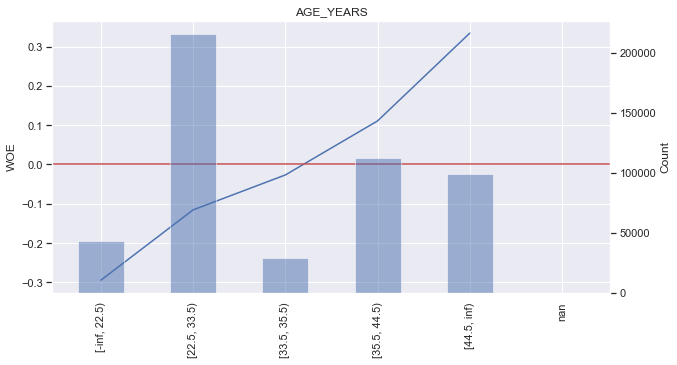

***

### APPL_DAY

CNT_TOTAL  CNT_DEF  \
BIN_APPL_DAY                                                            
WEEKEND                                             179540.0  16451.0   
WORKING_DAY_MON, WORKING_DAY_WED, HOLIDAY           141893.0  16422.0   
WORKING_DAY_THU, WORKING_DAY_TUE, WORKING_DAY_FRI   176906.0  21948.0   

                                                   DEF_RATE     WOE  DIST_BAD  \
BIN_APPL_DAY                                                                    
WEEKEND                                              0.0916  0.2014    0.3001   
WORKING_DAY_MON, WORKING_DAY_WED, HOLIDAY            0.1157 -0.0568    0.2996   
WORKING_DAY_THU, WORKING_DAY_TUE, WORKING_DAY_FRI    0.1241 -0.1351    0.4004   

                                                   DIST_GOOD  WOE_check  \
BIN_APPL_DAY                                                              
WEEKEND                                               0.3677     0.2032   
WORKING_DAY_MON, WORKING_DAY_WED, HOLIDAY             0.2829    -0.0572   
WORKING_DAY_THU, WORKING_DAY_TUE, WORKING_DAY_FRI     0.3494    -0.1362   

                                                       IV   SHARE  
BIN_APPL_DAY                                                       
WEEKEND                                            0.0137  0.3603  
WORKING_DAY_MON, WORKING_DAY_WED, HOLIDAY          0.0010  0.2847  
WORKING_DAY_THU, WORKING_DAY_TUE, WORKING_DAY_FRI  0.0069  0.3550

IV: 0.0216
Gini: 7.62


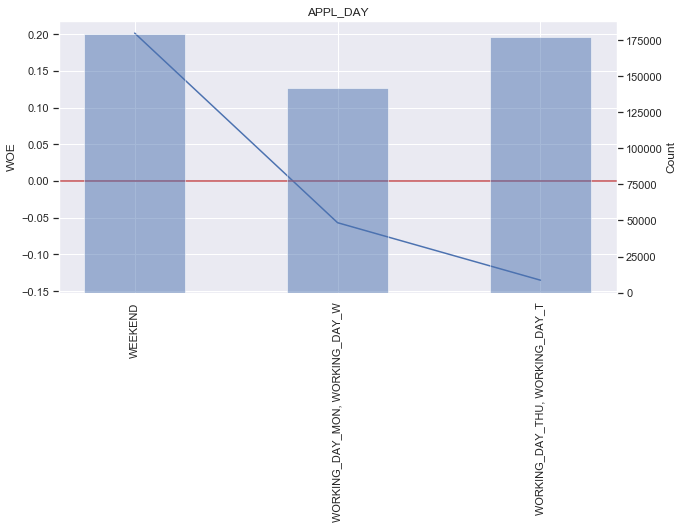

***

### DEPENDENTNUMBER

CNT_TOTAL  CNT_DEF  DEF_RATE  DIST_BAD  DIST_GOOD  \
BIN_DEPENDENTNUMBER                                                      
[-inf, 2.5)           423515.0  45588.0    0.1076    0.8316     0.8521   
[2.5, inf)             74824.0   9233.0    0.1234    0.1684     0.1479   
nan                        0.0      0.0       NaN    0.0000     0.0000   

                        WOE  WOE_check   SHARE  
BIN_DEPENDENTNUMBER                             
[-inf, 2.5)          0.0242     0.0244  0.8499  
[2.5, inf)          -0.1290    -0.1300  0.1501  
nan                     NaN    -2.0907  0.0000

IV: 0.0032
Gini: 2.05


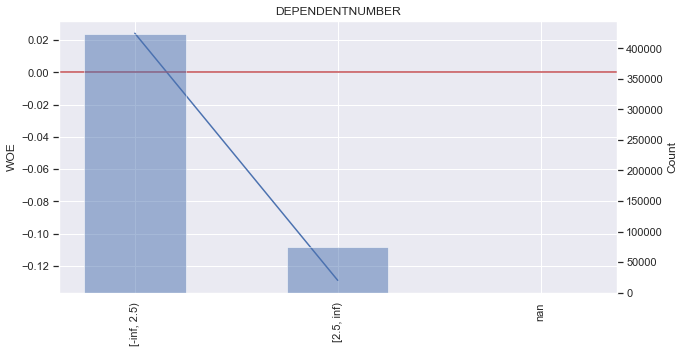

***

### DOC_SCORE0

CNT_TOTAL  CNT_DEF  DEF_RATE  DIST_BAD  DIST_GOOD     WOE  \
BIN_DOC_SCORE0                                                                
[-inf, 0.0444)      24596.0    663.0    0.0270    0.0121     0.0540  1.4681   
[0.0444, 0.0659)    31766.0   1618.0    0.0509    0.0295     0.0680  0.8238   
[0.0659, 0.0711)    30130.0   2584.0    0.0858    0.0471     0.0621  0.2733   
[0.0711, 0.0913)    28224.0   2351.0    0.0833    0.0429     0.0583  0.3048   
[0.0913, 0.116)    224647.0  24249.0    0.1079    0.4423     0.4518  0.0211   
[0.116, 0.1254)    120986.0  18302.0    0.1513    0.3339     0.2315 -0.3635   
[0.1254, inf)       27436.0   3812.0    0.1389    0.0695     0.0533 -0.2646   
nan                 10554.0   1242.0    0.1177    0.0227     0.0210 -0.0755   

                  WOE_check   SHARE  
BIN_DOC_SCORE0                       
[-inf, 0.0444)       1.4956  0.0494  
[0.0444, 0.0659)     0.8343  0.0637  
[0.0659, 0.0711)     0.2759  0.0605  
[0.0711, 0.0913)     0.3077  0.0566  
[0.0913, 0.116)      0.0213  0.4508  
[0.116, 0.1254)     -0.3660  0.2428  
[0.1254, inf)       -0.2666  0.0551  
nan                 -0.0761  0.0212

IV: 0.1457
Gini: 17.85


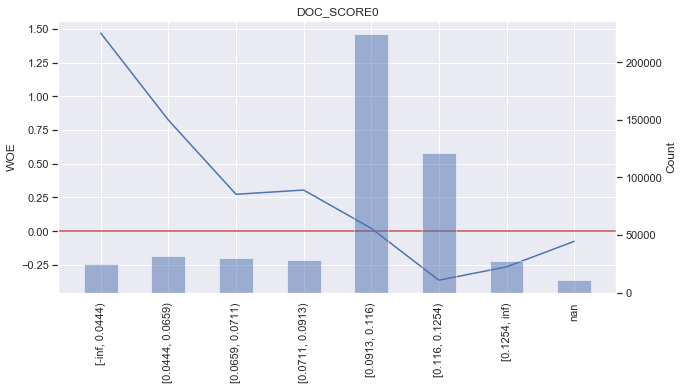

***

### EMPLOYMENT_DURATION_YEARS

CNT_TOTAL  CNT_DEF  DEF_RATE  DIST_BAD  \
BIN_EMPLOYMENT_DURATION_YEARS                                           
[-inf, 1.5)                     161658.0  21193.0    0.1311    0.3866   
[1.5, 3.5)                      101518.0  12356.0    0.1217    0.2254   
[3.5, 8.5)                      106964.0  10940.0    0.1023    0.1996   
[8.5, 10.5)                      29267.0   2530.0    0.0864    0.0462   
[10.5, inf)                      75777.0   5672.0    0.0749    0.1035   
nan                              23155.0   2130.0    0.0920    0.0389   

                               DIST_GOOD     WOE  WOE_check   SHARE  
BIN_EMPLOYMENT_DURATION_YEARS                                        
[-inf, 1.5)                       0.3167 -0.1979    -0.1994  0.3244  
[1.5, 3.5)                        0.2010 -0.1135    -0.1144  0.2037  
[3.5, 8.5)                        0.2165  0.0808     0.0815  0.2146  
[8.5, 10.5)                       0.0603  0.2647     0.2672  0.0587  
[10.5, inf)                       0.1581  0.4195     0.4238  0.1521  
nan                               0.0474  0.1971     0.1989  0.0465

IV: 0.0467
Gini: 11.52


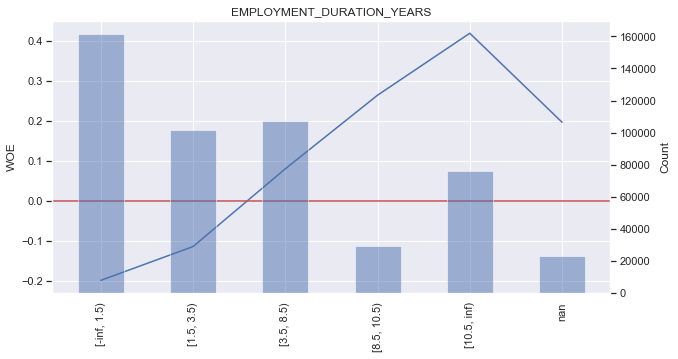

***

### EMPLOYMENT_INDUSTRY

CNT_TOTAL  CNT_DEF  \
BIN_EMPLOYMENT_INDUSTRY                                                  
CONSTRUCTION, CALL_CENTER, COMMUNICATION, LAWYE...    25143.0   3946.0   
GOVERNMENT, FINANCIAL, AGRICULTURE_MINING, ARMY...    39861.0   3313.0   
HEALTH, EDUCATION                                     47571.0   2523.0   
OTHER, TRADE, MANUFACTURING_PROCES, COMMERCIAL,...   144234.0  16535.0   
SERVICES                                             189486.0  22714.0   
TRANSPORTATION, REAL_ESTATE, HOUSEHOLD_SERVICE        28889.0   3660.0   
nan                                                   23155.0   2130.0   

                                                    DEF_RATE     WOE  \
BIN_EMPLOYMENT_INDUSTRY                                                
CONSTRUCTION, CALL_CENTER, COMMUNICATION, LAWYE...    0.1569 -0.4067   
GOVERNMENT, FINANCIAL, AGRICULTURE_MINING, ARMY...    0.0831  0.3072   
HEALTH, EDUCATION                                     0.0530  0.7819   
OTHER, TRADE, MANUFACTURING_PROCES, COMMERCIAL,...    0.1146 -0.0461   
SERVICES                                              0.1199 -0.0963   
TRANSPORTATION, REAL_ESTATE, HOUSEHOLD_SERVICE        0.1267 -0.1589   
nan                                                   0.0920  0.1971   

                                                    DIST_BAD  DIST_GOOD  \
BIN_EMPLOYMENT_INDUSTRY                                                   
CONSTRUCTION, CALL_CENTER, COMMUNICATION, LAWYE...    0.0720     0.0478   
GOVERNMENT, FINANCIAL, AGRICULTURE_MINING, ARMY...    0.0604     0.0824   
HEALTH, EDUCATION                                     0.0460     0.1016   
OTHER, TRADE, MANUFACTURING_PROCES, COMMERCIAL,...    0.3016     0.2879   
SERVICES                                              0.4143     0.3760   
TRANSPORTATION, REAL_ESTATE, HOUSEHOLD_SERVICE        0.0668     0.0569   
nan                                                   0.0389     0.0474   

                                                    WOE_check      IV   SHARE  
BIN_EMPLOYMENT_INDUSTRY                                                        
CONSTRUCTION, CALL_CENTER, COMMUNICATION, LAWYE...    -0.4095  0.0099  0.0505  
GOVERNMENT, FINANCIAL, AGRICULTURE_MINING, ARMY...     0.3101  0.0068  0.0800  
HEALTH, EDUCATION                                      0.7916  0.0440  0.0955  
OTHER, TRADE, MANUFACTURING_PROCES, COMMERCIAL,...    -0.0465  0.0006  0.2894  
SERVICES                                              -0.0970  0.0037  0.3802  
TRANSPORTATION, REAL_ESTATE, HOUSEHOLD_SERVICE        -0.1601  0.0016  0.0580  
nan                                                    0.1989  0.0017  0.0465

IV: 0.0683
Gini: 11.45


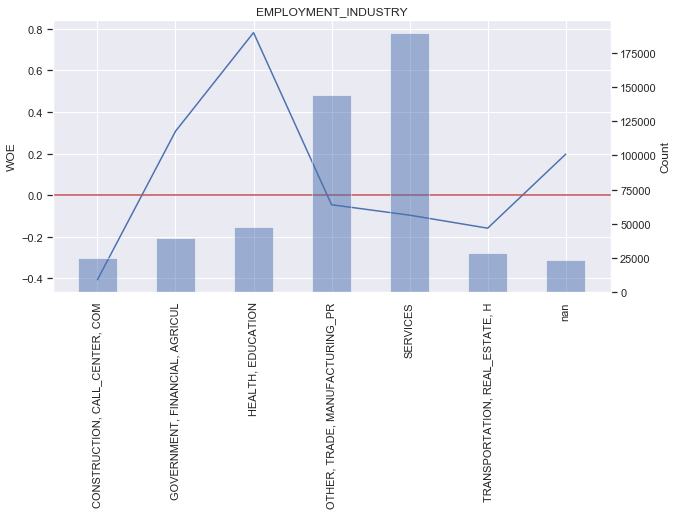

***

### FAMILYSTATE

CNT_TOTAL  CNT_DEF  DEF_RATE     WOE  DIST_BAD  \
BIN_FAMILYSTATE                                                               
MARRIED, WIDOWED, SEPARATED   256254.0  22834.0    0.0891  0.2318    0.4165   
SINGLE                        242085.0  31987.0    0.1321 -0.2069    0.5835   

                             DIST_GOOD  WOE_check      IV   SHARE  
BIN_FAMILYSTATE                                                    
MARRIED, WIDOWED, SEPARATED     0.5263     0.2339  0.0257  0.5142  
SINGLE                          0.4737    -0.2084  0.0229  0.4858

IV: 0.0486
Gini: 10.98


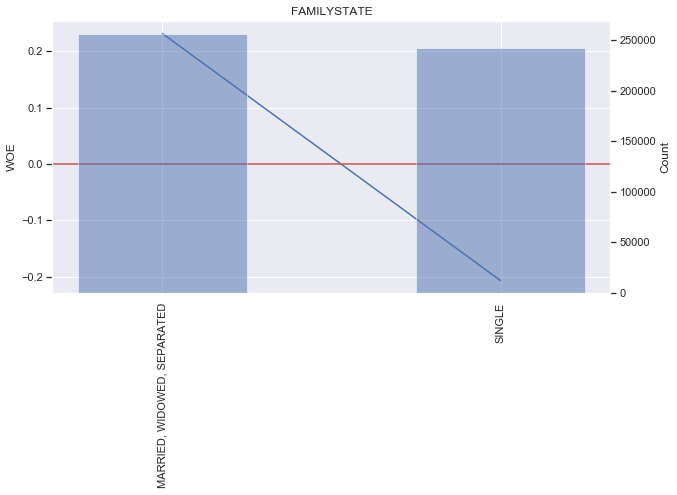

***

### HC_DAYS

CNT_TOTAL  CNT_DEF  DEF_RATE  DIST_BAD  DIST_GOOD     WOE  \
BIN_HC_DAYS                                                              
[-inf, 0.5)   497662.0  54715.0    0.1099    0.9981     0.9987  0.0006   
[0.5, inf)       677.0    106.0    0.1566    0.0019     0.0013 -0.4040   
nan                0.0      0.0       NaN    0.0000     0.0000     NaN   

             WOE_check   SHARE  
BIN_HC_DAYS                     
[-inf, 0.5)     0.0006  0.9986  
[0.5, inf)     -0.4067  0.0014  
nan            -2.0907  0.0000

IV: 0.0003
Gini: 0.06


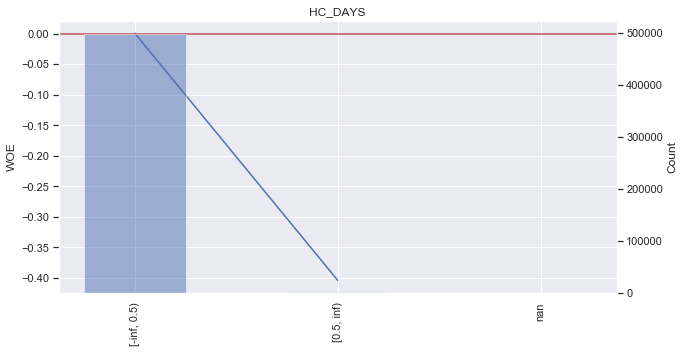

***

### HC_HISTREJECTED

CNT_TOTAL  CNT_DEF  DEF_RATE  DIST_BAD  DIST_GOOD  \
BIN_HC_HISTREJECTED                                                      
[-inf, 0.5)           494357.0  53799.0    0.1088    0.9814     0.9933   
[0.5, inf)              3982.0   1022.0    0.2567    0.0186     0.0067   
nan                        0.0      0.0       NaN    0.0000     0.0000   

                        WOE  WOE_check  SHARE  
BIN_HC_HISTREJECTED                            
[-inf, 0.5)          0.0120     0.0121  0.992  
[0.5, inf)          -1.0219    -1.0272  0.008  
nan                     NaN    -2.0907  0.000

IV: 0.0124
Gini: 1.20


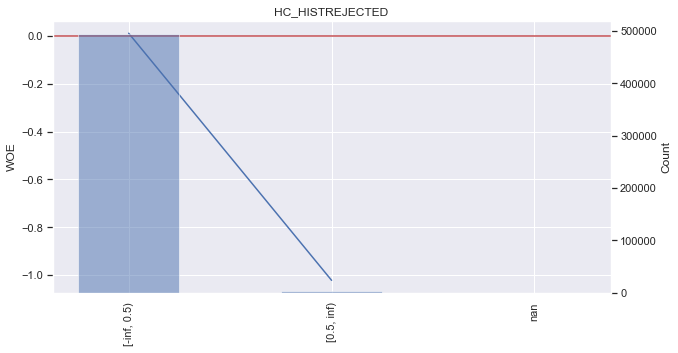

***

### HOUSETYPE

CNT_TOTAL  CNT_DEF  \
BIN_HOUSETYPE                                                            
OWNED, MORTGAGED, LIVING_WITH_PARENTS, PROVIDED...   386735.0  41129.0   
RENTED, LIVING_WITH_RELATIVES                        111604.0  13692.0   

                                                    DEF_RATE     WOE  \
BIN_HOUSETYPE                                                          
OWNED, MORTGAGED, LIVING_WITH_PARENTS, PROVIDED...    0.1063  0.0376   
RENTED, LIVING_WITH_RELATIVES                         0.1227 -0.1225   

                                                    DIST_BAD  DIST_GOOD  \
BIN_HOUSETYPE                                                             
OWNED, MORTGAGED, LIVING_WITH_PARENTS, PROVIDED...    0.7502     0.7792   
RENTED, LIVING_WITH_RELATIVES                         0.2498     0.2208   

                                                    WOE_check      IV  SHARE  
BIN_HOUSETYPE                                                                 
OWNED, MORTGAGED, LIVING_WITH_PARENTS, PROVIDED...     0.0379  0.0011  0.776  
RENTED, LIVING_WITH_RELATIVES                         -0.1234  0.0036  0.224

IV: 0.0047
Gini: 2.90


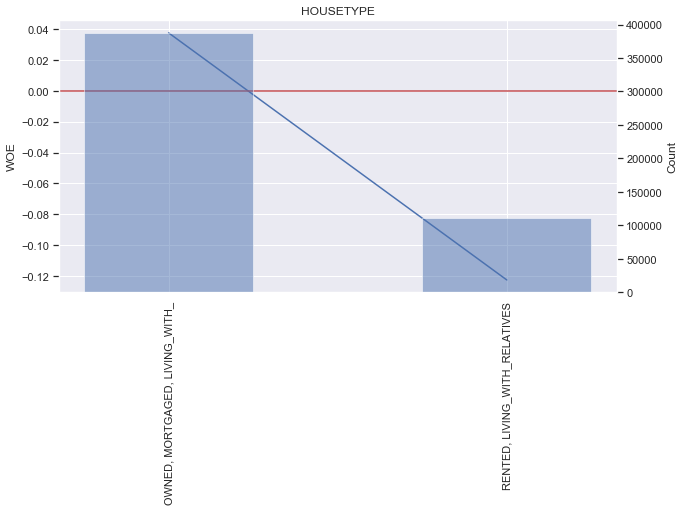

***

### INCOMETYPE

CNT_TOTAL  CNT_DEF  \
BIN_INCOMETYPE                                                           
GOVERNMENT_EMPLOYEE, RETIRED, PERSON_IN_HOUSEHO...    89098.0   6052.0   
PRIVATE_SECTOR_EMPLOYEE, SELFEMPLOYED, UNEMPLOYED    409241.0  48769.0   

                                                    DEF_RATE     WOE  \
BIN_INCOMETYPE                                                         
GOVERNMENT_EMPLOYEE, RETIRED, PERSON_IN_HOUSEHO...    0.0679  0.5227   
PRIVATE_SECTOR_EMPLOYEE, SELFEMPLOYED, UNEMPLOYED     0.1192 -0.0896   

                                                    DIST_BAD  DIST_GOOD  \
BIN_INCOMETYPE                                                            
GOVERNMENT_EMPLOYEE, RETIRED, PERSON_IN_HOUSEHO...    0.1104     0.1872   
PRIVATE_SECTOR_EMPLOYEE, SELFEMPLOYED, UNEMPLOYED     0.8896     0.8128   

                                                    WOE_check      IV   SHARE  
BIN_INCOMETYPE                                                                 
GOVERNMENT_EMPLOYEE, RETIRED, PERSON_IN_HOUSEHO...     0.5283  0.0406  0.1788  
PRIVATE_SECTOR_EMPLOYEE, SELFEMPLOYED, UNEMPLOYED     -0.0903  0.0069  0.8212

IV: 0.0475
Gini: 7.68


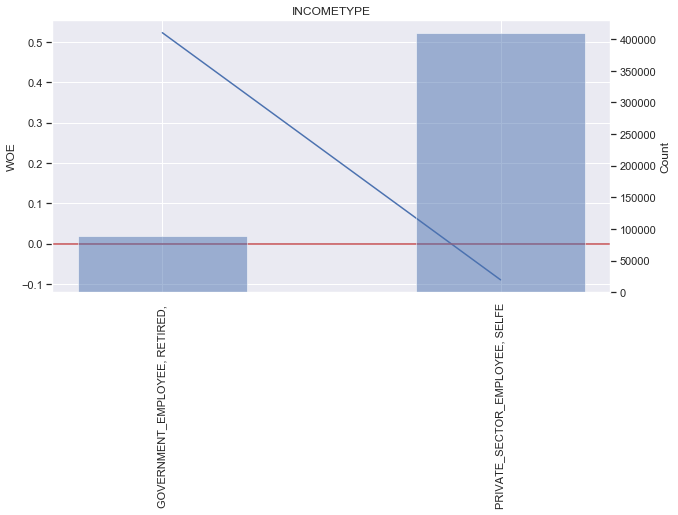

***

### MAINOCCUPATIONINCOME

CNT_TOTAL  CNT_DEF  DEF_RATE  DIST_BAD  DIST_GOOD  \
BIN_MAINOCCUPATIONINCOME                                                      
[-inf, 8705.0)              86610.0   7865.0    0.0908    0.1435     0.1775   
[8705.0, 12809.0)          122195.0  13845.0    0.1133    0.2525     0.2443   
[12809.0, 18435.0)         137486.0  17719.0    0.1289    0.3232     0.2700   
[18435.0, 28034.5)          92649.0   9688.0    0.1046    0.1767     0.1871   
[28034.5, inf)              59399.0   5704.0    0.0960    0.1040     0.1211   
nan                             0.0      0.0       NaN    0.0000     0.0000   

                             WOE  WOE_check   SHARE  
BIN_MAINOCCUPATIONINCOME                             
[-inf, 8705.0)            0.2112     0.2131  0.1738  
[8705.0, 12809.0)        -0.0330    -0.0332  0.2452  
[12809.0, 18435.0)       -0.1784    -0.1798  0.2759  
[18435.0, 28034.5)        0.0563     0.0568  0.1859  
[28034.5, inf)            0.1502     0.1515  0.1192  
nan                          NaN    -2.0907  0.0000

IV: 0.0203
Gini: 7.98


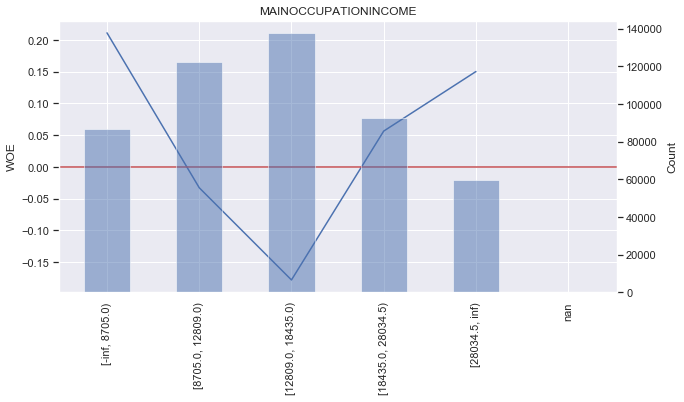

***

### PAYTYPE

CNT_TOTAL  CNT_DEF  DEF_RATE     WOE  DIST_BAD  DIST_GOOD  \
BIN_PAYTYPE                                                              
DD             81849.0   7598.0    0.0928  0.1872    0.1386     0.1674   
OTHER         416490.0  47223.0    0.1134 -0.0338    0.8614     0.8326   

             WOE_check      IV   SHARE  
BIN_PAYTYPE                             
DD              0.1889  0.0054  0.1642  
OTHER          -0.0340  0.0010  0.8358

IV: 0.0064
Gini: 2.88


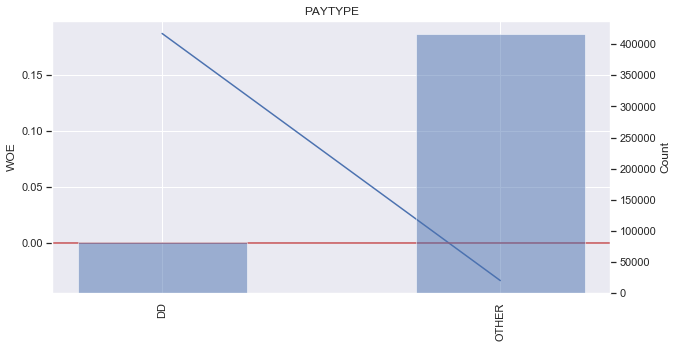

***

### REMITTANCE_AMOUNT

CNT_TOTAL  CNT_DEF  DEF_RATE  DIST_BAD  DIST_GOOD  \
BIN_REMITTANCE_AMOUNT                                                      
[-inf, 5600.825)          3100.0    488.0    0.1574    0.0089     0.0059   
[5600.825, 31052.5)      24331.0   2601.0    0.1069    0.0474     0.0490   
[31052.5, inf)            8226.0    608.0    0.0739    0.0111     0.0172   
nan                     462682.0  51124.0    0.1105    0.9326     0.9279   

                          WOE  WOE_check   SHARE  
BIN_REMITTANCE_AMOUNT                             
[-inf, 5600.825)      -0.4103    -0.4131  0.0062  
[5600.825, 31052.5)    0.0319     0.0321  0.0488  
[31052.5, inf)         0.4330     0.4374  0.0165  
nan                   -0.0049    -0.0050  0.9284

IV: 0.0040
Gini: 1.07


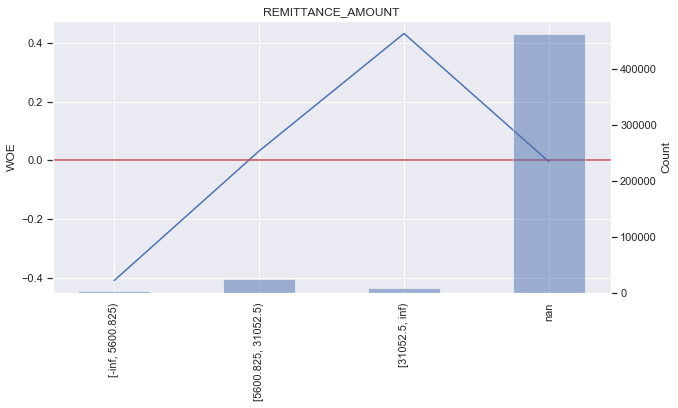

***

### SEX

CNT_TOTAL  CNT_DEF  DEF_RATE     WOE  DIST_BAD  DIST_GOOD  WOE_check  \
BIN_SEX                                                                         
F         259186.0  26407.0    0.1019  0.0851    0.4817     0.5248     0.0858   
M         239153.0  28414.0    0.1188 -0.0862    0.5183     0.4752    -0.0869   

             IV   SHARE  
BIN_SEX                  
F        0.0037  0.5201  
M        0.0038  0.4799

IV: 0.0075
Gini: 4.32


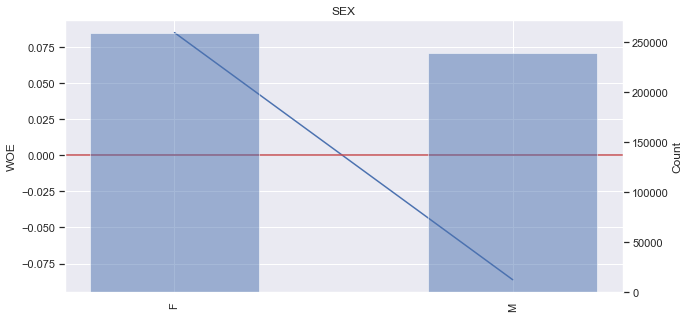

In [53]:
documentation.GroupingPlots(
    data,
    predictors  =cols_pred,
    sample="Train",
    target=col_target,
    grouping=grouping,
    output_folder = output_folder,
    #     weight=col_weight
)

# Interactive Grouping (beta)

# The json file created in previous step is compatible with interactive grouping, so it its still possible to do manual changes

In [54]:
USE_INTERATIVE_GROUPING = True

In [55]:
if USE_INTERATIVE_GROUPING:
    from scoring.grouping import Grouping, InteractiveGrouping

    grouping = InteractiveGrouping(
        columns=sorted(cols_pred_num),
        cat_columns=sorted(cols_pred_cat),
        group_count=5,
        min_samples=100,
        min_samples_cat=100,
        woe_smooth_coef=0.001,
    )

<IPython.core.display.Javascript object>


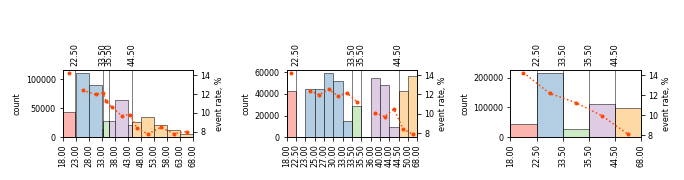

In [56]:
warnings.filterwarnings('ignore')

if USE_INTERATIVE_GROUPING:
    sns.reset_orig()
    %matplotlib notebook
    %config InlineBackend.close_figures=False  
    
    grouping.display(
        train_t=data[train_mask][cols_pred_num + cols_pred_cat + [col_target]],
        #train_t = data[train_mask][cols_pred_num+cols_pred_cat+[col_target]+[col_weight]],
        columns=sorted(cols_pred_num),
        cat_columns=sorted(cols_pred_cat),
        target_column=col_target,
        #w_column = col_weight,
        filename="mg.json",
        bin_count=10,
        woe_smooth_coef=0.001,
        group_count=5,
        min_samples=100,
        min_samples_cat=100,
    )
warnings.filterwarnings('once')

In [57]:
#reset the graphical environment to be used by the normal non-interactive charts
sns.set()
%matplotlib inline
%config InlineBackend.close_figures=True

# Apply the grouping to the datase

In [58]:
data_woe = grouping.transform(data, transform_to="woe", progress_bar=True)

Add WOE variabes to the data set

In [59]:
woe_columns_to_replace = list()
for column in data_woe.columns:
    if column in data:
        woe_columns_to_replace.append(column)
        print("Column", column, "dropped as it already existed in the data set.")
data = data.drop(woe_columns_to_replace, axis="columns")
data = data.join(data_woe)

del data_woe
gc.collect()

print("Added WOE variables. Number of columns:", data.shape[1])
cols_woe = [s + "_WOE" for s in cols_pred]

Added WOE variables. Number of columns: 53


Remove WOE variables with one WOE value only - they will have no predictive power.

In [60]:
cols_del = list()
for name, column in data[train_mask][cols_woe].iteritems():
    if (column.count() == 0) or (column.max() == column.min()):
        cols_del.append(name)
        cols_woe.remove(name)

if len(cols_del) > 0:
    print("Variables", cols_del, "will not be further used as they have only 1 unique WOE level.")
else:
    print("All predictors have more than 1 unique WOE level.")

All predictors have more than 1 unique WOE level.


# View stability charts (on full data)

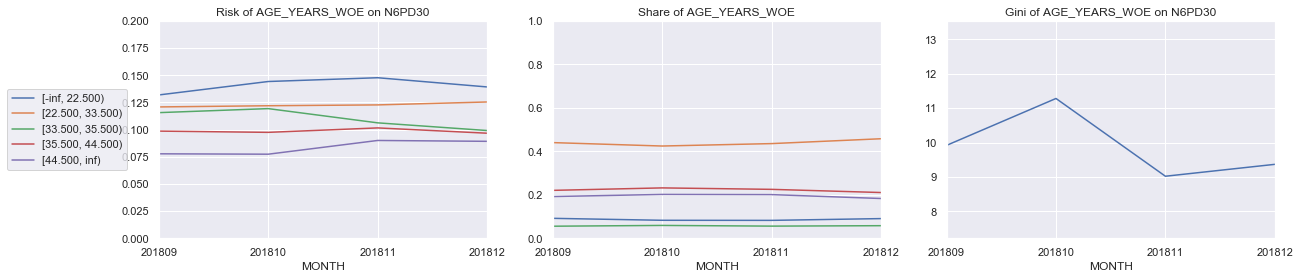

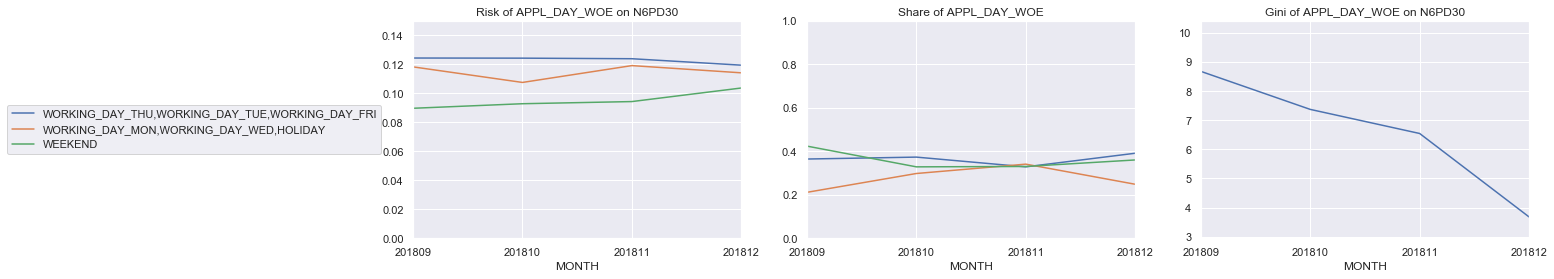

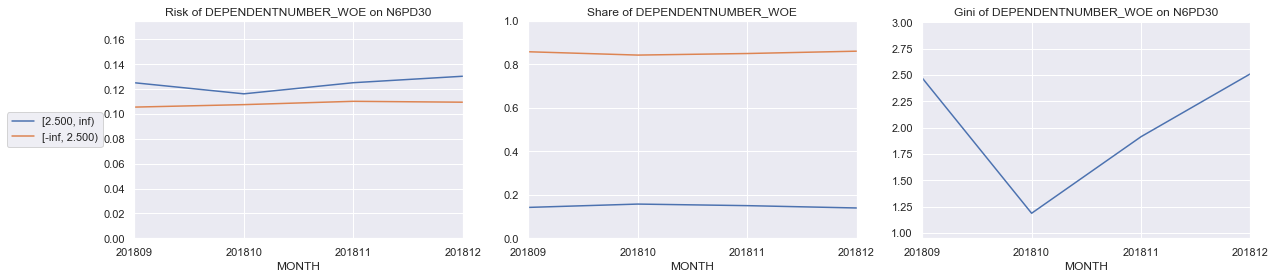

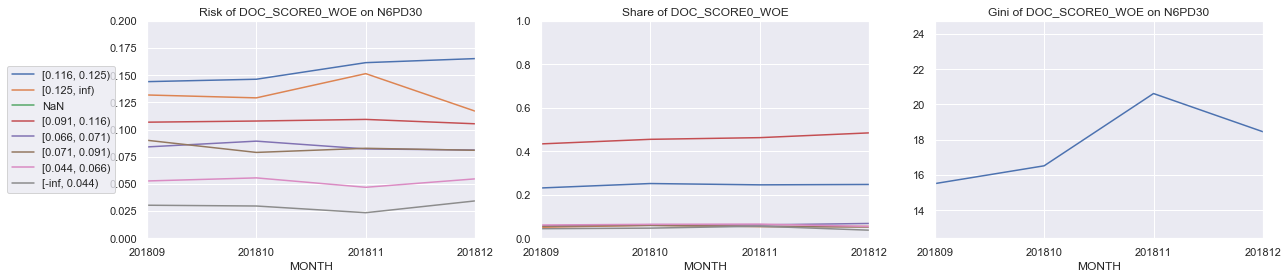

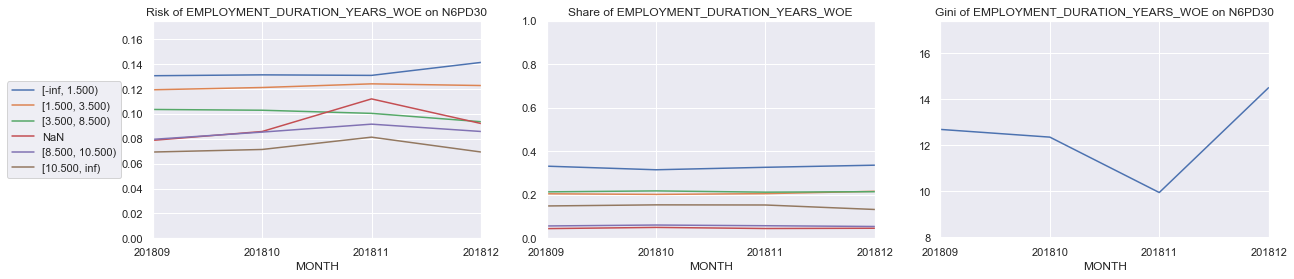

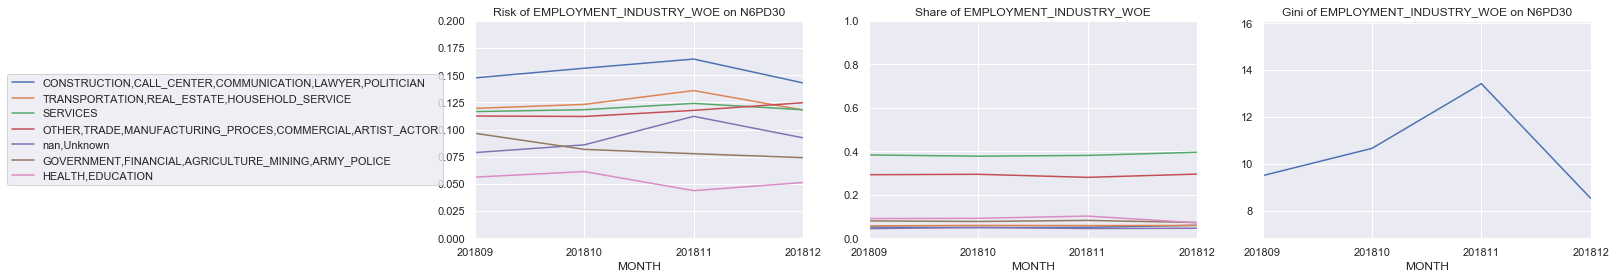

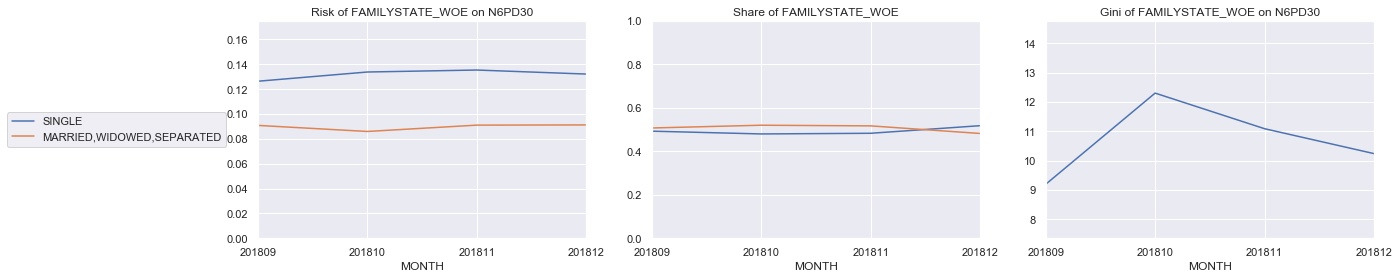

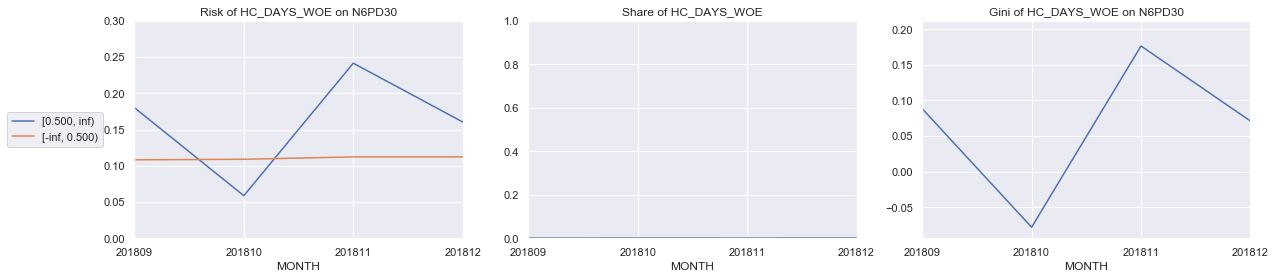

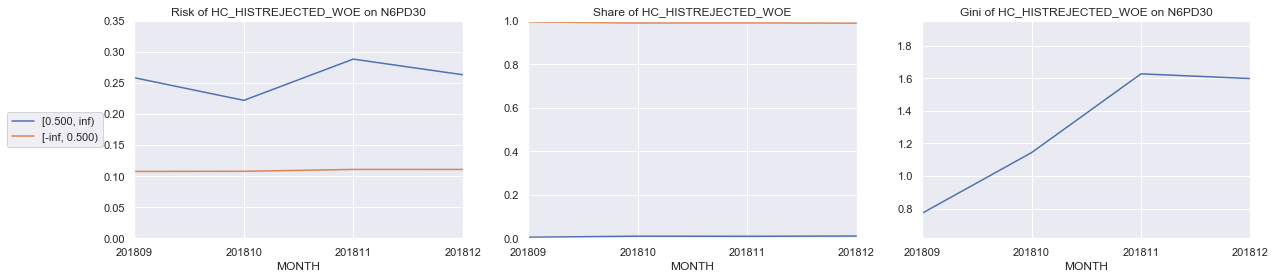

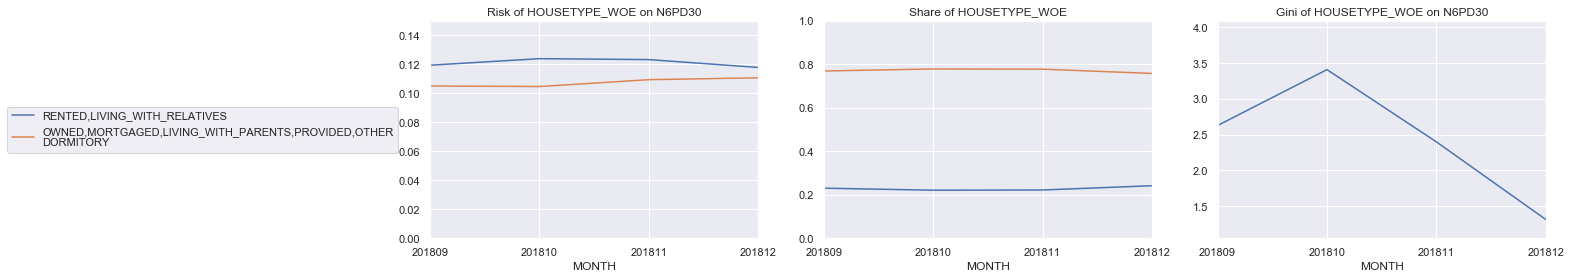

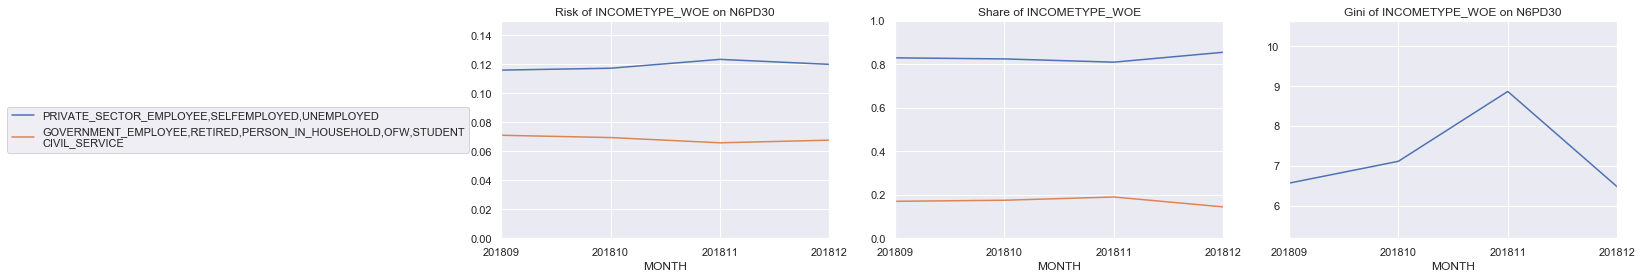

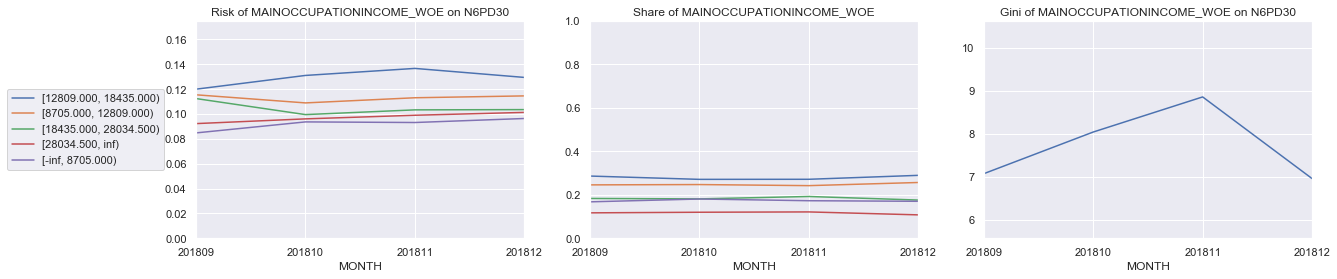

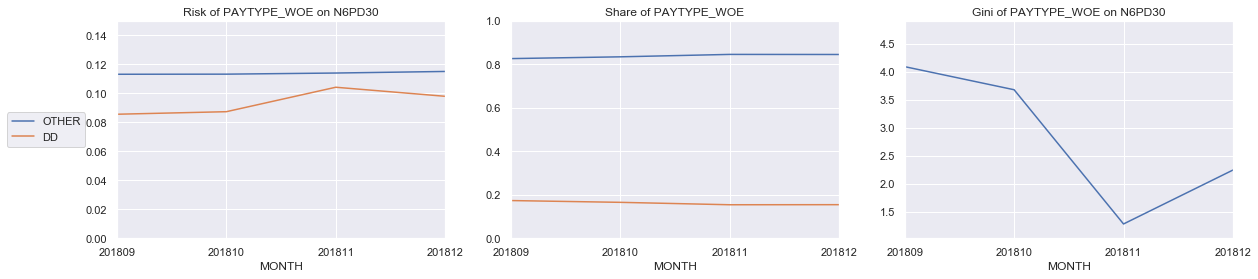

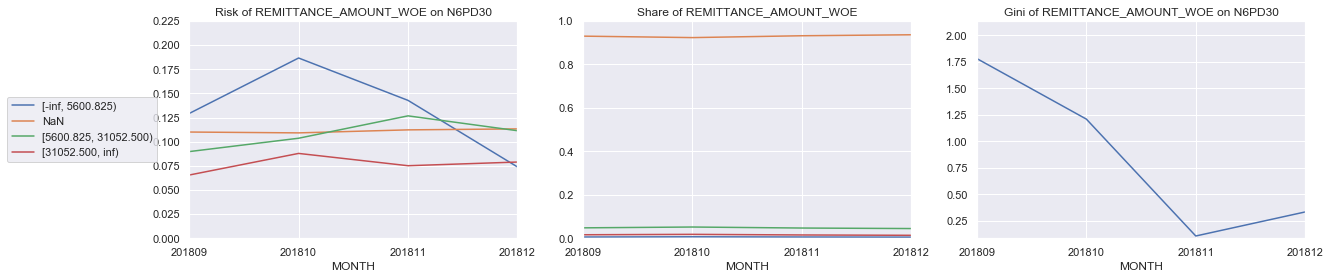

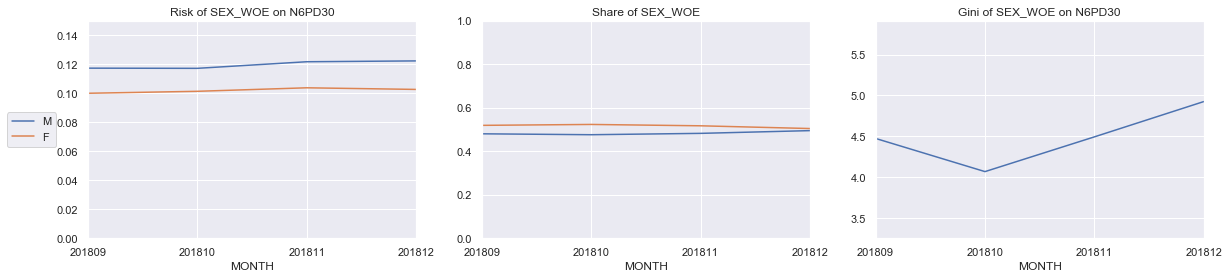

In [61]:
for col in list(cols_woe):
    documentation.GroupedEvaluation(
        data, 
        predictor=col,
        sample="Observable",
        target=col_target,
        grouping=grouping,
        weight=col_weight,
        output_folder=output_folder + "/stability",
    )

# ..... rest of workflow .........